In [84]:
import numpy as np
from scipy.integrate import odeint
import importlib.util
import scipy.stats
from scipy import signal
import matplotlib.pyplot as plt
import copy
import sys
import os
from sklearn.linear_model import LinearRegression

file_path_ekf = '/home/austin/Drone_AFRL/ekf.py'
EKF_Module = 'ekf'
# Load the EKF module
spec_ekf = importlib.util.spec_from_file_location(EKF_Module, file_path_ekf)
EKF = importlib.util.module_from_spec(spec_ekf)
sys.modules[EKF_Module] = EKF
spec_ekf.loader.exec_module(EKF)

# Manually specify the path to the directory containing plot_utility.py
util_path = '/home/austin/Drone_AFRL/util'

# Add the directory to the Python path
sys.path.append(util_path)

# import the function we want from that file
from plot_utility import plot_tme

# Define the file path
file_path = '/home/austin/Drone_AFRL/MPC_DRONE_WITH_WIND.py'


# Define the module name
module_name = 'MPC_DRONE'

# Load the module
spec = importlib.util.spec_from_file_location(module_name, file_path)
MPCD = importlib.util.module_from_spec(spec)
sys.modules[module_name] = MPCD
spec.loader.exec_module(MPCD)

ekf.py loaded successfully
MPC_DRONE_WITH_WIND.py imported successfully!


# <center> Uploading real drone data <center>

In [2]:
# load all files in the directory /CSV into data frames with names corresponding to the file names remove "test_bag__slash" from the start of the name
import glob
import pandas as pd

# Load the data
sub_path = 'neg_X'
path = '/home/austin/Drone_AFRL/CSV/'+ sub_path
all_files = glob.glob(path + "/*.csv")
data = {}

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    data[os.path.basename(filename)[len(sub_path)+8:-4]] = df

data = {key.replace("_slash_", "/"): value for key, value in data.items()}

for key in data.keys():
    print(key)

optic_flow/camera/mean/x
trisonica_global
mavros/imu/data
drone/rpy/degrees
mavros/rc/in
optic_flow
optic_flow/camera/mean/y
mavros/local_position/pose
drone/rpy/radians
optic_flow/wind_sensor/mean/y
optic_flow/global/mean/x
mavros/rc/out
trisonica_body_level
optic_flow/wind_sensor/mean/x
trisonica
optic_flow/global/mean/y


# <center> Ground Truth (Mocap) <center>

In [3]:
data['mavros/local_position/pose']

rosbagTimestamp  header    seq  stamp        secs      nsecs  \
0     1726109483478350322     NaN  10947    NaN  1722536971  535796352   
1     1726109483504783016     NaN  10948    NaN  1722536971  556796352   
2     1726109483537233460     NaN  10949    NaN  1722536971  588796352   
3     1726109483570342591     NaN  10950    NaN  1722536971  630795328   
4     1726109483605488048     NaN  10951    NaN  1722536971  662795328   
...                   ...     ...    ...    ...         ...        ...   
1366  1726109529002994174     NaN  12313    NaN  1722537017   61377280   
1367  1726109529041504447     NaN  12314    NaN  1722537017   93377280   
1368  1726109529071718442     NaN  12315    NaN  1722537017  125377536   
1369  1726109529104276123     NaN  12316    NaN  1722537017  157377536   
1370  1726109529135210368     NaN  12317    NaN  1722537017  189377536   

     frame_id  pose  position         x         y         z  orientation  \
0       "map"   NaN       NaN -0.652569 -0.065167  0.263797          NaN   
1       "map"   NaN       NaN -0.653235 -0.067521  0.269789          NaN   
2       "map"   NaN       NaN -0.653975 -0.070847  0.279517          NaN   
3       "map"   NaN       NaN -0.654530 -0.075028  0.293698          NaN   
4       "map"   NaN       NaN -0.654661 -0.077822  0.305181          NaN   
...       ...   ...       ...       ...       ...       ...          ...   
1366    "map"   NaN       NaN -2.240180 -0.407701  1.711027          NaN   
1367    "map"   NaN       NaN -2.236877 -0.405932  1.707903          NaN   
1368    "map"   NaN       NaN -2.232738 -0.404392  1.704727          NaN   
1369    "map"   NaN       NaN -2.227789 -0.403028  1.701617          NaN   
1370    "map"   NaN       NaN -2.222057 -0.401897  1.698440          NaN   

           x.1       y.1       z.1         w  
0    -0.018975 -0.025734  0.775479 -0.630563  
1    -0.016044 -0.025491  0.776270 -0.629680  
2    -0.014354 -0.017971  0.777786 -0.628108  
3    -0.013301 -0.012181  0.779157 -0.626569  
4    -0.012499 -0.010573  0.779659 -0.625991  
...        ...       ...       ...       ...  
1366 -0.001871 -0.055046  0.778569 -0.625138  
1367 -0.008477 -0.053814  0.777660 -0.626321  
1368 -0.013575 -0.050824  0.777174 -0.627083  
1369 -0.013996 -0.049630  0.777365 -0.626933  
1370 -0.017564 -0.044040  0.776588 -0.628222  

[1371 rows x 17 columns]

In [4]:
# import pandas as pd

# # Function to remove spikes based on IQR and replace them with the median
# def remove_spikes_iqr_replace_with_median(df):
#     """
#     Removes outliers based on the IQR method and replaces them with the median of the column.
#     Outliers are considered to be outside the 1.5 * IQR from the first and third quartiles,
#     but only for float columns.
    
#     Parameters:
#     - df: A Pandas DataFrame containing mixed data types.
    
#     Returns:
#     - Filtered DataFrame with outliers replaced by the median for float columns.
#     """
#     # Loop through each column and apply the IQR method to float columns
#     for column in df.columns:
#         if pd.api.types.is_float_dtype(df[column]):  # Only apply to float columns
#             Q1 = df[column].quantile(0.25)  # First quartile (25th percentile)
#             Q3 = df[column].quantile(0.75)  # Third quartile (75th percentile)
#             IQR = Q3 - Q1  # Interquartile range

#             # Define bounds for outliers
#             lower_bound = Q1 - 1.5 * IQR
#             upper_bound = Q3 + 1.5 * IQR

#             # Replace outliers with the median of the column
#             median_value = df[column].median()
#             df[column] = df[column].mask((df[column] < lower_bound) | (df[column] > upper_bound), median_value)

#     return df

# # Apply the IQR method to your DataFrame
# data['mavros/local_position/pose'] = remove_spikes_iqr_replace_with_median(data['mavros/local_position/pose'])


# function ro convert from quaternion to euler angles
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    R = math.degrees(math.atan2(t0, t1))

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    P = math.degrees(math.asin(t2))

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Y = math.degrees(math.atan2(t3, t4))

    return R, P, Y

# function that interpolates data based on two time arrays using numpy
def interpolate_data(time1, data1, time2):
    """
    input: time1 (interp from), data1 (interp from), time2 (interp to)
    output: interpolated data2
    """
    return np.interp(time2, time1, data1)

# function that takes in data frame and gives out time array based on the columns secs and nsecs
def time_array(data):
    "input: data frame with columns secs and nsecs"
    "output: array of time in seconds"
    time = []
    for i in range(len(data)):
        time.append(data['secs'][i] + data['nsecs'][i] * 1e-9)

    return time

# mocap_time = time_array(data['mavros/local_position/pose'])
mocap_time = data['mavros/local_position/pose']['rosbagTimestamp']/1e9
mocap_Roll, mocap_Pitch, mocap_Yaw = [], [], []
for i in range(len(data['mavros/local_position/pose'])):
    R, P, Y = quaternion_to_euler(data['mavros/local_position/pose']['x.1'][i],
                                  data['mavros/local_position/pose']['y.1'][i],
                                  data['mavros/local_position/pose']['z.1'][i],
                                  data['mavros/local_position/pose']['w'][i])
    mocap_Roll.append(R)
    mocap_Pitch.append(P)
    mocap_Yaw.append(Y)

mocap_X = data['mavros/local_position/pose']['x']
mocap_Y = data['mavros/local_position/pose']['y']
mocap_Z = data['mavros/local_position/pose']['z']

mocap_time_shifted = mocap_time - mocap_time[0]

# take the derivative of the mocap data to get the velocities
mocap_X_dot = np.gradient(mocap_X, mocap_time)
mocap_Y_dot = np.gradient(mocap_Y, mocap_time)
mocap_Z_dot = np.gradient(mocap_Z, mocap_time)

# take the derivative of the mocap data to get the accelerations
mocap_X_ddot = np.gradient(mocap_X_dot, mocap_time)
mocap_Y_ddot = np.gradient(mocap_Y_dot, mocap_time)
mocap_Z_ddot = np.gradient(mocap_Z_dot, mocap_time)


Mocap data time length: 1371
Mocap data Roll length: 1371
Mocap data Pitch length: 1371
Mocap data Yaw length: 1371


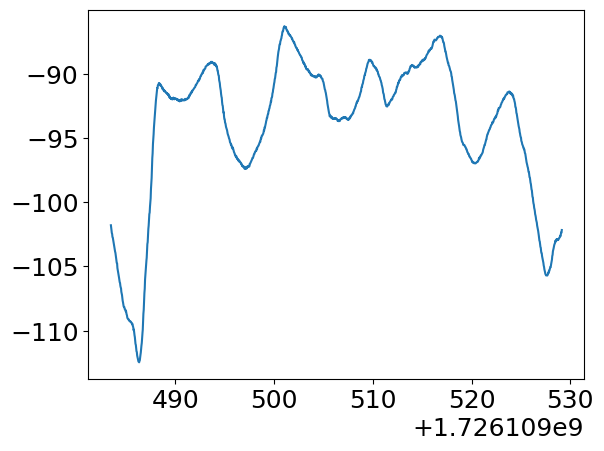

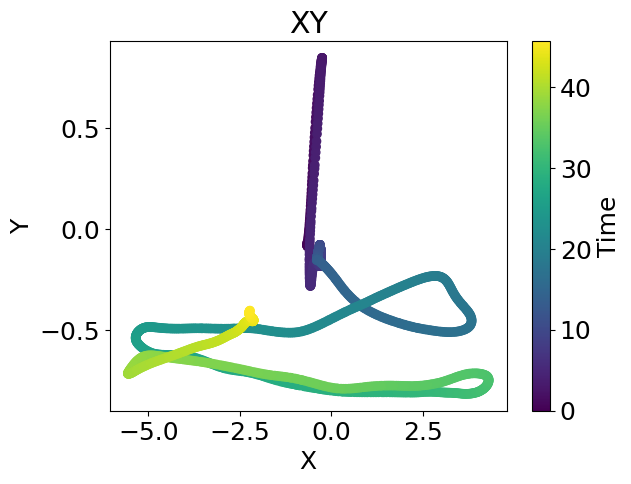

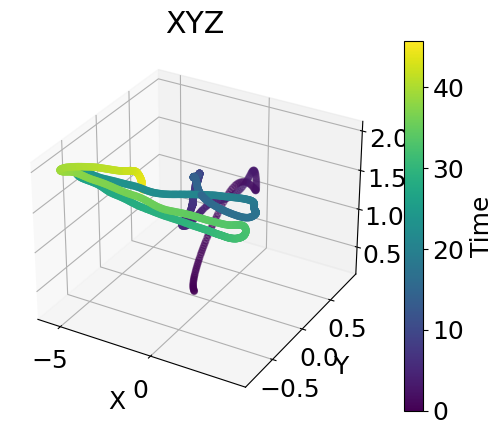

In [5]:
print('Mocap data time length:', len(mocap_time))
print('Mocap data Roll length:', len(mocap_Roll))
print('Mocap data Pitch length:', len(mocap_Pitch))
print('Mocap data Yaw length:', len(mocap_Yaw))

plt.plot(mocap_time, mocap_Yaw)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# make plot of XY and 2d plot of XY with time as color
plt.figure()
plt.scatter(mocap_X, mocap_Y, c=mocap_time_shifted)
plt.title('XY')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label='Time')
plt.show()

# make 3d plot of XYZ with time as color
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(mocap_X, mocap_Y, mocap_Z, c=mocap_time_shifted)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('XYZ')
plt.colorbar(sc, label='Time')
plt.show()


# <center> IMU (Roll,Pitch,Yaw) + (Roll_dot,Pitch_dot,Yaw_dot) + (X_acc,Y_acc,Z_acc)

In [6]:
data['mavros/imu/data']
# print columns of the imu data
for col in data['mavros/imu/data'].columns:
    print(col)

rosbagTimestamp
header
seq
stamp
secs
nsecs
frame_id
orientation
x
y
z
w
orientation_covariance
angular_velocity
x.1
y.1
z.1
angular_velocity_covariance
linear_acceleration
x.2
y.2
z.2
linear_acceleration_covariance


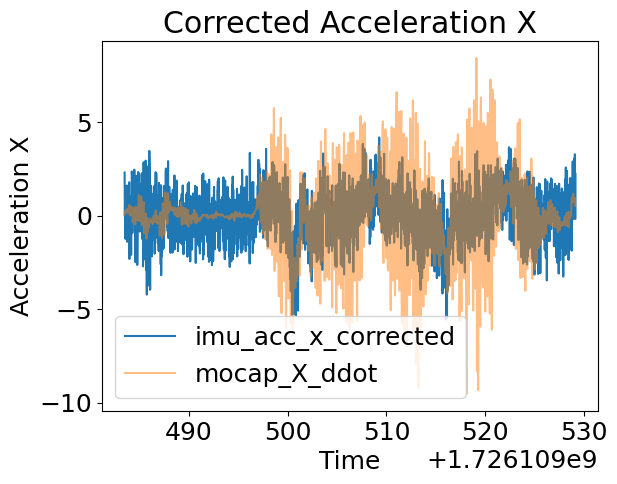

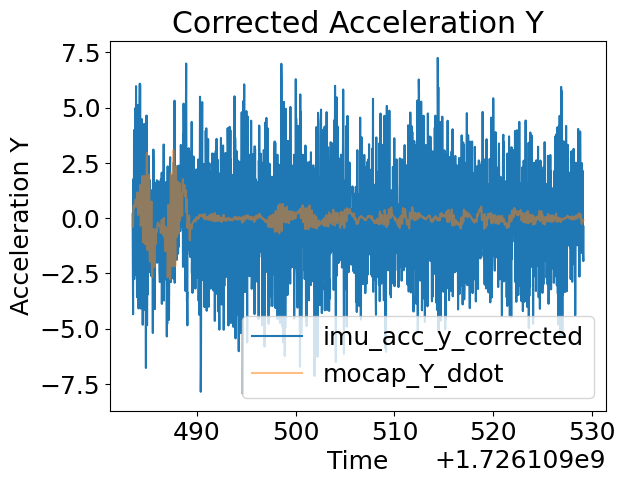

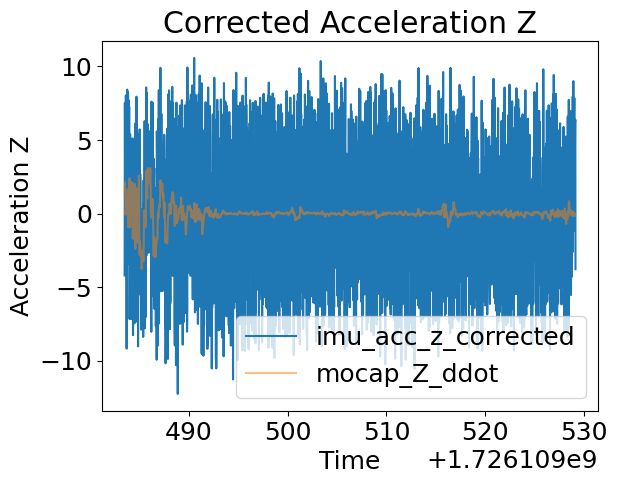

In [7]:
imu_time = data['mavros/imu/data']['rosbagTimestamp']/1e9
imu_time_shifted = imu_time - imu_time[0]
imu_Roll, imu_Pitch, imu_Yaw = [], [], []
for i in range(len(data['mavros/imu/data'])):
    R, P, Y = quaternion_to_euler(data['mavros/imu/data']['x'][i],
                                  data['mavros/imu/data']['y'][i],
                                  data['mavros/imu/data']['z'][i],
                                  data['mavros/imu/data']['w'][i])
    imu_Roll.append(np.radians(R))
    imu_Pitch.append(np.radians(P))
    imu_Yaw.append(np.radians(Y))

imu_Roll_rate = data['mavros/imu/data']['x.1']
imu_Pitch_rate = data['mavros/imu/data']['y.1']
imu_Yaw_rate = data['mavros/imu/data']['z.1']

g = 9.81  # Gravitational acceleration (m/s^2)

# Function to compute the rotation matrix from roll, pitch, yaw
def rotation_matrix_from_euler(roll, pitch, yaw):
    """
    Creates a rotation matrix from roll, pitch, yaw angles (in radians).
    """
    # Compute rotation matrices for roll, pitch, and yaw
    R_roll = np.array([
        [1, 0, 0],
        [0, np.cos(roll), -np.sin(roll)],
        [0, np.sin(roll), np.cos(roll)]
    ])
    
    R_pitch = np.array([
        [np.cos(pitch), 0, np.sin(pitch)],
        [0, 1, 0],
        [-np.sin(pitch), 0, np.cos(pitch)]
    ])
    
    R_yaw = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw), np.cos(yaw), 0],
        [0, 0, 1]
    ])
    
    # Combine the rotation matrices (Z * Y * X)
    R = R_yaw @ R_pitch @ R_roll
    return R

# Function to remove gravity from linear acceleration
def remove_gravity_from_acceleration(acc_x, acc_y, acc_z, roll, pitch, yaw):
    """
    Removes the gravity component from the linear acceleration in the body frame.
    
    acc_x, acc_y, acc_z: numpy arrays
        Arrays of linear acceleration in the body frame along the x, y, and z axes.
    roll, pitch, yaw: numpy arrays
        Arrays of roll, pitch, and yaw angles (in radians).
    
    Returns:
    acc_x_corrected, acc_y_corrected, acc_z_corrected: numpy arrays
        Corrected linear accelerations with gravity removed along the x, y, and z axes.
    """
    # Initialize corrected acceleration arrays
    acc_x_corrected = np.zeros_like(acc_x)
    acc_y_corrected = np.zeros_like(acc_y)
    acc_z_corrected = np.zeros_like(acc_z)
    
    # Gravity vector in the world frame (assume gravity points along the Z-axis)
    gravity_world = np.array([0, 0, g])
    
    # Loop over each time step and correct the acceleration
    for i in range(len(acc_x)):
        # Get the rotation matrix for the current orientation (roll, pitch, yaw)
        R = rotation_matrix_from_euler(roll[i], pitch[i], yaw[i])
        
        # Transform gravity vector from world frame to body frame
        gravity_body = R.T @ gravity_world  # Transpose R to rotate from world to body
        
        # Measured acceleration in body frame
        acc_body = np.array([acc_x[i], acc_y[i], acc_z[i]])
        
        # Subtract gravity from the body-frame acceleration
        acc_corrected = acc_body - gravity_body
        
        # Store the corrected acceleration
        acc_x_corrected[i] = acc_corrected[0]
        acc_y_corrected[i] = acc_corrected[1]
        acc_z_corrected[i] = acc_corrected[2]
    
    return acc_x_corrected, acc_y_corrected, acc_z_corrected

# Remove gravity from the linear acceleration
imu_acc_x_corrected, imu_acc_y_corrected, imu_acc_z_corrected = remove_gravity_from_acceleration(
    data['mavros/imu/data']['x.2'],
    data['mavros/imu/data']['y.2'],
    data['mavros/imu/data']['z.2'],
    imu_Roll, imu_Pitch, imu_Yaw
)

# rotate the acceleration data to the world frame
def rotate_acceleration_to_world_frame(acc_x, acc_y, acc_z, roll, pitch, yaw):
    """
    Rotates the linear acceleration from the body frame to the world frame.
    
    acc_x, acc_y, acc_z: numpy arrays
        Arrays of linear acceleration in the body frame along the x, y, and z axes.
    roll, pitch, yaw: numpy arrays
        Arrays of roll, pitch, and yaw angles (in radians).
    
    Returns:
    acc_x_world, acc_y_world, acc_z_world: numpy arrays
        Linear acceleration in the world frame along the x, y, and z axes.
    """
    # Initialize world-frame acceleration arrays
    acc_x_world = np.zeros_like(acc_x)
    acc_y_world = np.zeros_like(acc_y)
    acc_z_world = np.zeros_like(acc_z)
    
    # Loop over each time step and rotate the acceleration
    for i in range(len(acc_x)):
        # Get the rotation matrix for the current orientation (roll, pitch, yaw)
        R = rotation_matrix_from_euler(roll[i], pitch[i], yaw[i])
        
        # Measured acceleration in body frame
        acc_body = np.array([acc_x[i], acc_y[i], acc_z[i]])
        
        # Rotate the body-frame acceleration to the world frame
        acc_world = R @ acc_body
        
        # Store the world-frame acceleration
        acc_x_world[i] = acc_world[0]
        acc_y_world[i] = acc_world[1]
        acc_z_world[i] = acc_world[2]
    
    return acc_x_world, acc_y_world, acc_z_world

# Rotate the acceleration data to the world frame
imu_acc_x_corrected_world, imu_acc_y_corrected_world, imu_acc_z_corrected_world = rotate_acceleration_to_world_frame(
    imu_acc_x_corrected, imu_acc_y_corrected, imu_acc_z_corrected, imu_Roll, imu_Pitch, imu_Yaw
)

plt.plot(imu_time, imu_acc_x_corrected_world,label='imu_acc_x_corrected')
plt.plot(mocap_time, mocap_X_ddot,label='mocap_X_ddot',alpha=0.5)
plt.title('Corrected Acceleration X')
plt.xlabel('Time')
plt.ylabel('Acceleration X')
plt.legend()
plt.show()

plt.plot(imu_time, imu_acc_y_corrected_world,label='imu_acc_y_corrected')
plt.plot(mocap_time, mocap_Y_ddot,label='mocap_Y_ddot',alpha=0.5)
plt.title('Corrected Acceleration Y')
plt.xlabel('Time')
plt.ylabel('Acceleration Y')
plt.legend()
plt.show()

plt.plot(imu_time, imu_acc_z_corrected_world,label='imu_acc_z_corrected')
plt.plot(mocap_time, mocap_Z_ddot,label='mocap_Z_ddot',alpha=0.5)
plt.title('Corrected Acceleration Z')
plt.xlabel('Time')
plt.ylabel('Acceleration Z')
plt.legend()
plt.show()








# <center> Optic Flow (Camera data) <center>

In [8]:
data['optic_flow/camera/mean/x']

rosbagTimestamp        data
0     1726109483479515236 -245.673935
1     1726109483488925236 -214.131119
2     1726109483502891154 -142.430420
3     1726109483519644910  -91.650337
4     1726109483536876087  -38.339165
...                   ...         ...
2715  1726109529077929805  241.898880
2716  1726109529096810292  232.082535
2717  1726109529112937123  225.968948
2718  1726109529130869532  216.031647
2719  1726109529145867337  213.196381

[2720 rows x 2 columns]

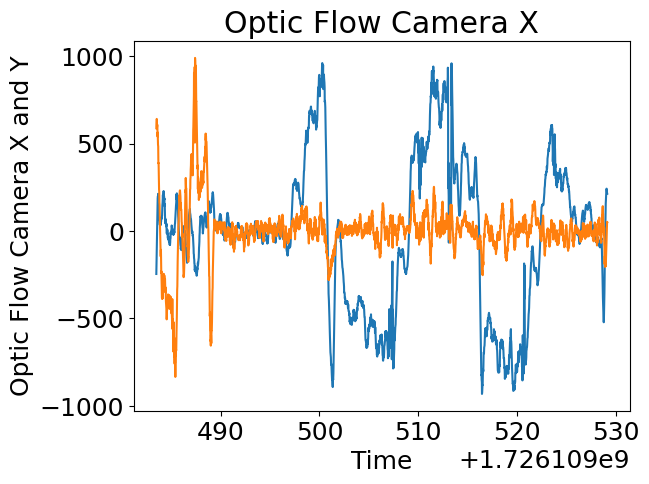

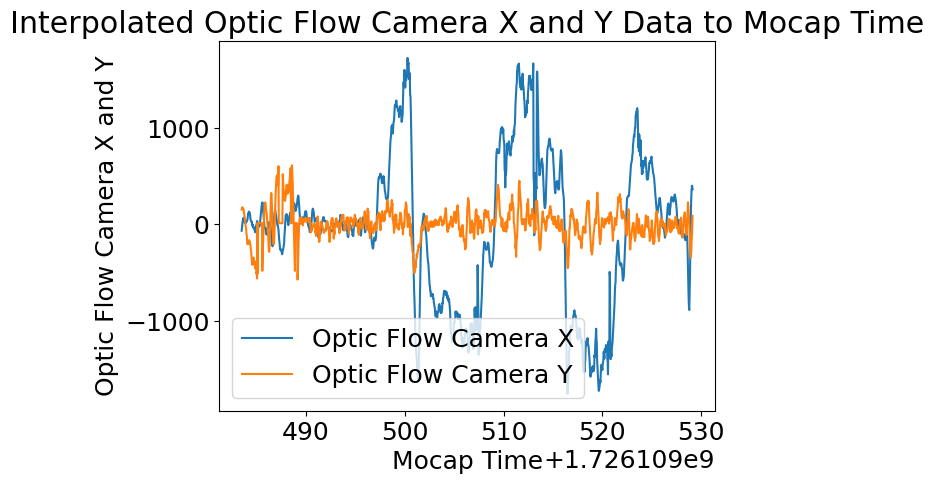

In [9]:
optic_flow_camera_x_time = data['optic_flow/camera/mean/x']['rosbagTimestamp']/1e9
optic_flow_camera_y_time = data['optic_flow/camera/mean/y']['rosbagTimestamp']/1e9
optic_flow_camera_x = data['optic_flow/camera/mean/x']['data']
optic_flow_camera_y = data['optic_flow/camera/mean/y']['data']

# print(optic_flow_camera_x_time==optic_flow_camera_y_time)

plt.plot(optic_flow_camera_x_time, optic_flow_camera_x)
plt.plot(optic_flow_camera_y_time, optic_flow_camera_y)
plt.title('Optic Flow Camera X')
plt.xlabel('Time')
plt.ylabel('Optic Flow Camera X and Y')
plt.show()



# interpolate optic flow camera data to mocap time
optic_flow_camera_x_mocap_interp = interpolate_data(optic_flow_camera_x_time, optic_flow_camera_x, mocap_time)
optic_flow_camera_y_mocap_interp = interpolate_data(optic_flow_camera_y_time, optic_flow_camera_y, mocap_time)

optic_flow_camera_x_mocap_interp=np.multiply(optic_flow_camera_x_mocap_interp, mocap_Z)
optic_flow_camera_y_mocap_interp=np.multiply(optic_flow_camera_y_mocap_interp, mocap_Z)

optic_flow_camera_x_mocap_interp[np.abs(optic_flow_camera_x_mocap_interp - np.median(optic_flow_camera_x_mocap_interp)) > 3 * np.std(optic_flow_camera_x_mocap_interp)] = np.median(optic_flow_camera_x_mocap_interp)
optic_flow_camera_y_mocap_interp[np.abs(optic_flow_camera_y_mocap_interp - np.median(optic_flow_camera_y_mocap_interp)) > 3 * np.std(optic_flow_camera_y_mocap_interp)] = np.median(optic_flow_camera_y_mocap_interp)



# Plot the interpolated data
plt.plot(mocap_time, optic_flow_camera_x_mocap_interp, label="Optic Flow Camera X")
plt.plot(mocap_time, optic_flow_camera_y_mocap_interp, label="Optic Flow Camera Y")
plt.title('Interpolated Optic Flow Camera X and Y Data to Mocap Time')
plt.xlabel('Mocap Time')
plt.ylabel('Optic Flow Camera X and Y')
plt.legend()
plt.show()


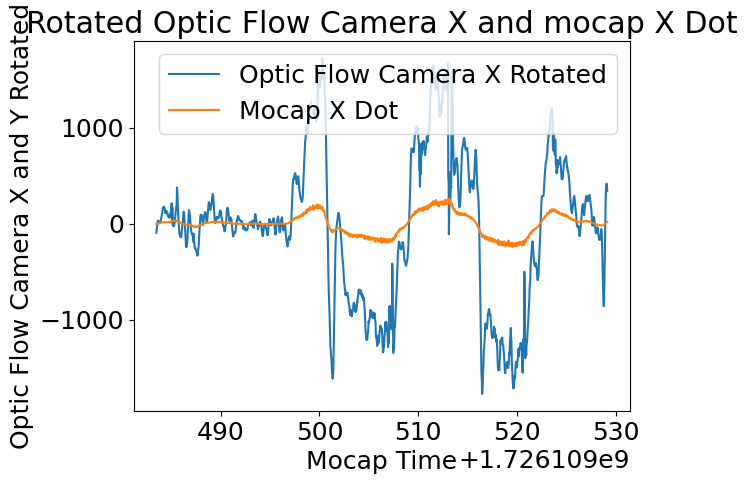

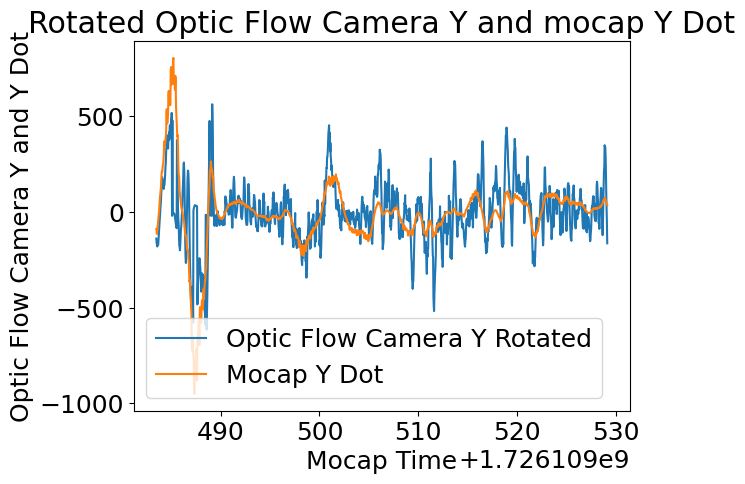

In [10]:
OFX=optic_flow_camera_x_mocap_interp
OFY=optic_flow_camera_y_mocap_interp
# apply a yaw rotation to the optic flow data using matrix multiplication
def rotate_optic_flow(OFX, OFY, Yaw):
    """
    input: OFX, OFY, Yaw
    output: rotated OFX, OFY
    """
    # apply a 180 degree rotation about x axis using the rotation matrix
    OFX = OFX*1
    OFY = OFY*np.cos(np.pi)

    # un yawing and rotating by 90 degrees
    OFY_rot = np.sin(Yaw+np.pi/2) * OFX + np.cos(Yaw+np.pi/2) * OFY
    OFX_rot = np.cos(Yaw+np.pi/2) * OFX - np.sin(Yaw+np.pi/2) * OFY
    return OFX_rot, OFY_rot


OFX_rot, OFY_rot = rotate_optic_flow(OFX, OFY, np.radians(mocap_Yaw))

# Plot the rotated optic flow data
plt.plot(mocap_time, np.multiply(OFX_rot,1), label="Optic Flow Camera X Rotated")
plt.plot(mocap_time,np.multiply(mocap_X_dot,100), label="Mocap X Dot")
# plt.plot(mocap_time, OFY_rot, label="Optic Flow Camera Y Rotated")
plt.title('Rotated Optic Flow Camera X and mocap X Dot')
plt.xlabel('Mocap Time')
plt.ylabel('Optic Flow Camera X and Y Rotated')
plt.legend()
plt.show()

plt.plot(mocap_time, np.multiply(OFY_rot,1), label="Optic Flow Camera Y Rotated")
plt.plot(mocap_time,np.multiply(mocap_Y_dot,1000), label="Mocap Y Dot")
plt.title('Rotated Optic Flow Camera Y and mocap Y Dot')
plt.xlabel('Mocap Time')
plt.ylabel('Optic Flow Camera Y and Y Dot')
plt.legend()
plt.show()



1371
Scalar (meters/pixel) X: 0.0013612685328604028
Scalar (meters/pixel) Y: 0.0009878484782878815


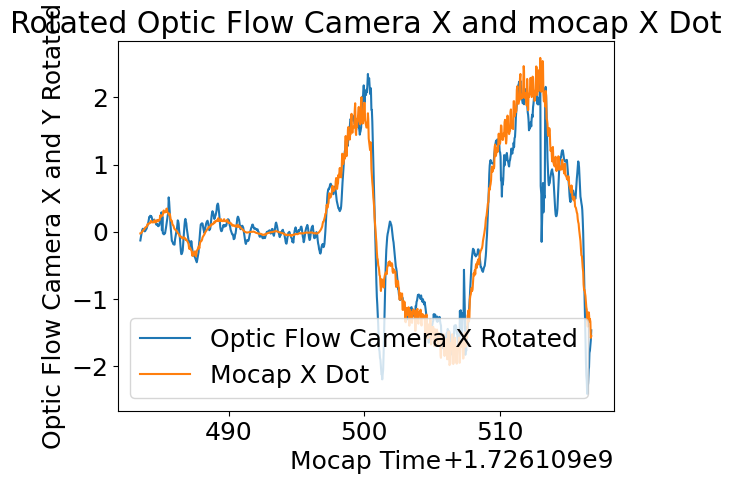

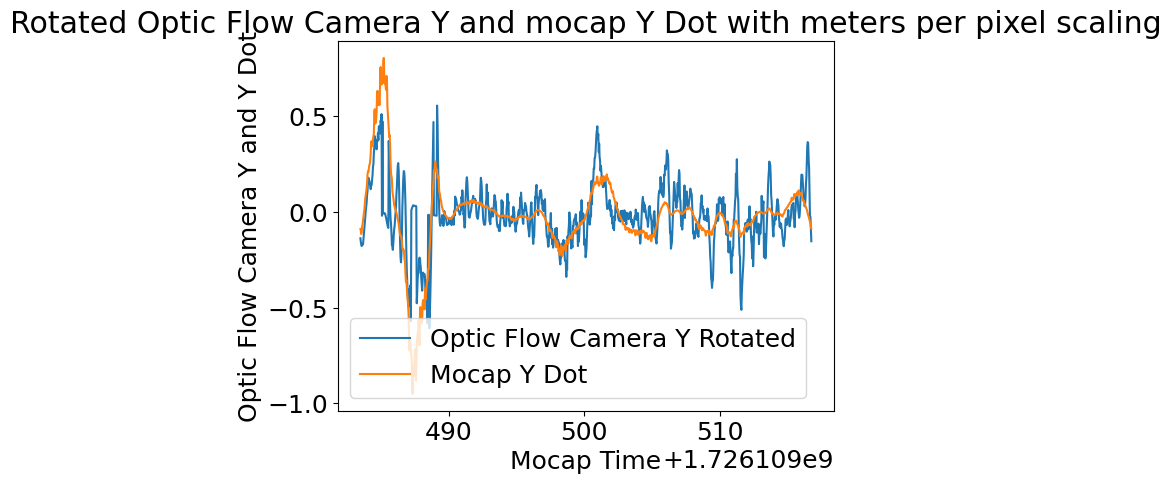

In [11]:
# Reshape the optic flow data to fit the linear regression model
OFX_rot_temp = np.array(OFX_rot).reshape(-1, 1)
OFY_rot_temp = np.array(OFY_rot)[:int(len(optic_flow_camera_x_mocap_interp)/4)].reshape(-1, 1)
print(len(OFY))
# Perform linear regression
modelX = LinearRegression()
modelX.fit(OFX_rot_temp, mocap_X_dot)

# The slope of the linear regression gives you the scalar (meters/pixel)
meters_per_pixel_X = modelX.coef_[0]

print(f"Scalar (meters/pixel) X: {meters_per_pixel_X}")

modelY = LinearRegression()
modelY.fit(OFY_rot_temp, mocap_Y_dot[:int(len(optic_flow_camera_x_mocap_interp)/4)])

# The slope of the linear regression gives you the scalar (meters/pixel)
meters_per_pixel_Y = modelY.coef_[0]

print(f"Scalar (meters/pixel) Y: {meters_per_pixel_Y}")

# Plot the rotated optic flow data
plt.plot(mocap_time[0:1000], np.multiply(OFX_rot,meters_per_pixel_X)[0:1000], label="Optic Flow Camera X Rotated")
plt.plot(mocap_time[0:1000],np.multiply(mocap_X_dot,1)[0:1000], label="Mocap X Dot")
# plt.plot(mocap_time, OFY_rot, label="Optic Flow Camera Y Rotated")
plt.title('Rotated Optic Flow Camera X and mocap X Dot')
plt.xlabel('Mocap Time')
plt.ylabel('Optic Flow Camera X and Y Rotated')
plt.legend()
plt.show()

plt.plot(mocap_time[0:1000], np.multiply(OFY_rot,meters_per_pixel_Y)[0:1000], label="Optic Flow Camera Y Rotated")
plt.plot(mocap_time[0:1000],np.multiply(mocap_Y_dot,1)[0:1000], label="Mocap Y Dot")
plt.title('Rotated Optic Flow Camera Y and mocap Y Dot with meters per pixel scaling')
plt.xlabel('Mocap Time')
plt.ylabel('Optic Flow Camera Y and Y Dot')
plt.legend()
plt.show()

## <center> Wind Sensor (Ultrasonic) <center>

In [12]:
data['trisonica']
# print columns of the trisonica data
for col in data['trisonica'].columns:
    print(col)

rosbagTimestamp
header
seq
stamp
secs
nsecs
frame_id
speed
speed2d
direction
northsouth
westeast
updown
temperature
pitch
roll
pressure
humidity
heading
levelx
levely
levelz


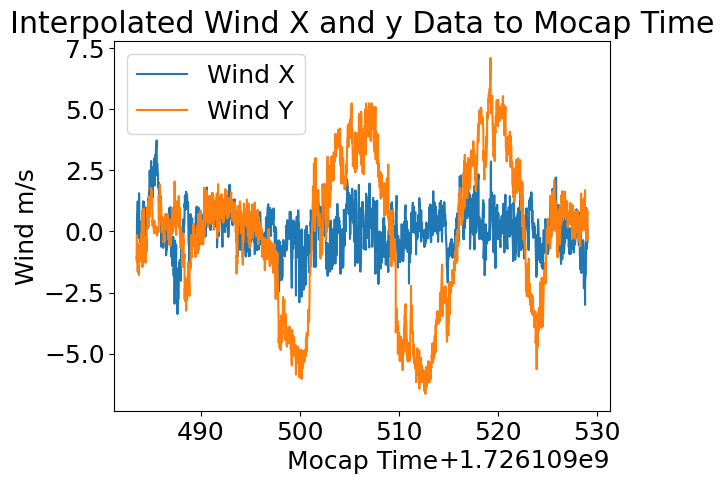

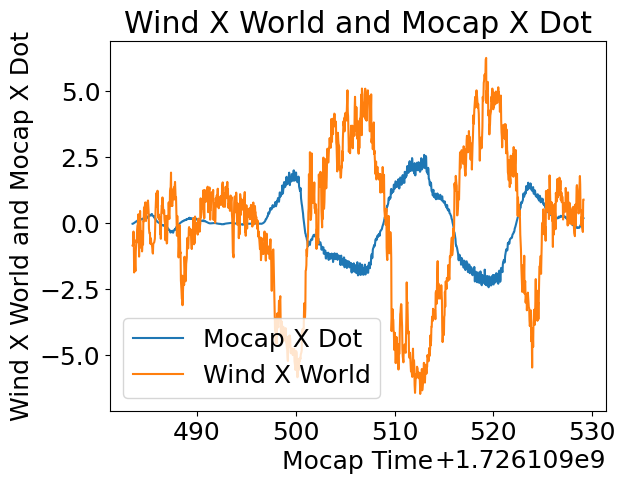

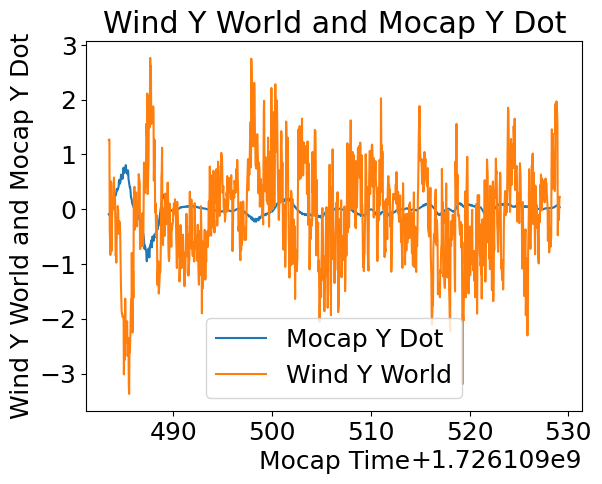

In [13]:
wind_time = data['trisonica']['rosbagTimestamp']/1e9
wind_x = data['trisonica']['westeast']
wind_y = -1*data['trisonica']['northsouth']

# interpolate wind data to mocap time
wind_x_mocap_interp = interpolate_data(wind_time, wind_x, mocap_time)
wind_y_mocap_interp = interpolate_data(wind_time, wind_y, mocap_time)

# Plot the interpolated data
plt.plot(wind_time, wind_x, label="Wind X")
plt.plot(wind_time, wind_y, label="Wind Y")
plt.title('Interpolated Wind X and y Data to Mocap Time')
plt.xlabel('Mocap Time')
plt.ylabel('Wind m/s')
plt.legend()
plt.show()



# bring the wind data to the global frame unpitch and unroll and unyaw
def rotate_wind_to_world_frame(wind_x, wind_y, roll, pitch, yaw):
    """
    Rotates the wind data from the body frame to the world frame.
    
    wind_x, wind_y: numpy arrays
        Arrays of wind velocity in the body frame along the x and y axes.
    roll, pitch, yaw: numpy arrays
        Arrays of roll, pitch, and yaw angles (in radians).
    
    Returns:
    wind_x_world, wind_y_world: numpy arrays
        Wind velocity in the world frame along the x and y axes.
    """
    # Initialize world-frame wind velocity arrays
    wind_x_world = np.zeros_like(wind_x)
    wind_y_world = np.zeros_like(wind_y)
    
    # Loop over each time step and rotate the wind velocity
    for i in range(len(wind_x)):
        # Get the rotation matrix for the current orientation (roll, pitch, yaw)
        R = rotation_matrix_from_euler(roll[i], pitch[i], yaw[i])
        
        # Measured wind velocity in body frame
        wind_body = np.array([wind_x[i], wind_y[i],0])
        
        # Rotate the body-frame wind velocity to the world frame
        wind_world = R @ wind_body
        
        # Store the world-frame wind velocity
        wind_x_world[i] = wind_world[0]
        wind_y_world[i] = wind_world[1]
    
    return wind_x_world, wind_y_world

# Rotate the wind data to the world frame
wind_x_world, wind_y_world = rotate_wind_to_world_frame(wind_x_mocap_interp, wind_y_mocap_interp, np.radians(mocap_Roll), np.radians(mocap_Pitch), np.radians(mocap_Yaw))

plt.plot(mocap_time, mocap_X_dot, label="Mocap X Dot")
plt.plot(mocap_time, wind_x_world, label="Wind X World")
plt.title('Wind X World and Mocap X Dot')
plt.xlabel('Mocap Time')
plt.ylabel('Wind X World and Mocap X Dot')
plt.legend()
plt.show()

plt.plot(mocap_time, mocap_Y_dot, label="Mocap Y Dot")
plt.plot(mocap_time, wind_y_world, label="Wind Y World")
plt.title('Wind Y World and Mocap Y Dot')
plt.xlabel('Mocap Time')
plt.ylabel('Wind Y World and Mocap Y Dot')
plt.legend()
plt.show()


Scalar (unitless) X: -0.3590088510163499
Scalar (unitless) Y: -0.22744219202271201


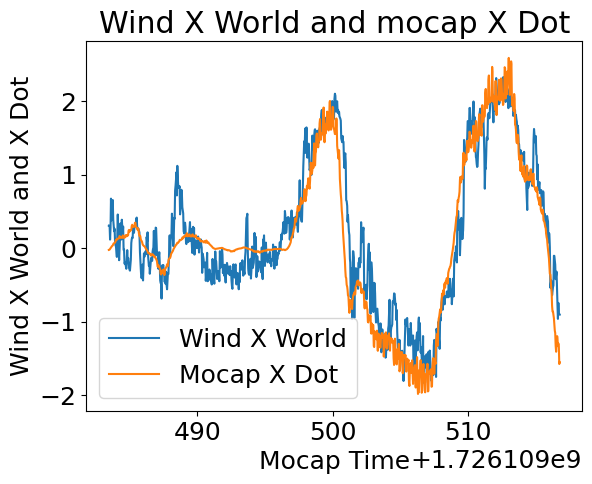

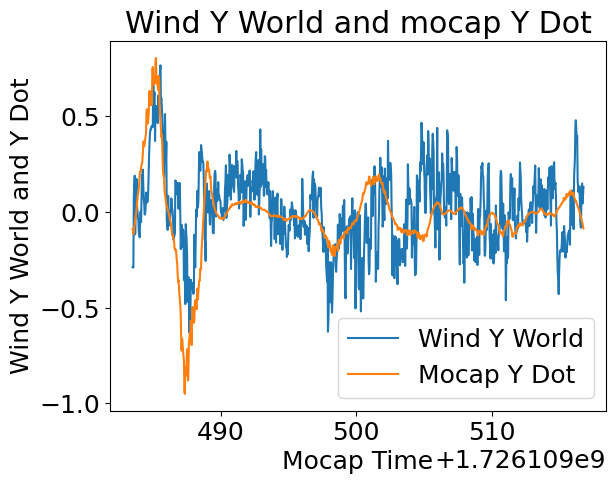

In [14]:
# Reshape the wind data to fit the linear regression model
wind_x_world_temp = np.array(wind_x_world).reshape(-1, 1)
wind_y_world_temp = np.array(wind_y_world)[:int(len(wind_x_world)/4)].reshape(-1, 1)

# Perform linear regression
modelX = LinearRegression()
modelX.fit(wind_x_world_temp, mocap_X_dot)

# The slope of the linear regression gives you the scalar unitless
Unit_X = modelX.coef_[0]

print(f"Scalar (unitless) X: {Unit_X}")

modelY = LinearRegression()
modelY.fit(wind_y_world_temp, mocap_Y_dot[:int(len(wind_x_world)/4)])

# The slope of the linear regression gives you the scalar unitless
Unit_Y = modelY.coef_[0]

print(f"Scalar (unitless) Y: {Unit_Y}")

# Plot the rotated wind data
plt.plot(mocap_time[0:1000], np.multiply(wind_x_world,Unit_X)[0:1000], label="Wind X World")
plt.plot(mocap_time[0:1000], mocap_X_dot[0:1000], label="Mocap X Dot")
plt.title('Wind X World and mocap X Dot')
plt.xlabel('Mocap Time')
plt.ylabel('Wind X World and X Dot')
plt.legend()
plt.show()

plt.plot(mocap_time[0:1000], np.multiply(wind_y_world,Unit_Y)[0:1000], label="Wind Y World")
plt.plot(mocap_time[0:1000], mocap_Y_dot[0:1000], label="Mocap Y Dot")
plt.title('Wind Y World and mocap Y Dot')
plt.xlabel('Mocap Time')
plt.ylabel('Wind Y World and Y Dot')
plt.legend()
plt.show()



# <center> RC Out ~ PWM <Center>

In [15]:
data['mavros/rc/out']
# split the data in header "channels" into individual columns named PWM1, PWM2, PWM3, PWM4 (only take the first 4 channels) each colum should be a float not a string
rc_time = data['mavros/rc/out']['rosbagTimestamp']/1e9
rc_channels = data['mavros/rc/out']['channels']
rc_channels = rc_channels.str.split(',', expand=True)
# remove "[" from the first column
rc_channels[0] = rc_channels[0].str.replace('[','')
rc_channels = rc_channels.iloc[:, :4]
rc_channels = rc_channels.astype(float)
PX4_1 = rc_channels[0]
PX4_2 = rc_channels[1]
PX4_3 = rc_channels[2]
PX4_4 = rc_channels[3]

## <center> Remap from PX4 motor layout to Dynamics motor layout <center>

<center>

PX4_1 ---> pwm_2 <br>
PX4_2 ---> pwm_4 <br>
PX4_3 ---> pwm_1 <br>
PX4_4 ---> pwm_3 <br>

<Center>

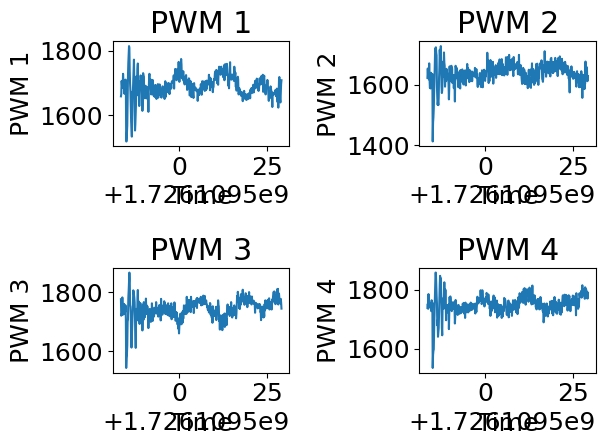

In [16]:
# pwm_1 = PX4_3
# pwm_2 = PX4_1
# pwm_3 = PX4_4
# pwm_4 = PX4_2

pwm_1 = PX4_1
pwm_2 = PX4_2
pwm_3 = PX4_3
pwm_4 = PX4_4
# 2x2 plot of the pwm data
plt.subplot(2, 2, 1)
plt.plot(rc_time, pwm_1)
plt.title('PWM 1')
plt.xlabel('Time')
plt.ylabel('PWM 1')

plt.subplot(2, 2, 2)
plt.plot(rc_time, pwm_2)
plt.title('PWM 2')
plt.xlabel('Time')
plt.ylabel('PWM 2')

plt.subplot(2, 2, 3)
plt.plot(rc_time, pwm_3)
plt.title('PWM 3')
plt.xlabel('Time')
plt.ylabel('PWM 3')

plt.subplot(2, 2, 4)
plt.plot(rc_time, pwm_4)
plt.title('PWM 4')
plt.xlabel('Time')
plt.ylabel('PWM 4')

plt.tight_layout()
plt.show()

In [17]:
print('pwm_1:', np.min(pwm_1),'pmw_2:', np.min(pwm_2),'pwm_3:', np.min(pwm_3),'pwm_4:', np.min(pwm_4))

pwm_1: 1519.0 pmw_2: 1412.0 pwm_3: 1544.0 pwm_4: 1534.0


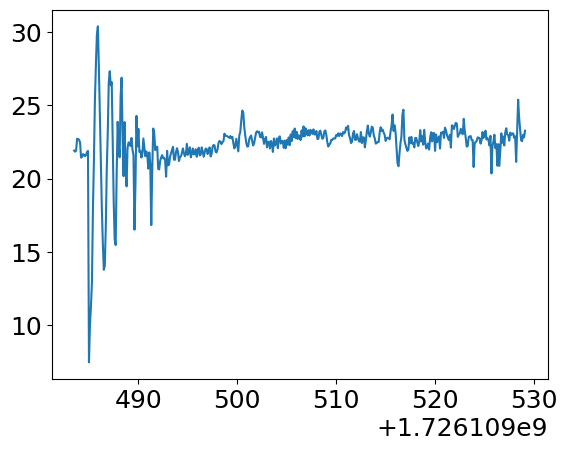

In [18]:
Real_b   = 1.8311
# BIGU=((pwm_1-1000)+(pwm_2-1000)+(pwm_3-1000)+(pwm_4-1000))*Real_b/100
BIGU=((pwm_1-1400)+(pwm_2-1400)+(pwm_3-1400)+(pwm_4-1400))*Real_b/100
plt.plot(rc_time, BIGU)

# <center> Get the final values for all measuered data <center>

## <center> Since Optic Flow is the fastes we will interpolate to that <center>

### <center> Mocap Final <center>

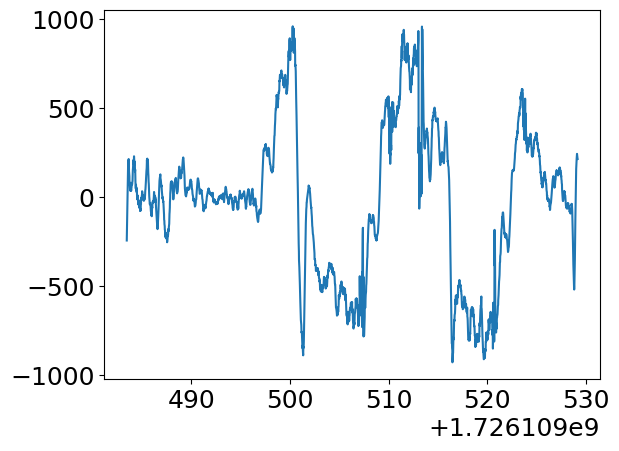

In [19]:
X_TRUE = interpolate_data(mocap_time, mocap_X, optic_flow_camera_x_time)
plt.plot(optic_flow_camera_x_time, optic_flow_camera_x)
X_DOT_TRUE = interpolate_data(mocap_time, mocap_X_dot, optic_flow_camera_x_time)
Y_TRUE = interpolate_data(mocap_time, mocap_Y, optic_flow_camera_x_time)
Y_DOT_TRUE = interpolate_data(mocap_time, mocap_Y_dot, optic_flow_camera_x_time)
Z_TRUE = interpolate_data(mocap_time, mocap_Z, optic_flow_camera_x_time)
Z_DOT_TRUE = interpolate_data(mocap_time, mocap_Z_dot, optic_flow_camera_x_time)
ROLL_TRUE = np.radians(interpolate_data(mocap_time, mocap_Roll, optic_flow_camera_x_time))
PITCH_TRUE = np.radians(interpolate_data(mocap_time, mocap_Pitch, optic_flow_camera_x_time))
YAW_TRUE = np.radians(interpolate_data(mocap_time, mocap_Yaw, optic_flow_camera_x_time))



### <center> IMU Final <center>

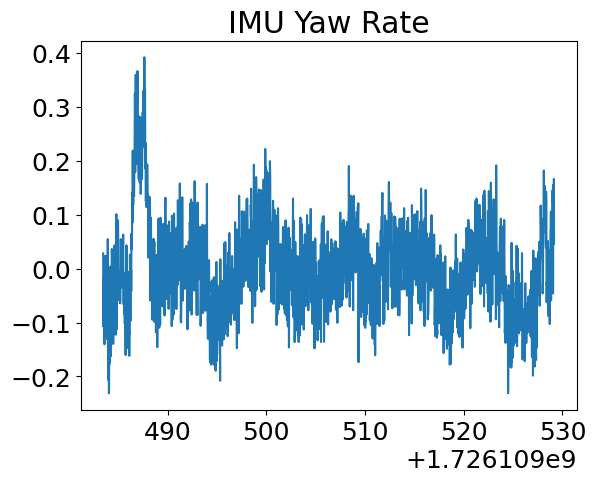

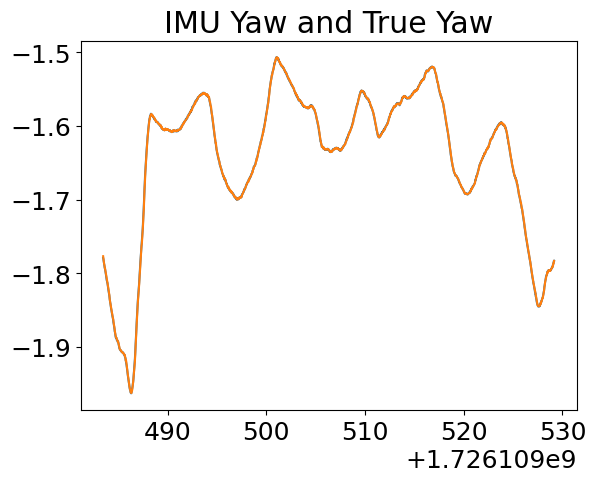

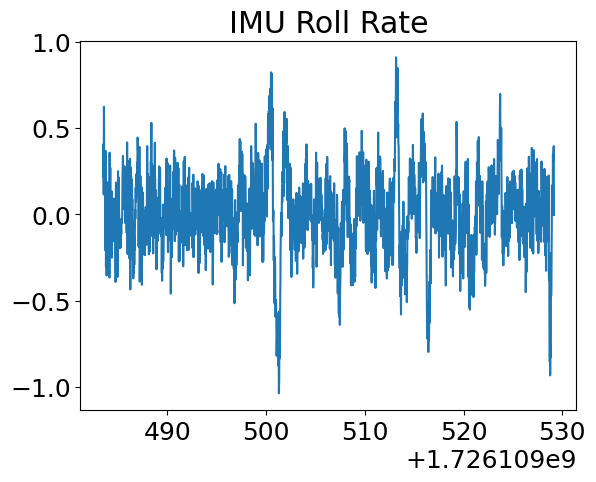

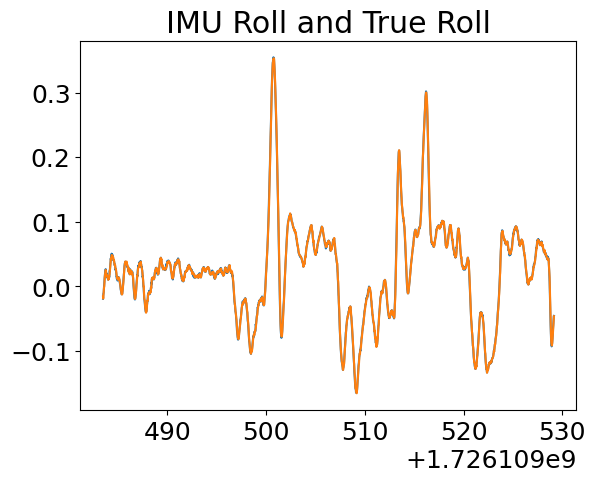

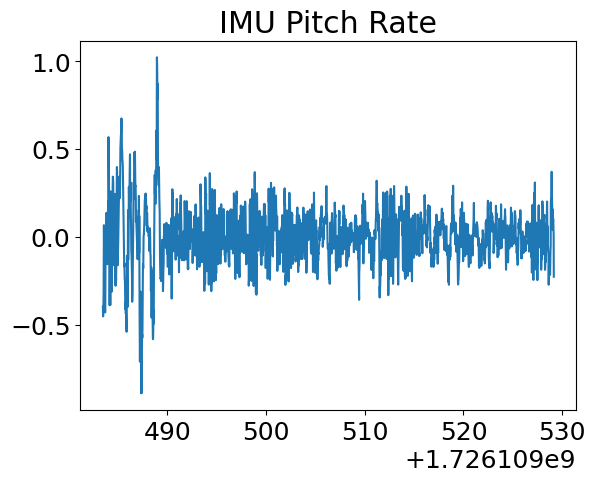

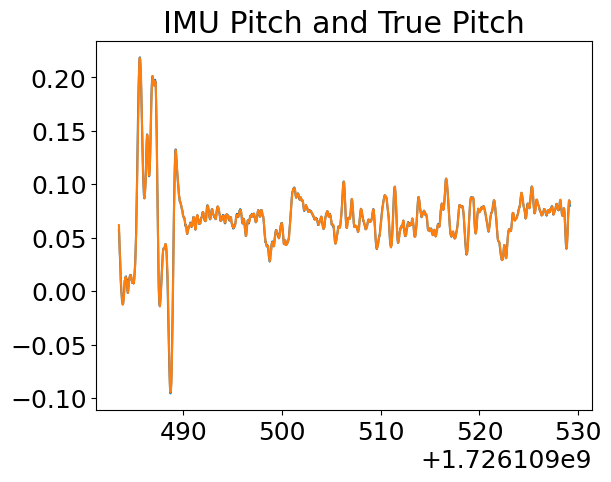

In [20]:
IMU_ROLL = interpolate_data(imu_time, imu_Roll, optic_flow_camera_x_time)
IMU_PITCH = interpolate_data(imu_time, imu_Pitch, optic_flow_camera_x_time)
IMU_YAW = interpolate_data(imu_time, imu_Yaw, optic_flow_camera_x_time)
IMU_ROLL_RATE = interpolate_data(imu_time, imu_Roll_rate, optic_flow_camera_x_time)
IMU_PITCH_RATE = interpolate_data(imu_time, imu_Pitch_rate, optic_flow_camera_x_time)
IMU_YAW_RATE = interpolate_data(imu_time, imu_Yaw_rate, optic_flow_camera_x_time)
IMU_ACC_X = interpolate_data(imu_time, imu_acc_x_corrected_world, optic_flow_camera_x_time)
IMU_ACC_Y = interpolate_data(imu_time, imu_acc_y_corrected_world, optic_flow_camera_x_time)
IMU_ACC_Z = interpolate_data(imu_time, imu_acc_z_corrected_world, optic_flow_camera_x_time)

plt.plot(optic_flow_camera_x_time, IMU_YAW_RATE)
plt.title('IMU Yaw Rate')
plt.show()

plt.plot(optic_flow_camera_x_time, IMU_YAW)
plt.plot(optic_flow_camera_x_time, YAW_TRUE)
plt.title('IMU Yaw and True Yaw')
plt.show()

plt.plot(optic_flow_camera_x_time, IMU_ROLL_RATE)
plt.title('IMU Roll Rate')
plt.show()

plt.plot(optic_flow_camera_x_time, IMU_ROLL)
plt.plot(optic_flow_camera_x_time, ROLL_TRUE)
plt.title('IMU Roll and True Roll')
plt.show()

plt.plot(optic_flow_camera_x_time, IMU_PITCH_RATE)
plt.title('IMU Pitch Rate')
plt.show()

plt.plot(optic_flow_camera_x_time, IMU_PITCH)
plt.plot(optic_flow_camera_x_time, PITCH_TRUE)
plt.title('IMU Pitch and True Pitch')
plt.show()


### <center> Wind Sensor Final <center>

In [21]:
WIND_X = interpolate_data(mocap_time, wind_x_world, optic_flow_camera_x_time)
WIND_Y = interpolate_data(mocap_time, wind_y_world, optic_flow_camera_x_time)
WIND_X_f = 1*Unit_X
WIND_Y_f = 1*Unit_Y
WIND_Z_f = 1

### <center> Optic Flow <center>

In [22]:
OF_X, OF_Y = rotate_optic_flow(optic_flow_camera_x, optic_flow_camera_y, IMU_YAW)
OF_X_f=1*meters_per_pixel_X
OF_Y_f=1*meters_per_pixel_Y
OF_Z_f=1

### <center> PWM Final <center>

In [23]:
PWM_1 = (interpolate_data(rc_time, pwm_1, optic_flow_camera_x_time)-1150)/1000*9.81
PWM_2 = (interpolate_data(rc_time, pwm_2, optic_flow_camera_x_time)-1150)/1000*9.81
PWM_3 = (interpolate_data(rc_time, pwm_3, optic_flow_camera_x_time)-1150)/1000*9.81
PWM_4 = (interpolate_data(rc_time, pwm_4, optic_flow_camera_x_time)-1150)/1000*9.81

### <center> Time <center>

In [24]:
TIME = optic_flow_camera_x_time-optic_flow_camera_x_time[0]
DT=np.round(TIME[1]-TIME[0],2)
print(DT)

0.01


In [85]:
def high_pass_filter(data, dt, cut_off_freq):
    # Create the high pass filter
    b, a = signal.butter(1, cut_off_freq, 'high', fs=1/dt)
    
    # Apply the high pass filter
    data_filtered = signal.filtfilt(b, a, data)
    
    return data_filtered

def low_pass_filter(data, dt, cut_off_freq):
    # Create the high pass filter
    b, a = signal.butter(1, cut_off_freq, 'low', fs=1/dt)
    
    # Apply the high pass filter
    data_filtered = signal.filtfilt(b, a, data)
    
    return data_filtered

### <center> Double checking <center>

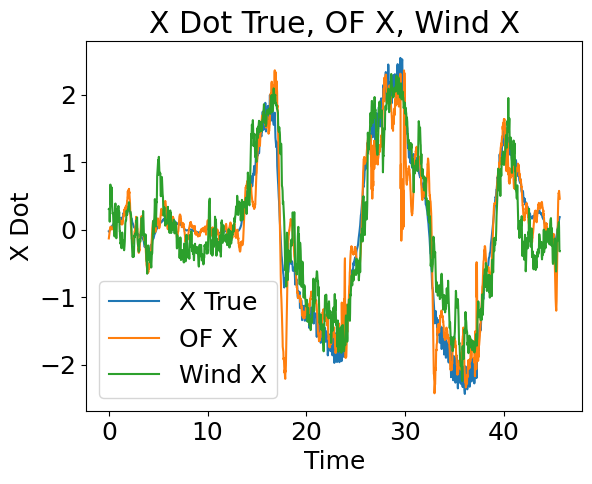

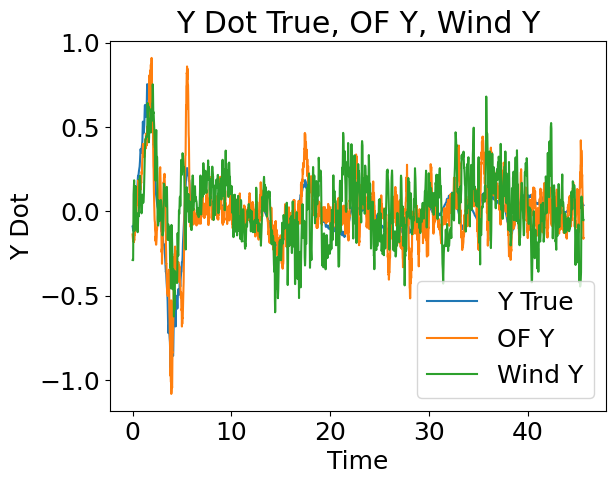

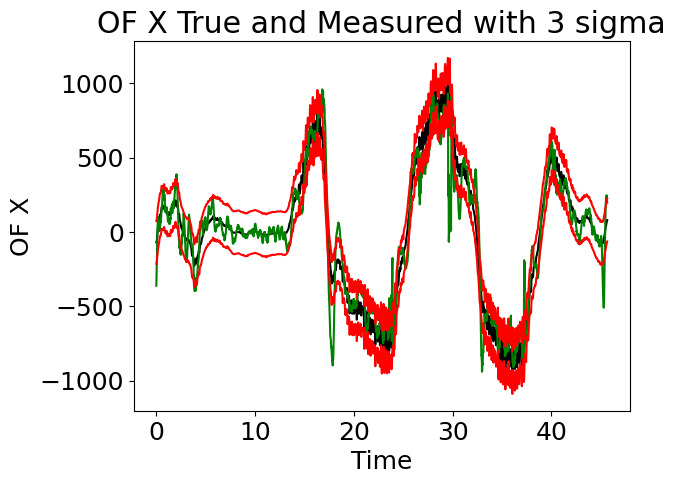

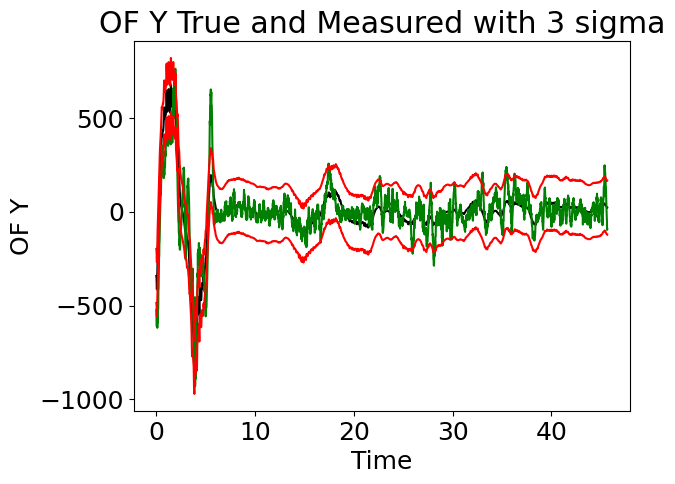

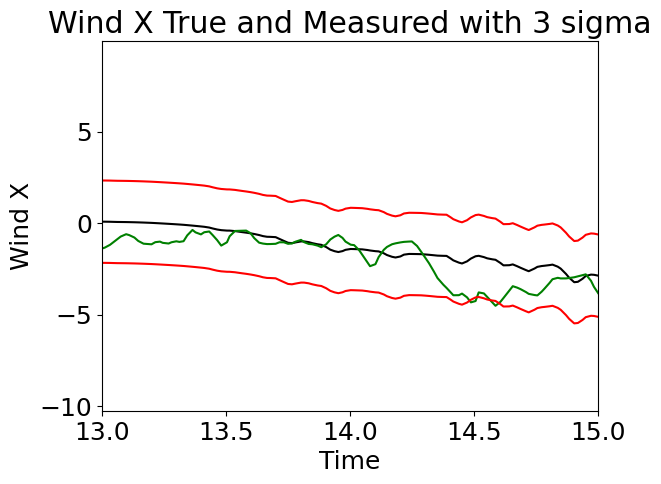

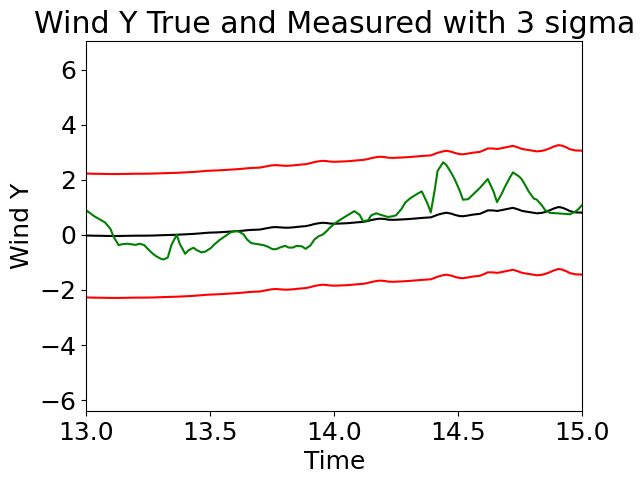

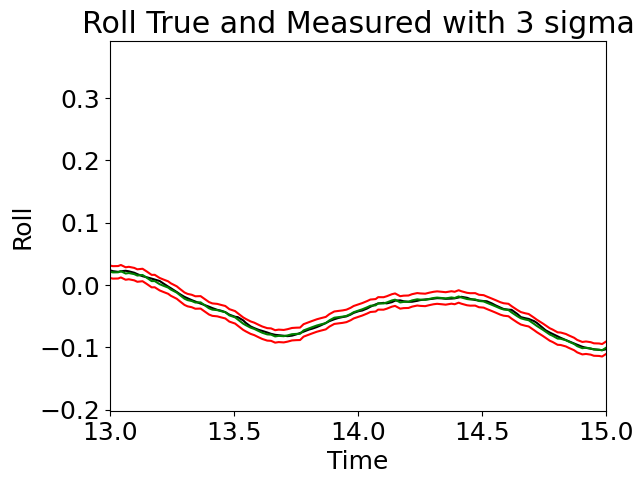

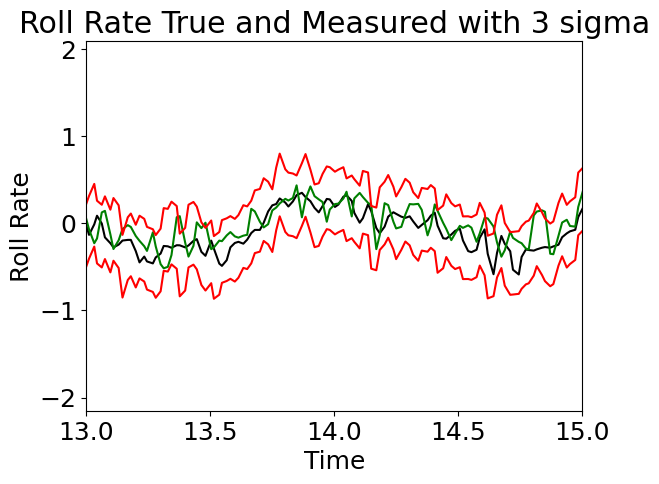

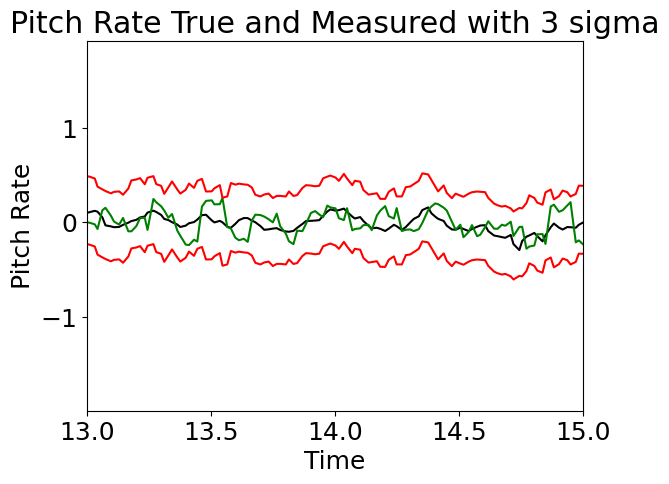

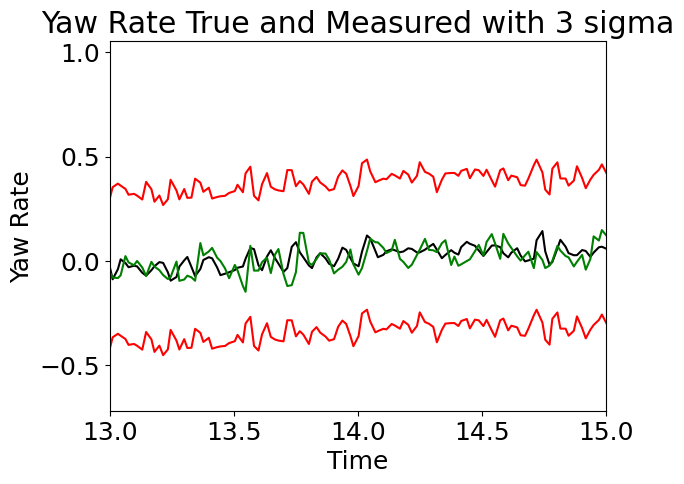

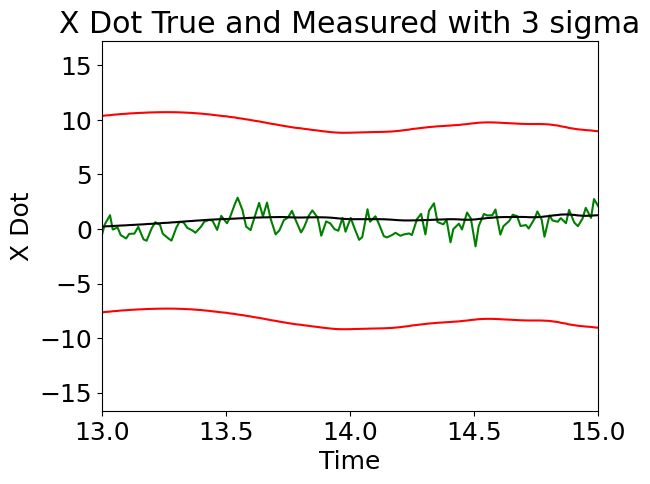

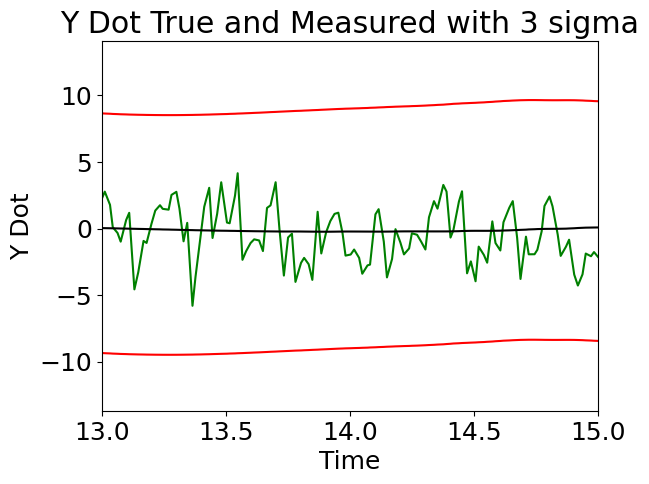

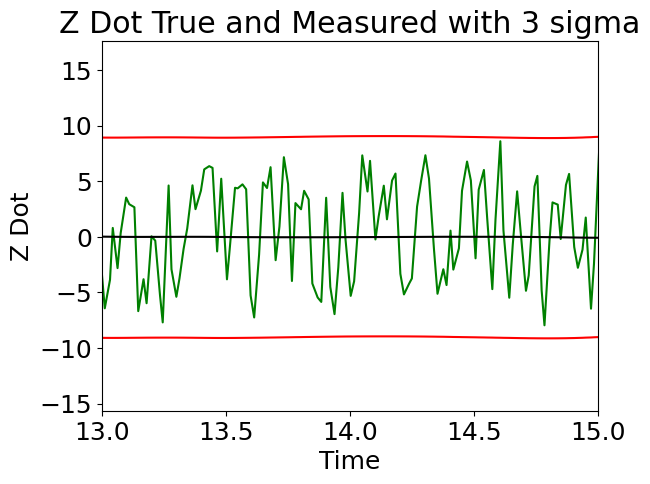

In [522]:
# plot mocap x and optic flow x and wind x
plt.plot(TIME, X_DOT_TRUE, label="X True")
# vx=of_x*of_x_f*z
plt.plot(TIME, np.multiply(np.multiply(OF_X,OF_X_f),Z_TRUE), label="OF X")
plt.plot(TIME, np.multiply(WIND_X,WIND_X_f), label="Wind X")
plt.title('X Dot True, OF X, Wind X')
plt.xlabel('Time')
plt.ylabel('X Dot')
plt.legend()
plt.show()

#plot mocap y and optic flow y and wind y
plt.plot(TIME, Y_DOT_TRUE, label="Y True")
# vy=of_y*of_y_f*z
plt.plot(TIME, np.multiply(np.multiply(OF_Y,OF_Y_f),Z_TRUE), label="OF Y")
plt.plot(TIME, np.multiply(WIND_Y,WIND_Y_f), label="Wind Y")
plt.title('Y Dot True, OF Y, Wind Y')
plt.xlabel('Time')
plt.ylabel('Y Dot')
plt.legend()
plt.show()

# plot 3 sigma
r=12
R = r**2

r_wind=1.5
R_wind = r_wind**2

r_imu = 0.1
R_imu = r_imu**2

r_imu_rate = 0.6
R_imu_rate = r_imu_rate**2

r_acc =3
R_acc = r_acc**2

OFX_true = np.divide(np.divide(X_DOT_TRUE,OF_X_f),Z_TRUE)
OFY_true = np.divide(np.divide(Y_DOT_TRUE,OF_Y_f),Z_TRUE)

#3 sigma for OFX using R 
OFX_P=OFX_true+R
OFX_M=OFX_true-R
OFY_P=OFY_true+R
OFY_M=OFY_true-R

IMU_ROLL_P = IMU_ROLL + R_imu
IMU_ROLL_M = IMU_ROLL - R_imu
IMU_PITCH_P = IMU_PITCH + R_imu
IMU_PITCH_M = IMU_PITCH - R_imu
IMU_YAW_P = IMU_YAW + R_imu
IMU_YAW_M = IMU_YAW - R_imu

# get gradient of IMU RPY to get the rate and use that to get 3 sigma
IMU_ROLL_RATE_P = np.gradient(IMU_ROLL_P,DT)+R_imu_rate
IMU_ROLL_RATE_M = np.gradient(IMU_ROLL_M,DT)-R_imu_rate
IMU_PITCH_RATE_P = np.gradient(IMU_PITCH_P,DT)+R_imu_rate
IMU_PITCH_RATE_M = np.gradient(IMU_PITCH_M,DT)-R_imu_rate
IMU_YAW_RATE_P = np.gradient(IMU_YAW_P,DT)+R_imu_rate
IMU_YAW_RATE_M = np.gradient(IMU_YAW_M,DT)-R_imu_rate

# get the real value for acc using gradient of the x and y dot true data
## low pass np.gradient(X_DOT_TRUE,DT), np.gradient(Y_DOT_TRUE,DT), np.gradient(Z_DOT_TRUE,DT)
ACC_X_filt = low_pass_filter(np.gradient(X_DOT_TRUE,DT), DT, 1)
ACC_Y_filt = low_pass_filter(np.gradient(Y_DOT_TRUE,DT), DT, 1)
ACC_Z_filt = low_pass_filter(np.gradient(Z_DOT_TRUE,DT), DT, 1)

IMU_ACC_X_P = np.gradient(ACC_X_filt,DT)+R_acc
IMU_ACC_X_M = np.gradient(ACC_X_filt,DT)-R_acc
IMU_ACC_Y_P = np.gradient(ACC_Y_filt,DT)+R_acc
IMU_ACC_Y_M = np.gradient(ACC_Y_filt,DT)-R_acc
IMU_ACC_Z_P = np.gradient(ACC_Z_filt,DT)+R_acc
IMU_ACC_Z_M = np.gradient(ACC_Z_filt,DT)-R_acc
## low pass filter the data
IMU_ACC_X_P = low_pass_filter(IMU_ACC_X_P, DT, 1)
IMU_ACC_X_M = low_pass_filter(IMU_ACC_X_M, DT, 1)
IMU_ACC_Y_P = low_pass_filter(IMU_ACC_Y_P, DT, 1)
IMU_ACC_Y_M = low_pass_filter(IMU_ACC_Y_M, DT, 1)
IMU_ACC_Z_P = low_pass_filter(IMU_ACC_Z_P, DT, 1)
IMU_ACC_Z_M = low_pass_filter(IMU_ACC_Z_M, DT, 1)



# 3 sigma for wind using R_wind and X_DOT_TRUE and Y_DOT_TRUE
WIND_X_P = (X_DOT_TRUE)/WIND_X_f + R_wind
WIND_X_M = (X_DOT_TRUE)/WIND_X_f - R_wind
WIND_Y_P = (Y_DOT_TRUE)/WIND_Y_f + R_wind
WIND_Y_M = (Y_DOT_TRUE)/WIND_Y_f - R_wind
plt.rcParams.update({'font.size': 18})
# plot 3 sigma for OFX
plt.plot(TIME, OFX_true, label="OF X True", color='black')
plt.plot(TIME, OF_X, label="OF X measured", color='green')
plt.plot(TIME, OFX_P, label="OF X True + 3 sigma", color='red')
plt.plot(TIME, OFX_M, label="OF X True - 3 sigma", color='red')
plt.title('OF X True and Measured with 3 sigma')
plt.xlabel('Time')
plt.ylabel('OF X')
# plt.xlim([13,13.1])
# plt.ylim([-12,-9])
# plt.legend()
plt.show()

# plot 3 sigma for OFY
plt.plot(TIME, OFY_true, label="OF Y True", color='black')
plt.plot(TIME, OF_Y, label="OF Y measured", color='green')
plt.plot(TIME, OFY_P, label="OF Y True + 3 sigma", color='red')
plt.plot(TIME, OFY_M, label="OF Y True - 3 sigma", color='red')
plt.title('OF Y True and Measured with 3 sigma')
plt.xlabel('Time')
plt.ylabel('OF Y')
# plt.legend()
# plt.xlim([13,15])
plt.show()


# plot 3 sigma for wind
plt.plot(TIME, X_DOT_TRUE/WIND_X_f, label="X True", color='black')
plt.plot(TIME, WIND_X, label="Wind X measured", color='green')
plt.plot(TIME, WIND_X_P, label="Wind X measured + 3 sigma", color='red')
plt.plot(TIME, WIND_X_M, label="Wind X measured - 3 sigma", color='red')
plt.title('Wind X True and Measured with 3 sigma')
plt.xlabel('Time')
plt.ylabel('Wind X')
# plt.legend()
plt.xlim([13,15])
plt.show()

# plot 3 sigma for wind
plt.plot(TIME, Y_DOT_TRUE/WIND_Y_f, label="Y True", color='black')
plt.plot(TIME, WIND_Y, label="Wind Y measured", color='green')
plt.plot(TIME, WIND_Y_P, label="Wind Y measured + 3 sigma", color='red')
plt.plot(TIME, WIND_Y_M, label="Wind Y measured - 3 sigma", color='red')
plt.title('Wind Y True and Measured with 3 sigma')
plt.xlabel('Time')
plt.ylabel('Wind Y')
# plt.legend()
plt.xlim([13,15])
plt.show()

# plot 3 sigma for IMU RPY
plt.plot(TIME, ROLL_TRUE, label="Roll True", color='black')
plt.plot(TIME, IMU_ROLL, label="Roll measured", color='green')
plt.plot(TIME, IMU_ROLL_P, label="Roll measured + 3 sigma", color='red')
plt.plot(TIME, IMU_ROLL_M, label="Roll measured - 3 sigma", color='red')
plt.title('Roll True and Measured with 3 sigma')
plt.xlabel('Time')
plt.ylabel('Roll')
plt.xlim([0,.1])
# plt.legend()
plt.xlim([13,15])
plt.show()

# plot 3 sigma for IMU RPY rate
plt.plot(TIME, np.gradient(ROLL_TRUE,DT), label="Roll Rate True", color='black')
plt.plot(TIME, IMU_ROLL_RATE, label="Roll Rate measured", color='green')
plt.plot(TIME, IMU_ROLL_RATE_P, label="Roll Rate measured + 3 sigma", color='red')
plt.plot(TIME, IMU_ROLL_RATE_M, label="Roll Rate measured - 3 sigma", color='red')
plt.title('Roll Rate True and Measured with 3 sigma')
plt.xlabel('Time')
plt.ylabel('Roll Rate')
plt.xlim([0,10])
# plt.legend()
plt.xlim([13,15])
plt.show()

plt.plot(TIME, np.gradient(PITCH_TRUE,DT), label="Pitch Rate True", color='black')
plt.plot(TIME, IMU_PITCH_RATE, label="Pitch Rate measured", color='green')
plt.plot(TIME, IMU_PITCH_RATE_P, label="Pitch Rate measured + 3 sigma", color='red')
plt.plot(TIME, IMU_PITCH_RATE_M, label="Pitch Rate measured - 3 sigma", color='red')
plt.title('Pitch Rate True and Measured with 3 sigma')
plt.xlabel('Time')
plt.ylabel('Pitch Rate')
plt.xlim([0,10])
# plt.legend()
plt.xlim([13,15])
plt.show()

plt.plot(TIME, np.gradient(YAW_TRUE,DT), label="Yaw Rate True", color='black')
plt.plot(TIME, IMU_YAW_RATE, label="Yaw Rate measured", color='green')
plt.plot(TIME, IMU_YAW_RATE_P, label="Yaw Rate measured + 3 sigma", color='red')
plt.plot(TIME, IMU_YAW_RATE_M, label="Yaw Rate measured - 3 sigma", color='red')
plt.title('Yaw Rate True and Measured with 3 sigma')
plt.xlabel('Time')
plt.ylabel('Yaw Rate')
plt.xlim([0,10])
# plt.legend()
plt.xlim([13,15])
plt.show()

# plot 3 sigma for IMU ACC

plt.plot(TIME, IMU_ACC_X, label="X Dot measured", color='green')
plt.plot(TIME, ACC_X_filt, label="X Dot True", color='black')
plt.plot(TIME, IMU_ACC_X_P, label="X Dot measured + 3 sigma", color='red')
plt.plot(TIME, IMU_ACC_X_M, label="X Dot measured - 3 sigma", color='red')
plt.title('X Dot True and Measured with 3 sigma')
plt.xlabel('Time')
plt.ylabel('X Dot')
# plt.xlim([0,10])
# plt.legend()
plt.xlim([13,15])
plt.show()


plt.plot(TIME, IMU_ACC_Y, label="Y Dot measured", color='green')
plt.plot(TIME, ACC_Y_filt, label="Y Dot True", color='black')
plt.plot(TIME, IMU_ACC_Y_P, label="Y Dot measured + 3 sigma", color='red')
plt.plot(TIME, IMU_ACC_Y_M, label="Y Dot measured - 3 sigma", color='red')
plt.title('Y Dot True and Measured with 3 sigma')
plt.xlabel('Time')
plt.ylabel('Y Dot')
# plt.xlim([0,10])
# plt.legend()
plt.xlim([13,15])
plt.show()


plt.plot(TIME, IMU_ACC_Z, label="Z Dot measured", color='green')
plt.plot(TIME, ACC_Z_filt, label="Z Dot True", color='black')
plt.plot(TIME, IMU_ACC_Z_P, label="Z Dot measured + 3 sigma", color='red')
plt.plot(TIME, IMU_ACC_Z_M, label="Z Dot measured - 3 sigma", color='red')
plt.title('Z Dot True and Measured with 3 sigma')
plt.xlabel('Time')
plt.ylabel('Z Dot')
# plt.xlim([0,10])
# plt.legend()
plt.xlim([13,15])
plt.show()



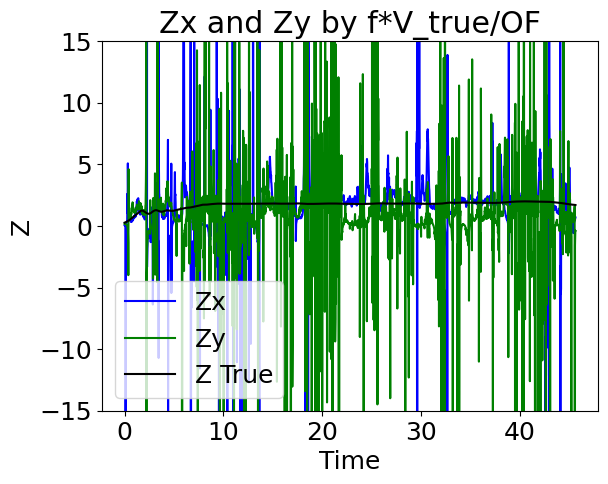

In [701]:
# calculate Z based on the optic flow data get Zx, Zy and Z that is the average of the 2
plt.rcParams.update({'font.size': 18})
Zx = np.divide(np.divide(X_DOT_TRUE,OF_X_f),OF_X)
Zy = np.divide(np.divide(Y_DOT_TRUE,OF_Y_f),OF_Y)
Z_avg = (Zx+Zy)/2
# calculate Z with (Vx/fx + Vy/fy)/(OFx + OFy)
Z_test = np.divide(np.divide(X_DOT_TRUE,OF_X_f)+np.divide(Y_DOT_TRUE,OF_Y_f),OF_X+OF_Y)

# plot all the Z data to see which one is the best and compare it to the true Z

plt.plot(TIME, Zx, label="Zx", color='blue')
plt.plot(TIME, Zy, label="Zy", color='green')
# plt.plot(TIME, Z_avg, label="Z Avg", color='purple')
# plt.plot(TIME, Z_test, label="Z Test", color='red')
plt.plot(TIME, Z_TRUE, label="Z True", color='black')
plt.title('Zx and Zy by f*V_true/OF')
plt.xlabel('Time')
plt.ylabel('Z')
plt.ylim([-15,15])
plt.legend()
plt.show()


# <center> Real Drone Parameters <center>

In [26]:
########################################################################################
#################### Real Drone Parameters #############################################
########################################################################################
Real_m   = 0.086  # [kg] mass
Real_M   = 2.529  # [kg] mass
Real_mM  = Real_M+4*Real_m  # [kg] mass (total=2.529+4*0.086=2.897)
Real_l   = 0.2032 # [m] length
Real_r   = 0.1778 # [m] average body radius
Real_Ix  = 2*(Real_M*Real_r**2)/5 + 2*Real_m*Real_l**2 # [kg*m^2] moment of inertia
Real_Iy  = 2*(Real_M*Real_r**2)/5 + 2*Real_m*Real_l**2 # [kg*m^2] moment of inertia
Real_Iz  = 2*(Real_M*Real_r**2)/5 + 4*Real_m*Real_l**2 # [kg*m^2] moment of inertia
Real_Jr  = 2*(Real_M*Real_r**2)/5 # [kg*m^2] polar moment of inertia ### FAKE VALUE
Real_b   = 1.8311 # thrust coefficient
Real_d   = 0.01 # drag coefficient
Real_Dl  = 0.1 # drag coefficient from ground speed plus air speed
Real_Dr  = 0.1 # drag coefficient from rotation speed

print('Real Drone Parameters:')
print('Real_m:       ', Real_m)
print('Real_M:       ', Real_M)
print('Real_M_total: ', Real_mM)
print('Real_l:       ', Real_l)
print('Real_r:       ', Real_r)
print('Real_Ix:      ', Real_Ix)
print('Real_Iy:      ', Real_Iy)
print('Real_Iz:      ', Real_Iz)
print('Real_Jr:      ', Real_Jr)
print('Real_b:       ', Real_b)
print('Real_d:       ', Real_d)
print('Real_Dl:      ', Real_Dl)
print('Real_Dr:      ', Real_Dr)


# params = [m,l,Ix,Iy,Iz,Jr,b,d,Dl,Dr]
params = [Real_mM,Real_l,Real_Ix,Real_Iy,Real_Iz,Real_Jr,Real_b,Real_d,Real_Dl,Real_Dr]
g  = 9.81 # m/s^2

Real Drone Parameters:
Real_m:        0.086
Real_M:        2.529
Real_M_total:  2.8729999999999998
Real_l:        0.2032
Real_r:        0.1778
Real_Ix:       0.039081470224
Real_Iy:       0.039081470224
Real_Iz:       0.046183391504
Real_Jr:       0.031979548944
Real_b:        1.8311
Real_d:        0.01
Real_Dl:       0.1
Real_Dr:       0.1


In [483]:
def f_d(X, U):
    # Extract state variables
    x, vx, y, vy, z, vz, phi, dphi, theta, dtheta, psi, dpsi, wx, wy, wz = np.ravel(X)
    
    # Extract control inputs
    PWM1, PWM2, PWM3, PWM4 = np.ravel(U)
    
    # Compute intermediate variables
    U1 = Real_b * (PWM1 + PWM2 + PWM3 + PWM4)
    U2 = Real_b * (PWM4 + PWM1 - PWM2 - PWM3)
    U3 = Real_b * (PWM3 + PWM4 - PWM1 - PWM2)
    U4 = Real_d * (-PWM1 + PWM2 - PWM3 + PWM4)
    Omega = PWM2**(1/2) + PWM4**(1/2) - PWM1**(1/2) - PWM3**(1/2)

    # define drag dynamics
    vrx = vx + wx
    vry = vy + wy
    vrz = vz + wz
    dt=DT
    new_x=x + vx * dt
    new_vx = vx+(1/Real_mM) * (np.cos(phi) * np.sin(theta) * np.cos(psi) + np.sin(phi) * np.sin(psi)) * U1 - (Real_Dl * vrx / Real_mM) * dt
    new_y = y + vy * dt
    new_vy = vy+(1/Real_mM) * (np.cos(phi) * np.sin(theta) * np.sin(psi) - np.sin(phi) * np.cos(psi)) * U1 - (Real_Dl * vry / Real_mM) * dt
    new_z = z + vz * dt
    new_vz = vz+(1/Real_mM) * (np.cos(phi) * np.cos(theta)) * U1 - g - (Real_Dl * vrz / Real_mM) * dt
    new_phi = phi + dphi * dt
    new_dphi = dphi+dtheta * dpsi * (Real_Iy - Real_Iz) / Real_Ix - (Real_Jr * dtheta * Omega / Real_Ix) + (U2 * Real_l / Real_Ix) - (Real_Dr * dphi / Real_Ix) * dt
    new_theta = theta + dtheta * dt
    new_dtheta = dtheta+dphi * dpsi * (Real_Iz - Real_Ix) / Real_Iy + (Real_Jr * dphi * Omega / Real_Iy) + (U3 * Real_l / Real_Iy) - (Real_Dr * dtheta / Real_Iy) * dt
    new_psi = psi + dpsi * dt
    new_dpsi = dpsi+dphi * dtheta * (Real_Ix - Real_Iy) / Real_Iz + (U4 / Real_Iz) - (Real_Dr * dpsi / Real_Iz) * dt
    new_wx = 0
    new_wy = 0
    new_wz = 0
    
    new_X = np.atleast_2d(np.array([new_x, new_vx, new_y, new_vy, new_z, new_vz, new_phi, new_dphi, new_theta, new_dtheta, new_psi, new_dpsi,new_wx,new_wy,new_wz])).T

    return new_X

# write function as a continuous time function
Tr=.6
Tp=.2
def f_c(X, U):
    # Extract state variables
    x, vx, y, vy, z, vz, phi, dphi, theta, dtheta, psi, dpsi, wx, wy, wz = np.ravel(X)
    
    # Extract control inputs
    PWM1, PWM2, PWM3, PWM4 = np.ravel(U)
    
    # Compute intermediate variables
    # U1 = Real_b * (PWM1 + PWM2 + PWM3 + PWM4)
    # U2 = Real_b * (PWM4 + PWM1 - PWM2 - PWM3)
    # U3 = Real_b * (PWM3 + PWM4 - PWM1 - PWM2)
    # U4 = Real_d * (-PWM1 + PWM2 - PWM3 + PWM4)
    # Omega = PWM2**(1/2) + PWM4**(1/2) - PWM1**(1/2) - PWM3**(1/2)
    U1 = Real_b * ( PWM1 + PWM2 + PWM3 + PWM4)
    U2 = Real_b * (-PWM4 + PWM1 + PWM2 - PWM3)
    U3 = Real_b * (-PWM3 + PWM4 - PWM1 + PWM2)
    U4 = Real_d * (-PWM1 - PWM2 + PWM3 + PWM4)
    Omega = PWM1**(1/2) + PWM2**(1/2) - PWM3**(1/2) - PWM4**(1/2)
    

    # define drag dynamics
    vrx = vx + wx
    vry = vy + wy
    vrz = vz + wz
    
    # dt
    dt=DT

    #apply a torque to roll and pitch mased on offset from the center of the drone. Tr and Tp are the torques
    Tr
    Tp


    # define the continuous time dynamics
    dxdt=vx
    dvxdt = (1/Real_mM) * (np.cos(phi) * np.sin(theta) * np.cos(psi) + np.sin(phi) * np.sin(psi)) * U1 - (Real_Dl * vrx / Real_mM)
    dydt=vy
    dvydt = (1/Real_mM) * (np.cos(phi) * np.sin(theta) * np.sin(psi) - np.sin(phi) * np.cos(psi)) * U1 - (Real_Dl * vry / Real_mM)
    dzdt=vz
    dvzdt = (1/Real_mM) * (np.cos(phi) * np.cos(theta)) * U1 - g - (Real_Dl * vrz / Real_mM)
    dphidt=dphi
    ddphidt = dtheta * dpsi * (Real_Iy - Real_Iz) / Real_Ix - (Real_Jr * dtheta * Omega / Real_Ix) + (U2 * Real_l / Real_Ix) - (Real_Dr * dphi / Real_Ix) + Tr/Real_Ix
    dthetadt= dtheta
    ddthetadt = dphi * dpsi * (Real_Iz - Real_Ix) / Real_Iy + (Real_Jr * dphi * Omega / Real_Iy) + (U3 * Real_l / Real_Iy) - (Real_Dr * dtheta / Real_Iy) + Tp/Real_Iy
    dpsidt= dpsi
    ddpsidt = dphi * dtheta * (Real_Ix - Real_Iy) / Real_Iz + (U4 / Real_Iz) - (Real_Dr * dpsi / Real_Iz)
    dwx = 0
    dwy = 0
    dwz = 0
    

    new_X= scipy.integrate.odeint(lambda X, t: [dxdt, dvxdt, dydt, dvydt, dzdt, dvzdt, dphidt, ddphidt, dthetadt, ddthetadt, dpsidt, ddpsidt, dwx, dwy, dwz], np.ravel(X), [0, dt])[-1]
    new_X = np.atleast_2d(new_X).T
    return new_X

def h_d(X,U):
    # Extract the states
    x, vx, y, vy, z, vz, phi, dphi, theta, dtheta, psi, dpsi, wx, wy, wz = np.ravel(X)

    PWM1, PWM2, PWM3, PWM4 = np.ravel(U)
    
    # U1 = Real_b * (PWM1 + PWM2 + PWM3 + PWM4)
    # U2 = Real_b * (PWM4 + PWM1 - PWM2 - PWM3)
    # U3 = Real_b * (PWM3 + PWM4 - PWM1 - PWM2)
    # U4 = Real_d * (-PWM1 + PWM2 - PWM3 + PWM4)
    # Omega = PWM2**(1/2) + PWM4**(1/2) - PWM1**(1/2) - PWM3**(1/2)
    U1 = Real_b * ( PWM1 + PWM2 + PWM3 + PWM4)
    U2 = Real_b * (-PWM4 + PWM1 + PWM2 - PWM3)
    U3 = Real_b * (-PWM3 + PWM4 - PWM1 + PWM2)
    U4 = Real_d * (-PWM1 - PWM2 + PWM3 + PWM4)
    Omega = PWM1**(1/2) + PWM2**(1/2) - PWM3**(1/2) - PWM4**(1/2)

    Px   = x
    Vx   = vx
    Py   = y
    Vy   = vy
    Pz   = z
    Vz   = vz
    R    = phi
    dR   = dphi
    P    = theta
    dP   = dtheta
    Yaw  = psi
    dYaw = dpsi
    Wx   = wx
    Wy   = wy
    Wz   = wz
    OFx  = (1/OF_X_f)*vx/z
    OFy  = (1/OF_Y_f)*vy/z
    OFz  = (1/OF_Z_f)*vz/z
    Ax   =(vx+wx)/ WIND_X_f
    Ay   =(vy+wy)/ WIND_Y_f
    Az   =(vz+wz)/ WIND_Z_f
    Accx = (1/Real_mM) * (np.cos(phi) * np.sin(theta) * np.cos(psi) + np.sin(phi) * np.sin(psi)) * U1 - (Real_Dl * Ax / Real_mM)
    Accy = (1/Real_mM) * (np.cos(phi) * np.sin(theta) * np.sin(psi) - np.sin(phi) * np.cos(psi)) * U1 - (Real_Dl * Ay / Real_mM)
    Accz = (1/Real_mM) * (np.cos(phi) * np.cos(theta)) * U1 - g - (Real_Dl * Az / Real_mM)

    # Create clusters
    P_cluster = np.array([Px, Py, Pz])
    P_cluster_Z = np.array([Pz])
    V_cluster = np.array([Vx, Vy, Vz])
    V_cluster_XY = np.array([Vx, Vy])
    Attitude_cluster = np.array([R, P, Yaw])
    Attitude_cluster_yaw = np.array([Yaw])
    dAttitude_cluster = np.array([dR, dP, dYaw])
    dAttitude_cluster_yaw = np.array([dYaw])
    W_cluster = np.array([Wx, Wy, Wz])
    OF_cluster = np.array([OFx, OFy, OFz])
    OF_cluster_XY = np.array([OFx, OFy])
    A_cluster = np.array([Ax, Ay, Az])
    A_cluster_XY = np.array([Ax, Ay])
    Acc_cluster = np.array([Accx, Accy, Accz])

    # Y=np.vstack((P_cluster, V_cluster, Attitude_cluster, dAttitude_cluster, W_cluster, OF_cluster, A_cluster))

    # for using the real data
    Y=np.atleast_2d(np.hstack((Attitude_cluster, dAttitude_cluster, Acc_cluster, OF_cluster_XY, A_cluster_XY))).T
    # for using the simulated data
    # Y=np.atleast_2d(np.hstack((V_cluster,P_cluster,Attitude_cluster,W_cluster))).T

    # Y = np.concatenate((P_cluster, V_cluster, Attitude_cluster, dAttitude_cluster, W_cluster, OF_cluster, A_cluster))
    # Only return the measured states
    # Y=np.atleast_2d(np.array([Vx, Vy, Vz, dR, dP, dYaw, Wx, Wy, Wz])).T
    return Y



# use the below for real data EKF

In [484]:
# # Define Ynoisy
# # B_range=int(len(X_TRUE)/4)
# # E_range=int(2*len(X_TRUE)/4)
# B_range=0
# E_range=len(X_TRUE)

# # creat noisy measurements clusters
# P_cluster = np.array([X_TRUE[B_range:E_range], Y_TRUE[B_range:E_range], Z_TRUE[B_range:E_range]])
# Z_cluster = np.array([Z_TRUE[B_range:E_range]])
# V_cluster = np.array([X_DOT_TRUE[B_range:E_range], Y_DOT_TRUE[B_range:E_range], Z_DOT_TRUE[B_range:E_range]])
# Attitude_cluster = np.array([ROLL_TRUE[B_range:E_range], PITCH_TRUE[B_range:E_range], YAW_TRUE[B_range:E_range]])
# dAttitude_cluster = np.array([IMU_ROLL_RATE[B_range:E_range], IMU_PITCH_RATE[B_range:E_range], IMU_YAW_RATE[B_range:E_range]])
# IMU_acc_cluster = np.array([IMU_ACC_X[B_range:E_range], IMU_ACC_Y[B_range:E_range], IMU_ACC_Z[B_range:E_range]])
# IMU_attitude_cluster = np.array([IMU_ROLL[B_range:E_range], IMU_PITCH[B_range:E_range], IMU_YAW[B_range:E_range]])
# IMU_Dattitude_cluster = np.array([IMU_ROLL_RATE[B_range:E_range], IMU_PITCH_RATE[B_range:E_range], IMU_YAW_RATE[B_range:E_range]])
# OF_cluster = np.array([OF_X[B_range:E_range], OF_Y[B_range:E_range]])
# # OF_cluster = np.array([OFX_true[B_range:E_range], OFY_true[B_range:E_range]])
# A_cluster = np.array([WIND_X[B_range:E_range], WIND_Y[B_range:E_range]])

# Y_m = np.vstack((IMU_attitude_cluster, IMU_Dattitude_cluster, IMU_acc_cluster, OF_cluster, A_cluster))

# U=np.vstack((PWM_1[B_range:E_range], PWM_2[B_range:E_range], PWM_3[B_range:E_range], PWM_4[B_range:E_range]))

# # print('Ynoisy_small:',Ynoisy_small[0])

# # Define the initial state estimate
# # x0 = np.atleast_2d(X_MPC_noisy.T[0]).T
# x0=np.atleast_2d(np.array([X_TRUE[B_range],X_DOT_TRUE[B_range],Y_TRUE[B_range],Y_DOT_TRUE[B_range],Z_TRUE[B_range],Z_DOT_TRUE[B_range],ROLL_TRUE[B_range],IMU_ROLL_RATE[B_range],PITCH_TRUE[B_range],IMU_PITCH_RATE[B_range],YAW_TRUE[B_range],IMU_YAW_RATE[B_range],WIND_X[B_range],WIND_Y[B_range],0.0])).T

# # Define the process noise covariance matrix

# Q = np.diag(np.array([0.01, # x
#                       0.1, # vx
#                       0.01, # y
#                       0.01,  # vy
#                       0.01, # z
#                       0.01,  # vz
#                       0.01, # phi
#                       0.01, # dphi
#                       0.01, # theta
#                       0.01, # dtheta
#                       0.01, # psi
#                       0.01, # dpsi
#                       0.05, # wx
#                       0.05, # wy
#                       0.05 # wz
#                       ]))**2

# # define the measurement noise covariance matrix based on clusters
# IMU_attitudeV_cluster = np.array([0.0001, 0.0001, 0.0001])
# IMU_DattitudeV_cluster = np.array([0.6, 0.5, 0.4])
# IMU_accV_cluster = np.array([2.0, 2.5, 3.0])
# OFV_cluster = np.array([15.0, 15.0])
# AV_cluster = np.array([1.5, 1.5])
# v_small = np.hstack([IMU_attitudeV_cluster,IMU_DattitudeV_cluster,IMU_accV_cluster,OFV_cluster,AV_cluster])
# R = np.power(np.diag(v_small),2)
# P0 = np.diag(np.array([0.01, 0.1, 0.01, 0.1, 0.1, 0.1, 0.01, 0.1, 0.01, 0.1, 0.01, 0.1,0.1,0.1,0.1]))**2


In [745]:
# Define Ynoisy
# B_range=int(len(X_TRUE)/4)
# E_range=int(2*len(X_TRUE)/4)
B_range=0
E_range=len(X_TRUE)

# creat noisy measurements clusters
P_cluster = np.array([X_TRUE[B_range:E_range], Y_TRUE[B_range:E_range], Z_TRUE[B_range:E_range]])
P_cluster_Z = np.array([Z_TRUE[B_range:E_range]])
V_cluster = np.array([X_DOT_TRUE[B_range:E_range], Y_DOT_TRUE[B_range:E_range], Z_DOT_TRUE[B_range:E_range]])
V_cluster_XY = np.array([X_DOT_TRUE[B_range:E_range], Y_DOT_TRUE[B_range:E_range]])
Attitude_cluster = np.array([ROLL_TRUE[B_range:E_range], PITCH_TRUE[B_range:E_range], YAW_TRUE[B_range:E_range]])
Attitude_cluster_yaw = np.array([YAW_TRUE[B_range:E_range]])
dAttitude_cluster = np.array([IMU_ROLL_RATE[B_range:E_range], IMU_PITCH_RATE[B_range:E_range], IMU_YAW_RATE[B_range:E_range]])
IMU_acc_cluster = np.array([IMU_ACC_X[B_range:E_range], IMU_ACC_Y[B_range:E_range], IMU_ACC_Z[B_range:E_range]])
IMU_attitude_cluster = np.array([IMU_ROLL[B_range:E_range], IMU_PITCH[B_range:E_range], IMU_YAW[B_range:E_range]])
IMU_Dattitude_cluster = np.array([IMU_ROLL_RATE[B_range:E_range], IMU_PITCH_RATE[B_range:E_range], IMU_YAW_RATE[B_range:E_range]])
OF_cluster = np.array([OF_X[B_range:E_range], OF_Y[B_range:E_range]])
# OF_cluster = np.array([OFX_true[B_range:E_range], OFY_true[B_range:E_range]])
A_cluster = np.array([WIND_X[B_range:E_range], WIND_Y[B_range:E_range]])
W_cluster = np.array([np.zeros(len(X_TRUE[B_range:E_range])), np.zeros(len(X_TRUE[B_range:E_range])), np.zeros(len(X_TRUE[B_range:E_range]))])

# Y_m = np.vstack((V_cluster,P_cluster,Attitude_cluster,W_cluster))
Y_m = np.vstack((IMU_attitude_cluster, IMU_Dattitude_cluster, IMU_acc_cluster, OF_cluster, A_cluster))
U=np.vstack((PWM_1[B_range:E_range], PWM_2[B_range:E_range], PWM_3[B_range:E_range], PWM_4[B_range:E_range]))

# print('Ynoisy_small:',Ynoisy_small[0])

# Define the initial state estimate
# x0 = np.atleast_2d(X_MPC_noisy.T[0]).T
x0=np.atleast_2d(np.array([X_TRUE[B_range],X_DOT_TRUE[B_range],Y_TRUE[B_range],Y_DOT_TRUE[B_range],Z_TRUE[B_range],Z_DOT_TRUE[B_range],ROLL_TRUE[B_range],IMU_ROLL_RATE[B_range],PITCH_TRUE[B_range],IMU_PITCH_RATE[B_range],YAW_TRUE[B_range],IMU_YAW_RATE[B_range],0.0,0.0,0.0])).T

# Define the process noise covariance matrix

Q = np.diag(np.array([0.05, # x
                      0.05, # vx
                      0.05, # y
                      0.05,  # vy
                      1.0, # z
                      0.01,  # vz
                      0.01, # phi
                      0.1, # dphi
                      0.01, # theta
                      0.1, # dtheta
                      0.1, # psi
                      0.1, # dpsi
                      1.1e-6, # wx
                      1.1e-6, # wy
                      1.1e-6 # wz
                      ]))**2

# define the measurement noise covariance matrix based on clusters
PV_cluster = np.array([0.2, 0.2, 0.2])
PV_cluster_Z = np.array([0.2])
VV_cluster = np.array([0.02, 0.02, 0.02])
VV_cluster_XY = np.array([0.1, 0.1])
IMU_attitudeV_cluster = np.array([0.0001, 0.0001, 0.0001])
IMU_attitudeV_cluster_yaw = np.array([0.0001])
IMU_DattitudeV_cluster = np.array([0.6, 0.5, 0.4])
IMU_accV_cluster = np.array([2.0, 2.5, 3.0])
OFV_cluster = np.array([13, 13])
AV_cluster = np.array([1.3, 1.3])
WV_cluster = np.array([0.0001, 0.0001, 0.0001])
# v_small = np.hstack([VV_cluster,PV_cluster,IMU_attitudeV_cluster,WV_cluster])
v_small = np.hstack([IMU_attitudeV_cluster,IMU_DattitudeV_cluster,IMU_accV_cluster,OFV_cluster,AV_cluster])
R = np.power(np.diag(v_small),2)
P0 = np.diag(np.array([1.0, 0.05, 1.0, 0.05, 1.0, 0.05, 0.001, 0.0001, 0.001, 0.0001, 0.001, 0.0001,0.0001,0.0001,0.0001]))**2

In [746]:
print(v_small**2)

[1.00e-08 1.00e-08 1.00e-08 3.60e-01 2.50e-01 1.60e-01 4.00e+00 6.25e+00
 9.00e+00 1.69e+02 1.69e+02 1.69e+00 1.69e+00]


In [747]:
# check that all inputs are a two-dimensional array
print('Ynoisy_small:',Y_m.shape)
print('x0:',x0.shape)
print('U:',U.shape)
print('Q:',Q.shape)
print('R:',R.shape)
print('P0:',P0.shape)
print('v_small:',v_small)


Ynoisy_small: (13, 2720)
x0: (15, 1)
U: (4, 2720)
Q: (15, 15)
R: (13, 13)
P0: (15, 15)
v_small: [1.0e-04 1.0e-04 1.0e-04 6.0e-01 5.0e-01 4.0e-01 2.0e+00 2.5e+00 3.0e+00
 1.3e+01 1.3e+01 1.3e+00 1.3e+00]


In [748]:
print(DT)

0.01


In [749]:
xhat, P, s = EKF.ekf(Y_m, x0, f_c, h_d, Q, R, U, P0)

In [750]:
print('P:',np.diag(np.matrix(P[:,:,2720-1])))

P: [7.82869744e+00 1.61728765e-02 7.80006118e+00 3.23914655e-03
 1.43856107e+00 1.19641219e-01 1.04384867e-04 5.15318108e-02
 1.03800547e-04 4.59854162e-02 1.00033102e-02 4.15881275e-02
 1.32892341e-08 1.32861473e-08 1.32899900e-08]


In [751]:
x_hat=xhat[0,:] # x estimate
vx_hat=xhat[1,:] # vx estimate
y_hat=xhat[2,:] # y estimate
vy_hat=xhat[3,:] # vy estimate
z_hat=xhat[4,:] # z estimate
vz_hat=xhat[5,:] # vz estimate
phi_hat=xhat[6,:] # phi estimate
dphi_hat=xhat[7,:] # dphi estimate
theta_hat=xhat[8,:] # theta estimate
dtheta_hat=xhat[9,:] # dtheta estimate
psi_hat=xhat[10,:] # psi estimate
dpsi_hat=xhat[11,:] # dpsi estimate
wx_hat=xhat[12,:] # wx estimate
wy_hat=xhat[13,:] # wy estimate
wz_hat=xhat[14,:] # wz estimate


Text(0.5, 0.98, "Roll, Pitch, Yaw, dRoll, dPitch, dYaw, AccX, AccY, AccZ, OFx, OFy, Ax, Ay \n R = '1.0e-08', '1.0e-08', '1.0e-08', '3.6e-01', '2.5e-01', '1.6e-01', '4.0e+00', '6.2e+00', '9.0e+00', '1.7e+02', '1.7e+02', '1.7e+00', '1.7e+00' \nTr = 0.6, Tp = 0.2")

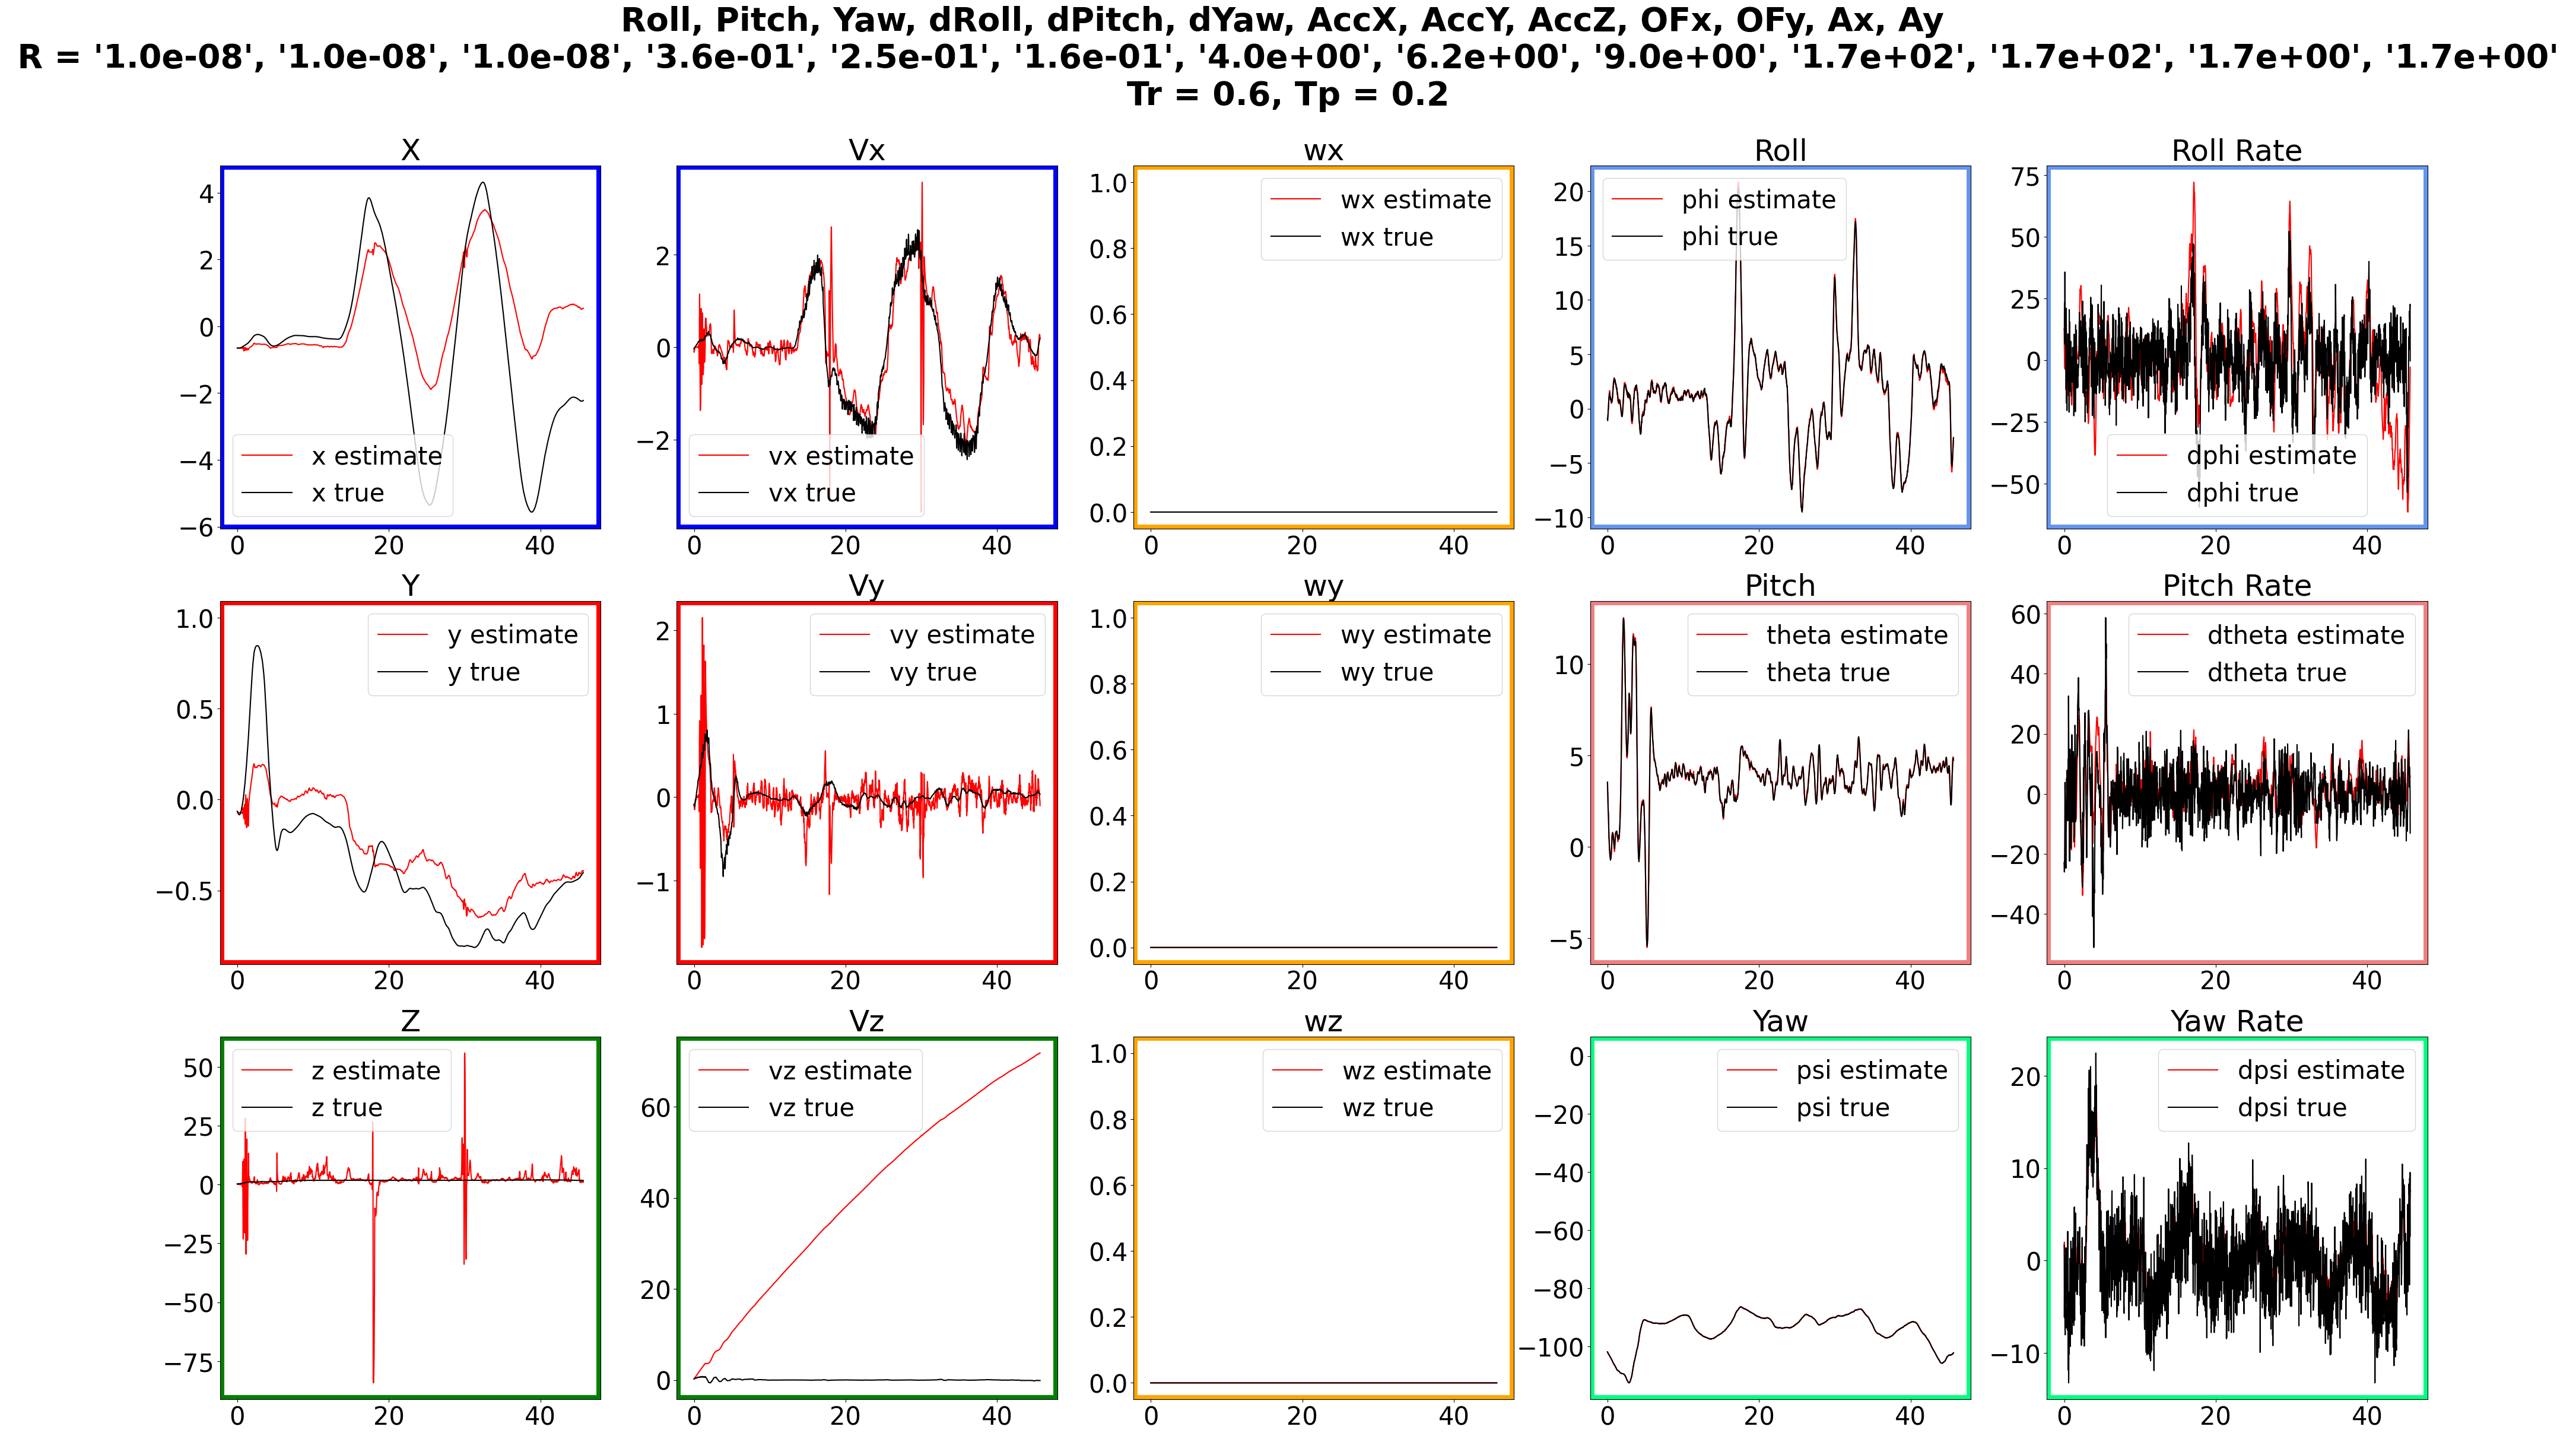

In [752]:
from matplotlib.patches import Rectangle



# in one long figure with 15 subplots, one for each state variable, plot the true state variable and the estimated state variable
plt.rcParams.update({'font.size': 30})
plt.figure(figsize=(48, 27))
plt.subplot(3, 5, 1)
plt.plot(TIME[B_range:E_range], x_hat, label="x estimate", color='red')
plt.plot(TIME[B_range:E_range], X_TRUE[B_range:E_range], label="x true", color='black')
plt.title('X')
plt.legend()
ax1 = plt.gca()  # Get the current axis for subplot 1

plt.subplot(3, 5, 2)
plt.plot(TIME[B_range:E_range], vx_hat, label="vx estimate", color='red')
plt.plot(TIME[B_range:E_range], X_DOT_TRUE[B_range:E_range], label="vx true", color='black')
plt.title('Vx')
plt.legend()
ax2 = plt.gca()  # Get the current axis for subplot 2

# Add red box to highlight subplots 1 and 2
for ax in [ax1, ax2]:
    rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes, color="blue", fill=False, lw=10)
    ax.add_patch(rect)

plt.subplot(3, 5, 6)
plt.plot(TIME[B_range:E_range], y_hat, label="y estimate", color='red')
plt.plot(TIME[B_range:E_range], Y_TRUE[B_range:E_range], label="y true", color='black')
plt.title('Y')
plt.legend()
ax3 = plt.gca()  # Get the current axis for subplot 3

plt.subplot(3, 5, 7)
plt.plot(TIME[B_range:E_range], vy_hat, label="vy estimate", color='red')
plt.plot(TIME[B_range:E_range], Y_DOT_TRUE[B_range:E_range], label="vy true", color='black')
plt.title('Vy')
plt.legend()
ax4 = plt.gca()  # Get the current axis for subplot 4

# Add red box to highlight subplots 3 and 4
for ax in [ax3, ax4]:
    rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes, color="red", fill=False, lw=10)
    ax.add_patch(rect)

plt.subplot(3, 5, 11)
plt.plot(TIME[B_range:E_range], z_hat, label="z estimate", color='red')
plt.plot(TIME[B_range:E_range], Z_TRUE[B_range:E_range], label="z true", color='black')
plt.title('Z')
plt.legend()
ax5 = plt.gca()  # Get the current axis for subplot 5

plt.subplot(3, 5, 12)
plt.plot(TIME[B_range:E_range], vz_hat, label="vz estimate", color='red')
plt.plot(TIME[B_range:E_range], Z_DOT_TRUE[B_range:E_range], label="vz true", color='black')
plt.title('Vz')
plt.legend()
ax6 = plt.gca()  # Get the current axis for subplot 6

# Add green box to highlight subplots 5 and 6
for ax in [ax5, ax6]:
    rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes, color="green", fill=False, lw=10)
    ax.add_patch(rect)

plt.subplot(3, 5, 4)
plt.plot(TIME[B_range:E_range], np.degrees(phi_hat), label="phi estimate", color='red')
plt.plot(TIME[B_range:E_range], np.degrees(ROLL_TRUE)[B_range:E_range], label="phi true", color='black')
plt.title('Roll')
plt.legend()
ax7 = plt.gca()  # Get the current axis for subplot 7

plt.subplot(3, 5, 5)
plt.plot(TIME[B_range:E_range], np.degrees(dphi_hat), label="dphi estimate", color='red')
plt.plot(TIME[B_range:E_range], np.degrees(IMU_ROLL_RATE)[B_range:E_range], label="dphi true", color='black')
plt.title('Roll Rate')
plt.legend()
ax8 = plt.gca()  # Get the current axis for subplot 8

# Add green box to highlight subplots 7 and 8
for ax in [ax7, ax8]:
    rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes, color="cornflowerblue", fill=False, lw=10)
    ax.add_patch(rect)

plt.subplot(3, 5, 9)
plt.plot(TIME[B_range:E_range], np.degrees(theta_hat), label="theta estimate", color='red')
plt.plot(TIME[B_range:E_range], np.degrees(PITCH_TRUE)[B_range:E_range], label="theta true", color='black')
plt.title('Pitch')
plt.legend()
ax9 = plt.gca()  # Get the current axis for subplot 9

plt.subplot(3, 5, 10)
plt.plot(TIME[B_range:E_range], np.degrees(dtheta_hat), label="dtheta estimate", color='red')
plt.plot(TIME[B_range:E_range], np.degrees(IMU_PITCH_RATE)[B_range:E_range], label="dtheta true", color='black')
plt.title('Pitch Rate')
plt.legend()
ax10 = plt.gca()  # Get the current axis for subplot 10

# Add green box to highlight subplots 9 and 10
for ax in [ax9, ax10]:
    rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes, color="lightcoral", fill=False, lw=10)
    ax.add_patch(rect)

plt.subplot(3, 5, 14)
plt.plot(TIME[B_range:E_range], np.degrees(psi_hat), label="psi estimate", color='red')
plt.plot(TIME[B_range:E_range], np.degrees(YAW_TRUE)[B_range:E_range], label="psi true", color='black')
plt.title('Yaw')
plt.legend()
ax11 = plt.gca()  # Get the current axis for subplot 11


plt.subplot(3, 5, 15)
plt.plot(TIME[B_range:E_range], np.degrees(dpsi_hat), label="dpsi estimate", color='red')
plt.plot(TIME[B_range:E_range], np.degrees(IMU_YAW_RATE)[B_range:E_range], label="dpsi true", color='black')
plt.title('Yaw Rate')
plt.legend()
ax12 = plt.gca()  # Get the current axis for subplot 12

# Add green box to highlight subplots 11 and 12
for ax in [ax11, ax12]:
    rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes, color="springgreen", fill=False, lw=10)
    ax.add_patch(rect)

plt.subplot(3, 5, 3)
plt.plot(TIME[B_range:E_range], wx_hat, label="wx estimate", color='red')
plt.plot(TIME[B_range:E_range], np.zeros(len(wx_hat)), label="wx true", color='black')
plt.title('wx')
plt.legend()
ax13 = plt.gca()  # Get the current axis for subplot 13

plt.subplot(3, 5, 8)
plt.plot(TIME[B_range:E_range], wy_hat, label="wy estimate", color='red')
plt.plot(TIME[B_range:E_range], np.zeros(len(wy_hat)), label="wy true", color='black')
plt.title('wy')
plt.legend()
ax14 = plt.gca()  # Get the current axis for subplot 14

plt.subplot(3, 5, 13)
plt.plot(TIME[B_range:E_range], wz_hat, label="wz estimate", color='red')
plt.plot(TIME[B_range:E_range], np.zeros(len(wz_hat)), label="wz true", color='black')
plt.title('wz')
plt.legend()
ax15 = plt.gca()  # Get the current axis for subplot 15

# Add green box to highlight subplots 13, 14, and 15
for ax in [ax13, ax14, ax15]:
    rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes, color="orange", fill=False, lw=10)
    ax.add_patch(rect)

# Add a figure-wide title
RRR=((v_small**2).tolist())
RRR=["{:.1e}".format(num) for num in RRR]
# print(RRR)
# plt.suptitle('Mocap Vx, Vy, Vz, X,Y, Z, Roll, Pitch, Yaw, Wx, Wy, Wz \n R = '+ str(RRR)[1:-1]+' \nTr = '+ str(Tr) +', Tp = '+ str(Tp), fontsize=40, weight='bold')  # Adjust the font size and weight
plt.suptitle('Roll, Pitch, Yaw, dRoll, dPitch, dYaw, AccX, AccY, AccZ, OFx, OFy, Ax, Ay \n R = '+ str(RRR)[1:-1]+' \nTr = '+ str(Tr) +', Tp = '+ str(Tp), fontsize=40, weight='bold')  # Adjust the font size and weight
# Adjust the layout to prevent overlap
# plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the rect parameter to leave space for the figure title

# add bias
# add 3 sigma bounds
# change the scale of wx, wy, wz
# R mocap 1e-6


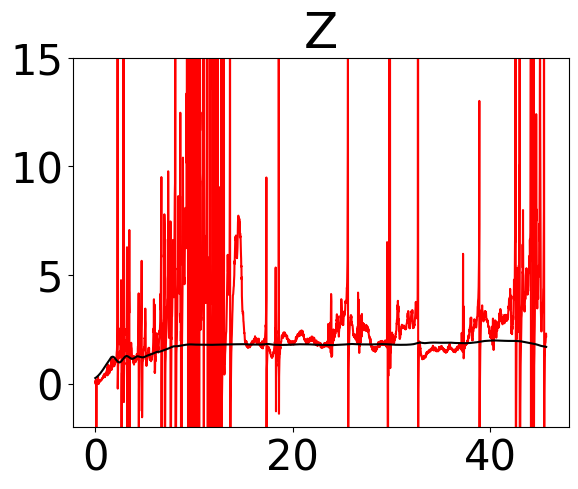

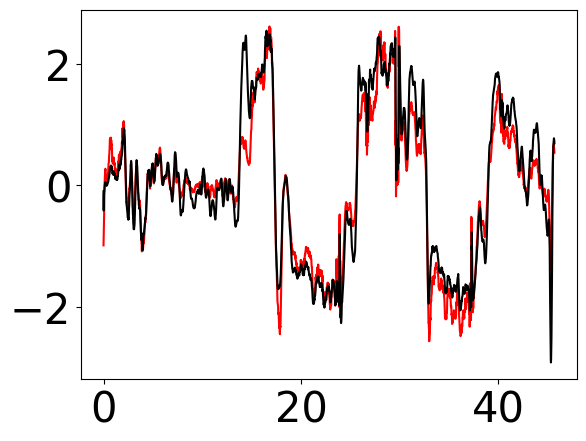

In [726]:
# get z from opticflow measure and vx estimate
z=(1/OF_X_f)*vx_hat/OF_X
# plot the z estimate and the z true
plt.figure()
plt.plot(TIME[B_range:E_range], z/2, label="z estimate", color='red')
plt.plot(TIME[B_range:E_range], Z_TRUE[B_range:E_range], label="z true", color='black')
plt.title('Z')
# plt.legend() 
plt.ylim([-2,15])   
plt.show()


plt.figure()
plt.plot(TIME[B_range:E_range], OF_X*OF_X_f*2, label="vx estimate", color='red')
plt.plot(TIME[B_range:E_range], vx_hat/Z_TRUE[B_range:E_range], label="flow vx true", color='black')


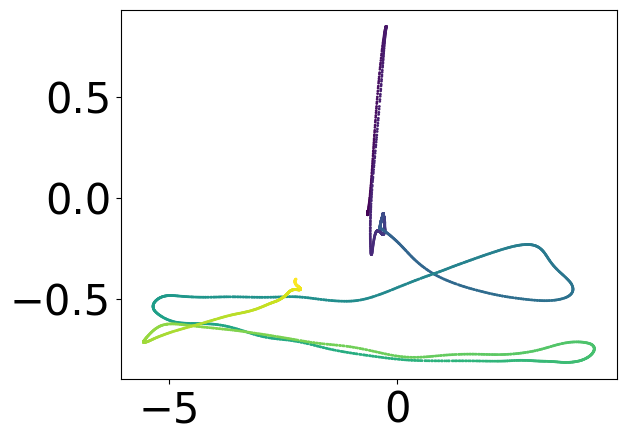

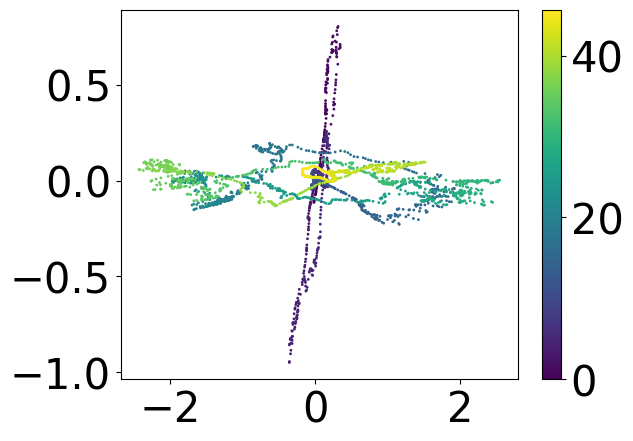

In [590]:
# # plot 2d position
plt.scatter(X_TRUE,Y_TRUE,label='Estimated',s=1,c=TIME)
plt.show()

plt.scatter(X_DOT_TRUE,Y_DOT_TRUE,label='Estimated',s=1,c=TIME)
# add color bar for time
plt.colorbar()
plt.show()

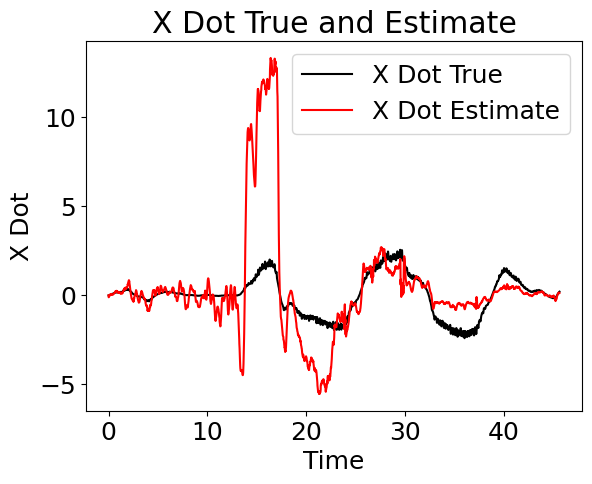

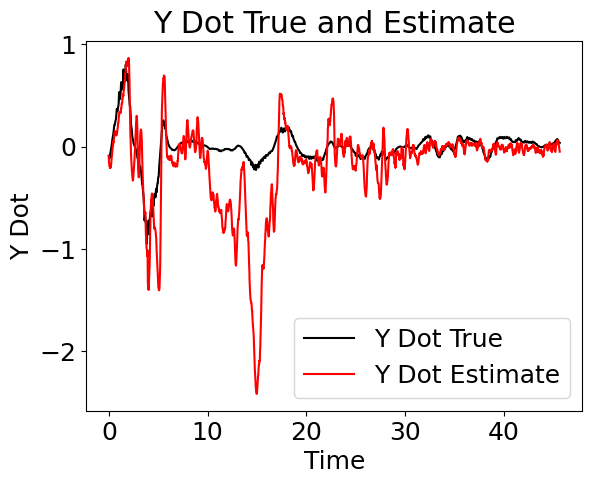

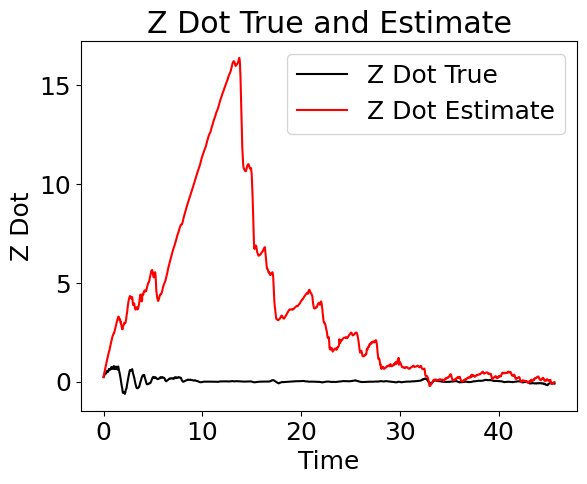

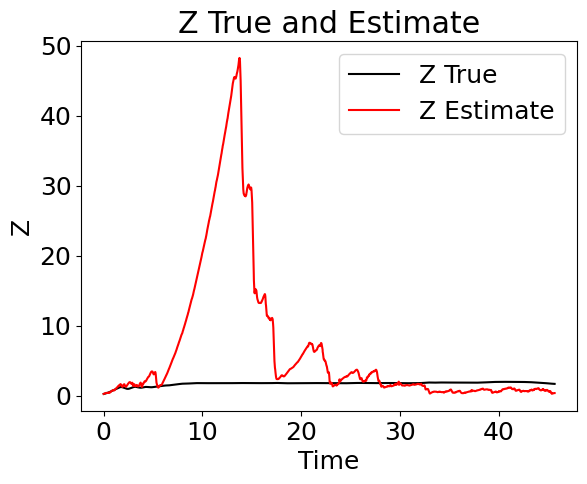

978
16.41830015182495


array([[-6.52598575e-01, -6.53901244e-01, -6.55182998e-01, ...,
         1.79258350e+00,  1.79324788e+00,  1.79458660e+00],
       [-2.51450330e-02, -1.28953016e-01, -1.26397453e-01, ...,
         1.27371186e-01,  1.23642796e-01,  1.09266840e-01],
       [-6.52707997e-02, -6.66606695e-02, -6.81984816e-02, ...,
         8.88258363e-01,  8.88172932e-01,  8.87756791e-01],
       ...,
       [-8.50737062e-01, -8.07315645e-01, -7.56862907e-01, ...,
        -1.05225821e-01, -1.35560223e-01, -1.61080658e-01],
       [ 1.26668536e+00,  1.15486467e+00,  1.03710158e+00, ...,
        -8.28267467e-02, -7.68803966e-02, -6.83129701e-02],
       [ 0.00000000e+00,  3.13167248e-04,  5.79845095e-04, ...,
         1.17820362e+02,  1.17761860e+02,  1.17744647e+02]])

In [162]:
# #plot OF X
# plt.plot(TIME,OF_X,label='OF X')
# plt.title('OF X')
# plt.xlabel('Time')
# plt.ylabel('OF X')
# plt.legend()
# plt.show()
# #plot OF X scaled
# plt.plot(TIME,OF_X*OF_X_f,label='OF X')
# plt.title('OF X')
# plt.xlabel('Time')
# plt.ylabel('OF X')
# plt.legend()
# plt.show()
# #plot wind X
# plt.plot(TIME,WIND_X,label='Wind X')
# plt.title('Wind X')
# plt.xlabel('Time')
# plt.ylabel('Wind X')
# plt.legend()
# plt.show()
# #plot wind X scaled
# plt.plot(TIME,WIND_X*WIND_X_f,label='Wind X')
# plt.title('Wind X')
# plt.xlabel('Time')
# plt.ylabel('Wind X')
# plt.legend()
# plt.show()

# plot estimate and true values for Vx, Vy, Vz
plt.plot(TIME, X_DOT_TRUE, label="X Dot True",color='black')
plt.plot(TIME[B_range:E_range], vx_hat, label="X Dot Estimate",color='red')
plt.title('X Dot True and Estimate')
plt.xlabel('Time')
plt.ylabel('X Dot')
plt.legend()
# plt.xlim([0,2])
# plt.ylim([-2,2])
plt.show()

plt.plot(TIME, Y_DOT_TRUE, label="Y Dot True",color='black')
plt.plot(TIME[B_range:E_range], vy_hat, label="Y Dot Estimate",color='red')
plt.title('Y Dot True and Estimate')
plt.xlabel('Time')
plt.ylabel('Y Dot')
plt.legend()
# plt.xlim([0,2])
# plt.ylim([-2,2])
plt.show()

plt.plot(TIME, Z_DOT_TRUE, label="Z Dot True",color='black')
plt.plot(TIME[B_range:E_range], vz_hat, label="Z Dot Estimate",color='red')
plt.title('Z Dot True and Estimate')
plt.xlabel('Time')
plt.ylabel('Z Dot')
plt.legend()
# plt.xlim([0,2])
# plt.ylim([-2,2])
plt.show()

plt.plot(TIME,Z_TRUE,label='Z True',color='black')
plt.plot(TIME[B_range:E_range],z_hat,label='Z Estimate',color='red')
plt.title('Z True and Estimate')
plt.xlabel('Time')
plt.ylabel('Z')
plt.legend()
# plt.xlim([0,2])
# plt.ylim([-2,2])
plt.show()
print(np.where(vx_hat==np.max(vx_hat))[0][0])
print(TIME[np.where(vx_hat==np.max(vx_hat))[0][0]])
xhat


In [169]:
# add vlaues to q for z and roll pitch and yaw

# reduce trust in modle, get y to be more accurate hopefully. Q ^ for y dynamics increas for z too
## if that is true then add tourque to the model

### update R values based on ploting measuered true and 3 sigma values

## test zdot/z 

# Use ideal vx and vy and z have it estimate attitude

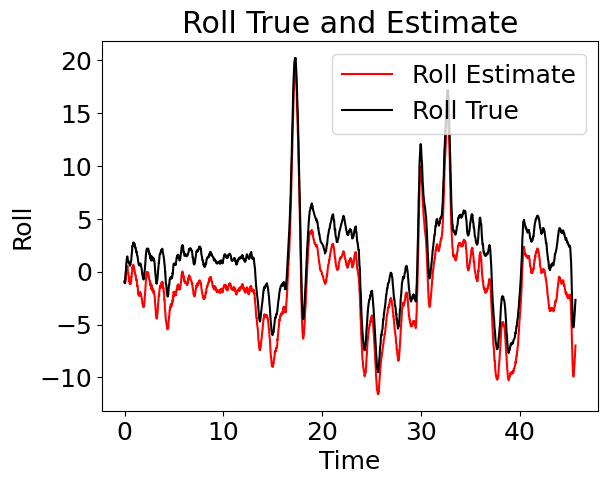

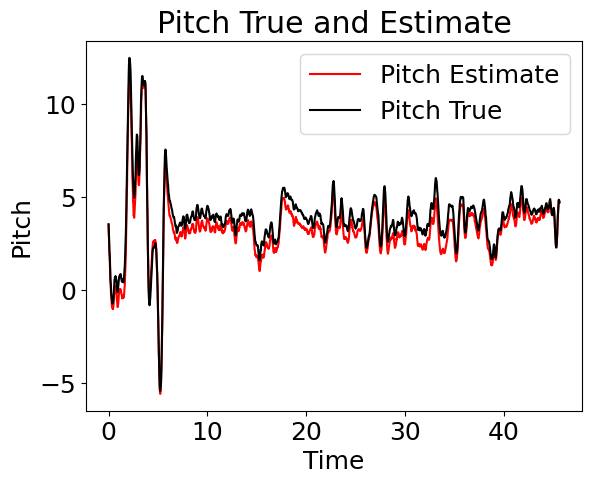

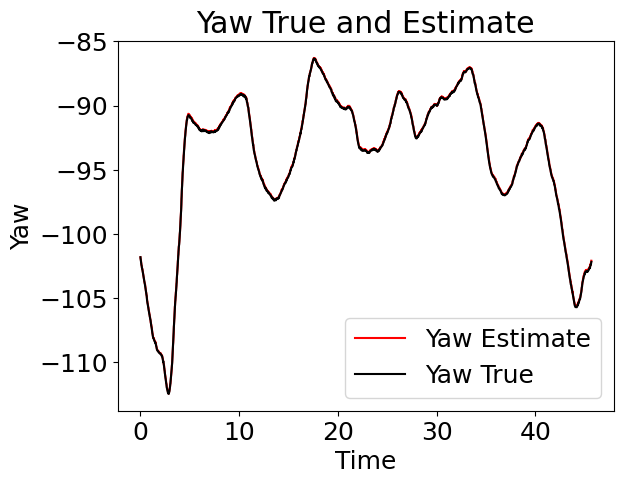

In [168]:
# plot the attitude real vs the attitude estimate

plt.plot(TIME[B_range:E_range],np.degrees(phi_hat),label='Roll Estimate',color='red')
plt.plot(TIME,np.degrees(ROLL_TRUE),label='Roll True',color='black')
plt.title('Roll True and Estimate')
plt.xlabel('Time')
plt.ylabel('Roll')
plt.legend()
# plt.xlim([0,1])
# plt.ylim([-2,2])
plt.show()


plt.plot(TIME[B_range:E_range],np.degrees(theta_hat),label='Pitch Estimate',color='red')
plt.plot(TIME,np.degrees(PITCH_TRUE),label='Pitch True',color='black')
plt.title('Pitch True and Estimate')
plt.xlabel('Time')
plt.ylabel('Pitch')
plt.legend()
# plt.xlim([0,1])
# plt.ylim([-3.14,3.14])
plt.show()


plt.plot(TIME[B_range:E_range],np.degrees(psi_hat),label='Yaw Estimate',color='red')
plt.plot(TIME,np.degrees(YAW_TRUE),label='Yaw True',color='black')
plt.title('Yaw True and Estimate')
plt.xlabel('Time')
plt.ylabel('Yaw')
plt.legend()
# plt.xlim([0,.1])
# plt.ylim([-2,2])
plt.show()  

# MPC of the real data

In [38]:
WX_TRUE = np.zeros(len(TIME))
WY_TRUE = np.zeros(len(TIME))
WZ_TRUE = np.zeros(len(TIME))

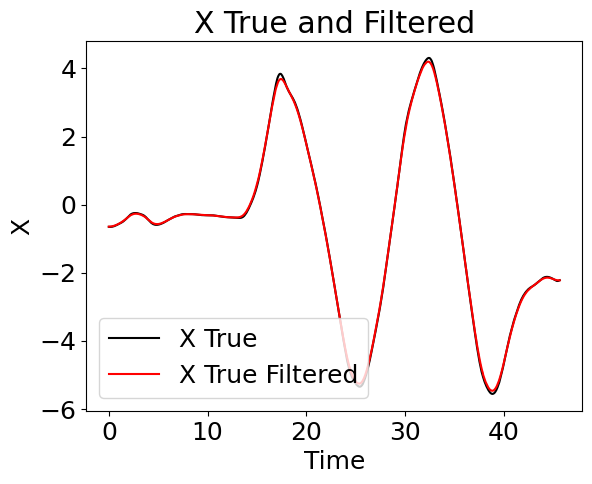

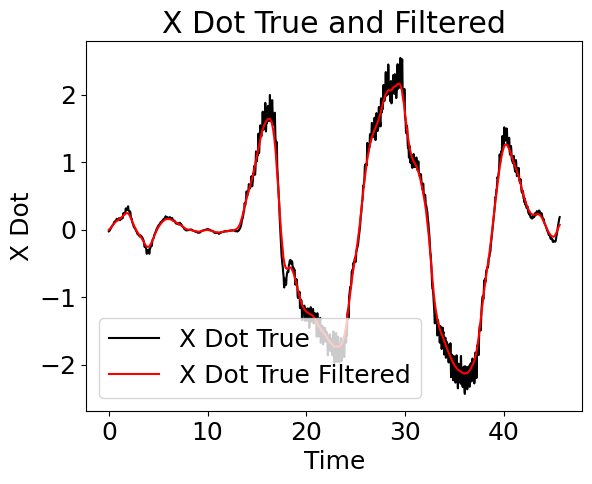

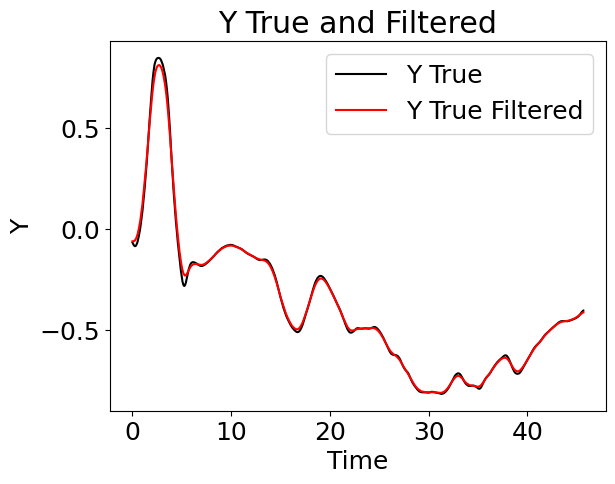

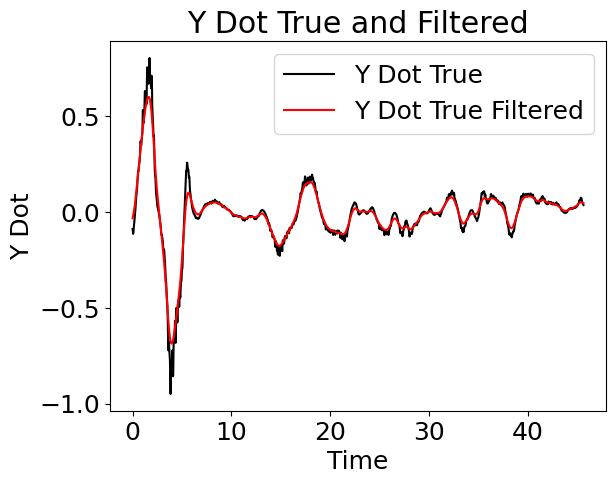

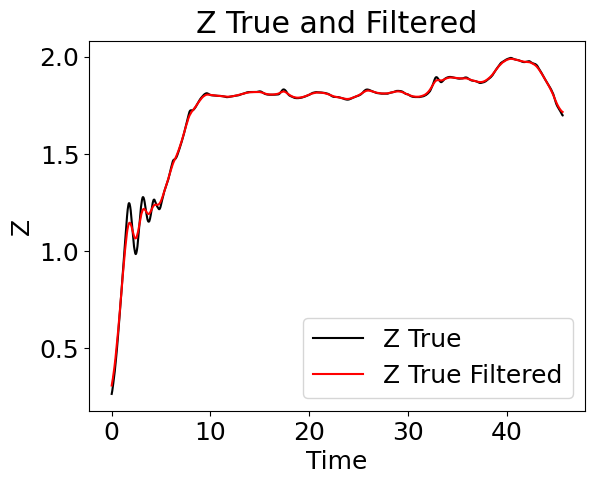

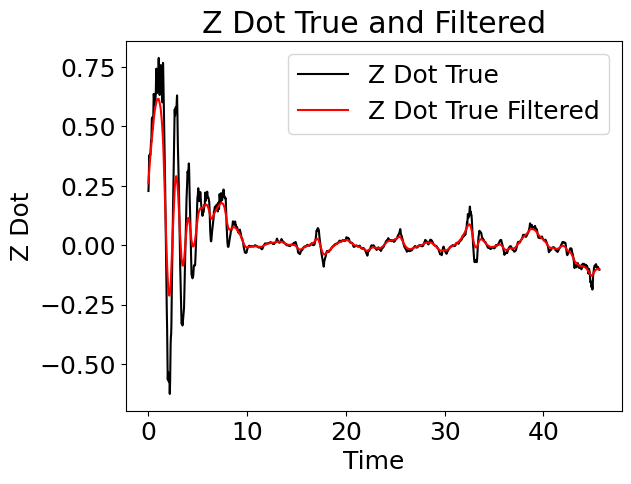

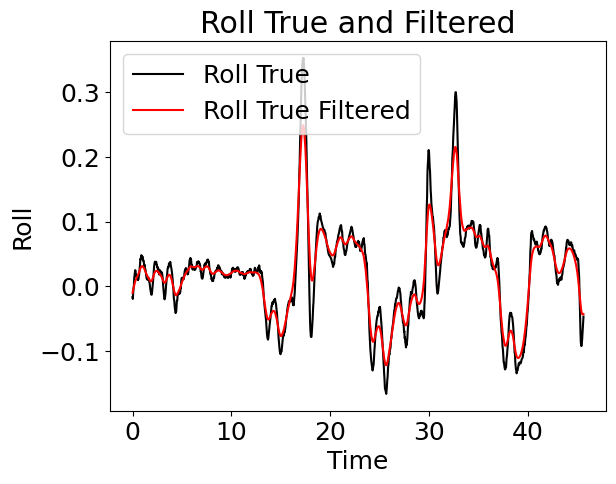

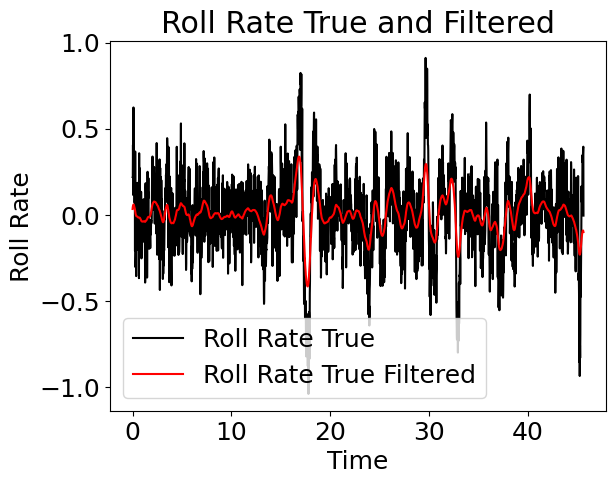

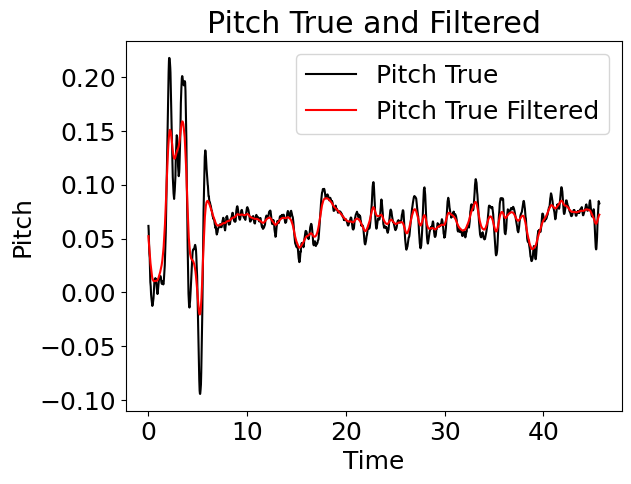

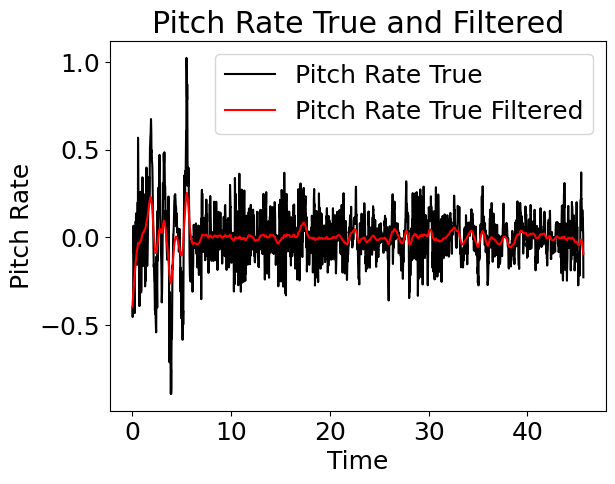

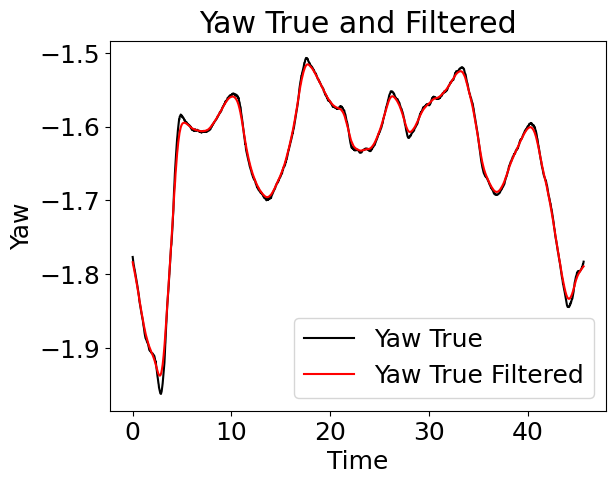

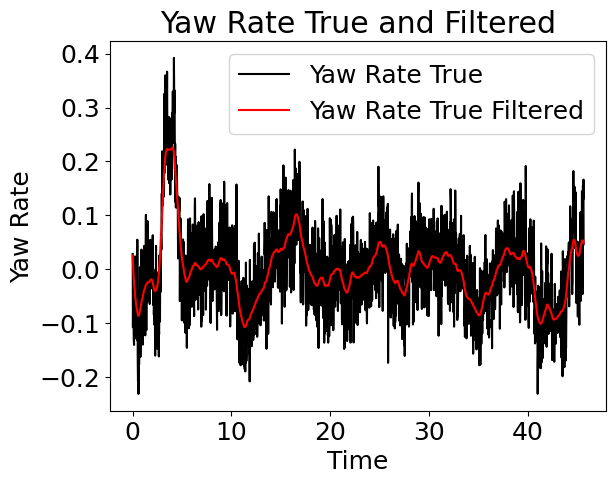

In [459]:
# add import for signal.butter
from scipy import signal
# smooth Vx, Vy, Vz true data with a pass filter
def high_pass_filter(data, dt, cut_off_freq):
    # Create the high pass filter
    b, a = signal.butter(1, cut_off_freq, 'high', fs=1/dt)
    
    # Apply the high pass filter
    data_filtered = signal.filtfilt(b, a, data)
    
    return data_filtered

def low_pass_filter(data, dt, cut_off_freq):
    # Create the high pass filter
    b, a = signal.butter(1, cut_off_freq, 'low', fs=1/dt)
    
    # Apply the high pass filter
    data_filtered = signal.filtfilt(b, a, data)
    
    return data_filtered

# low pass the true data
X_true_filtered = low_pass_filter(X_TRUE, DT, 1)
Vx_true_filtered = low_pass_filter(X_DOT_TRUE, DT, 1)
Y_true_filtered = low_pass_filter(Y_TRUE, DT, 1)
Vy_true_filtered = low_pass_filter(Y_DOT_TRUE, DT, 1)
z_true_filtered = low_pass_filter(Z_TRUE, DT, 1)
Vz_true_filtered = low_pass_filter(Z_DOT_TRUE, DT, 1)
roll_true_filtered = low_pass_filter(ROLL_TRUE, DT, 1)
droll_true_filtered = low_pass_filter(IMU_ROLL_RATE, DT, 1)
pitch_true_filtered = low_pass_filter(PITCH_TRUE, DT, 1)
dpitch_true_filtered = low_pass_filter(IMU_PITCH_RATE, DT, 1)
yaw_true_filtered = low_pass_filter(YAW_TRUE, DT, 1)
dyaw_true_filtered = low_pass_filter(IMU_YAW_RATE, DT, 1)


# plot the true and filtered data
plt.plot(TIME, X_TRUE, label="X True",color='black')
plt.plot(TIME, X_true_filtered, label="X True Filtered",color='red')
plt.title('X True and Filtered')
plt.xlabel('Time')
plt.ylabel('X')
plt.legend()
plt.show()

plt.plot(TIME, X_DOT_TRUE, label="X Dot True",color='black')
plt.plot(TIME, Vx_true_filtered, label="X Dot True Filtered",color='red')
plt.title('X Dot True and Filtered')
plt.xlabel('Time')
plt.ylabel('X Dot')
plt.legend()
plt.show()

plt.plot(TIME, Y_TRUE, label="Y True",color='black')
plt.plot(TIME, Y_true_filtered, label="Y True Filtered",color='red')
plt.title('Y True and Filtered')
plt.xlabel('Time')
plt.ylabel('Y')
plt.legend()
plt.show()

plt.plot(TIME, Y_DOT_TRUE, label="Y Dot True",color='black')
plt.plot(TIME, Vy_true_filtered, label="Y Dot True Filtered",color='red')
plt.title('Y Dot True and Filtered')
plt.xlabel('Time')
plt.ylabel('Y Dot')
plt.legend()
plt.show()

plt.plot(TIME, Z_TRUE, label="Z True",color='black')
plt.plot(TIME, z_true_filtered, label="Z True Filtered",color='red')
plt.title('Z True and Filtered')
plt.xlabel('Time')
plt.ylabel('Z')
plt.legend()
plt.show()

plt.plot(TIME, Z_DOT_TRUE, label="Z Dot True",color='black')
plt.plot(TIME, Vz_true_filtered, label="Z Dot True Filtered",color='red')
plt.title('Z Dot True and Filtered')
plt.xlabel('Time')
plt.ylabel('Z Dot')
plt.legend()
plt.show()

plt.plot(TIME, ROLL_TRUE, label="Roll True",color='black')
plt.plot(TIME, roll_true_filtered, label="Roll True Filtered",color='red')
plt.title('Roll True and Filtered')
plt.xlabel('Time')
plt.ylabel('Roll')
plt.legend()
plt.show()

plt.plot(TIME, IMU_ROLL_RATE, label="Roll Rate True",color='black')
plt.plot(TIME, droll_true_filtered, label="Roll Rate True Filtered",color='red')
plt.title('Roll Rate True and Filtered')
plt.xlabel('Time')
plt.ylabel('Roll Rate')
plt.legend()
plt.show()

plt.plot(TIME, PITCH_TRUE, label="Pitch True",color='black')
plt.plot(TIME, pitch_true_filtered, label="Pitch True Filtered",color='red')
plt.title('Pitch True and Filtered')
plt.xlabel('Time')
plt.ylabel('Pitch')
plt.legend()
plt.show()

plt.plot(TIME, IMU_PITCH_RATE, label="Pitch Rate True",color='black')
plt.plot(TIME, dpitch_true_filtered, label="Pitch Rate True Filtered",color='red')
plt.title('Pitch Rate True and Filtered')
plt.xlabel('Time')
plt.ylabel('Pitch Rate')
plt.legend()
plt.show()

plt.plot(TIME, YAW_TRUE, label="Yaw True",color='black')
plt.plot(TIME, yaw_true_filtered, label="Yaw True Filtered",color='red')
plt.title('Yaw True and Filtered')
plt.xlabel('Time')
plt.ylabel('Yaw')
plt.legend()
plt.show()

plt.plot(TIME, IMU_YAW_RATE, label="Yaw Rate True",color='black')
plt.plot(TIME, dyaw_true_filtered, label="Yaw Rate True Filtered",color='red')
plt.title('Yaw Rate True and Filtered')
plt.xlabel('Time')
plt.ylabel('Yaw Rate')
plt.legend()
plt.show()



In [ ]:
mpc = MPCD.MpcDrone(vx=Vx_true_filtered,vy=Vy_true_filtered,vz=Vz_true_filtered,x=X_true_filtered,y=Y_true_filtered,z=z_true_filtered,wx=WX_TRUE,wy=WY_TRUE,wz=WZ_TRUE,psi=yaw_true_filtered,psidot=dyaw_true_filtered,phi=roll_true_filtered,phidot=droll_true_filtered,theta=pitch_true_filtered,thetadot=dpitch_true_filtered,params=params,dt=DT, n_horizon=50, r_weight=1)
X_MPC,U_MPC = mpc.get_X_and_U()
type(X_MPC)

uwix: 0.0
uwiy: 0.0
uwiz: 0.0


numpy.ndarray

/home/austin/Drone_AFRL/MPC_DRONE_WITH_WIND.py:664: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.legend()
2024-09-30 12:52:48,359 [WARNING] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


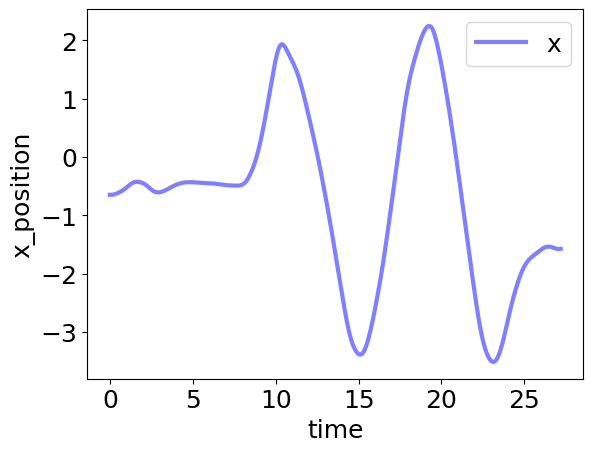

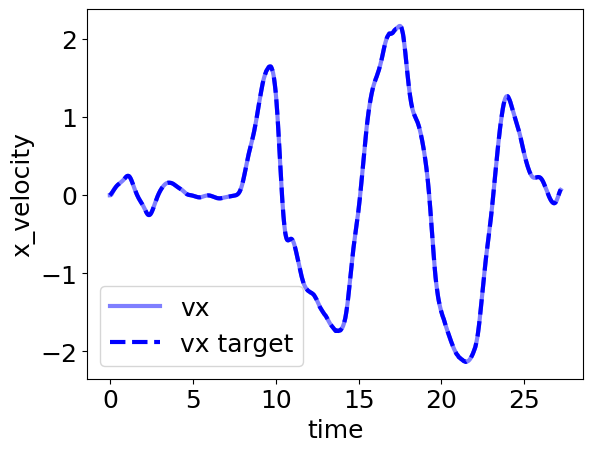

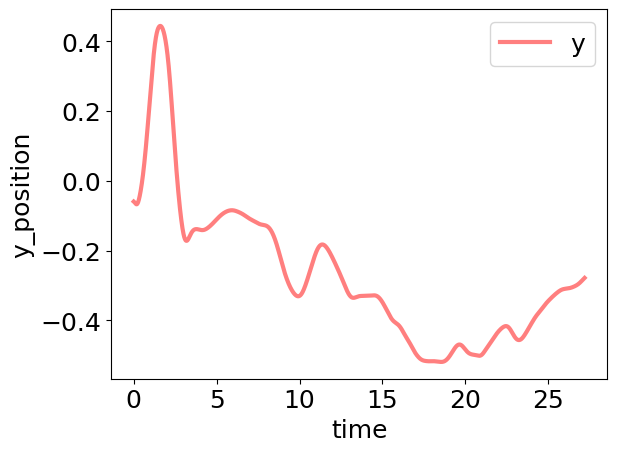

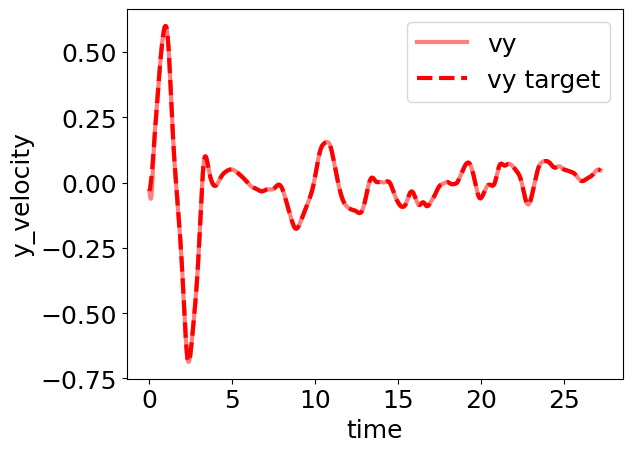

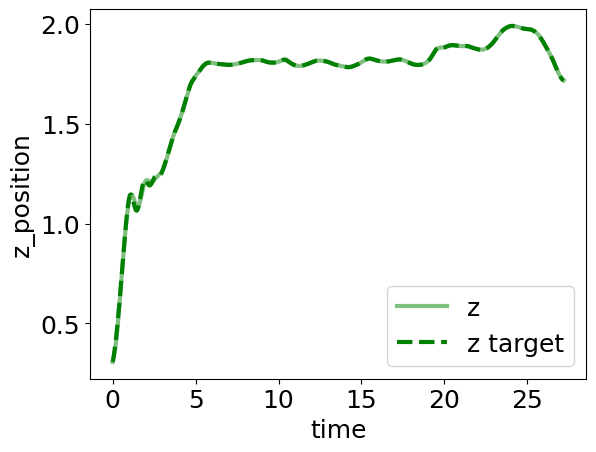

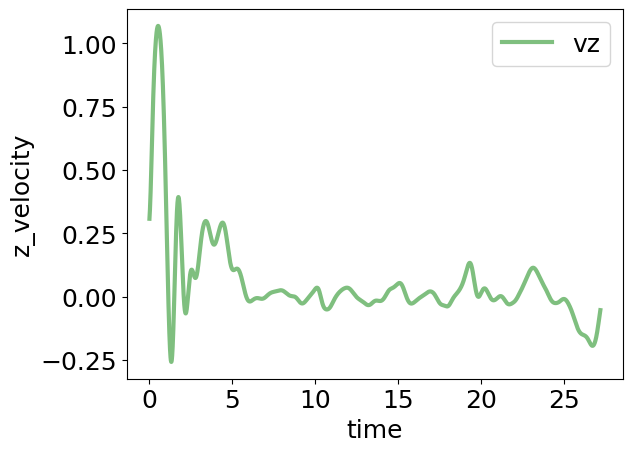

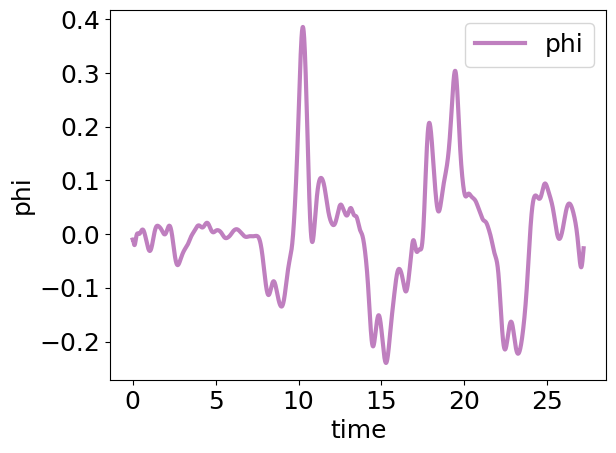

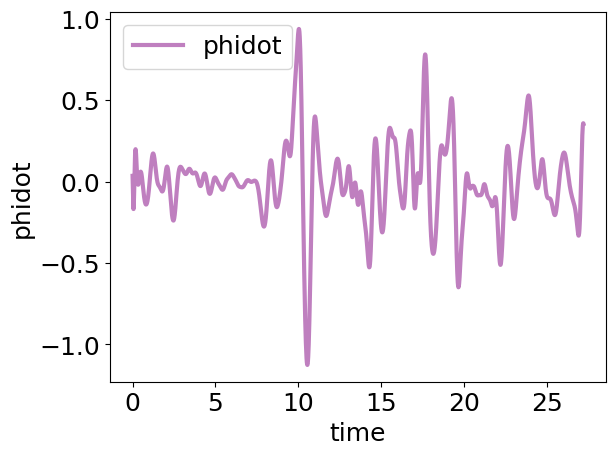

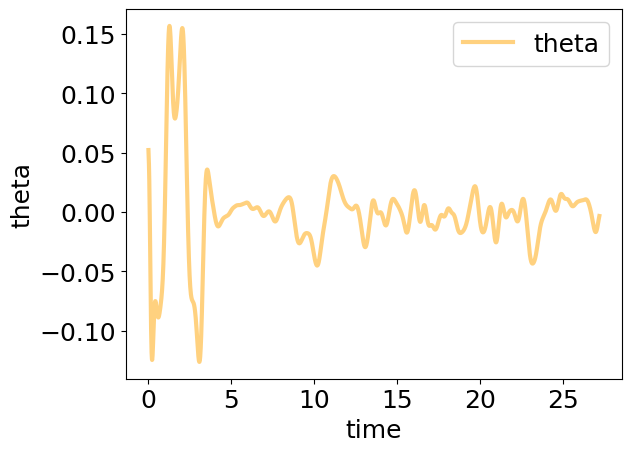

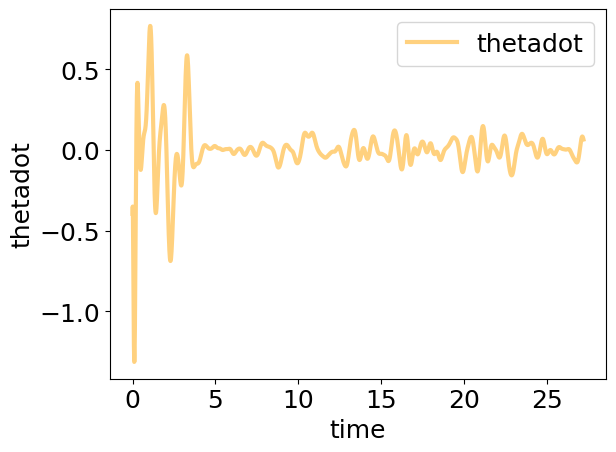

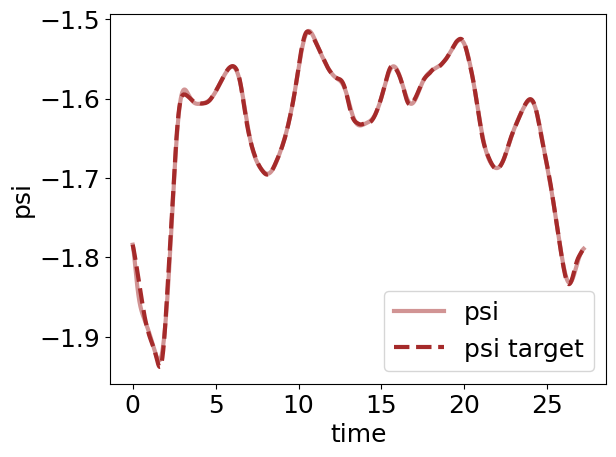

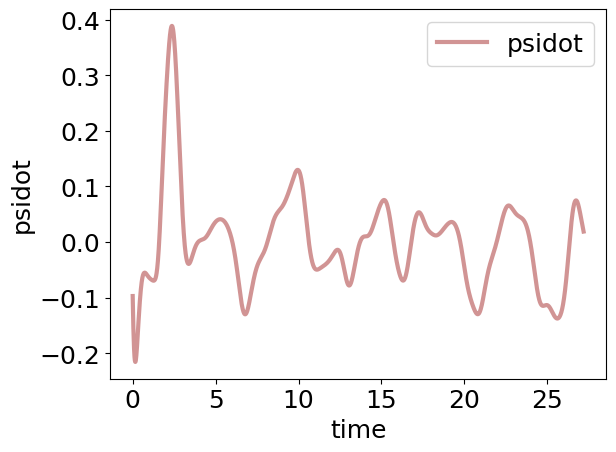

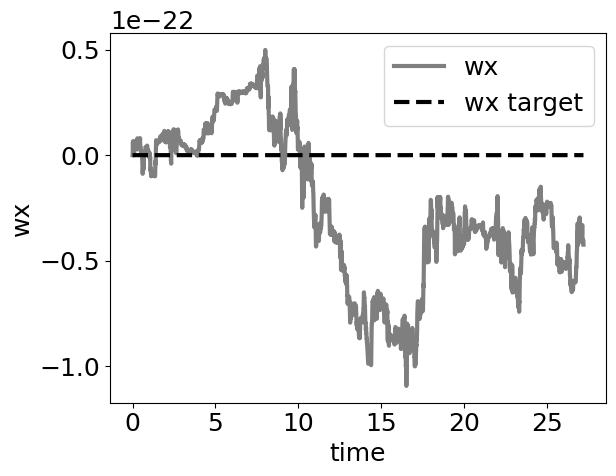

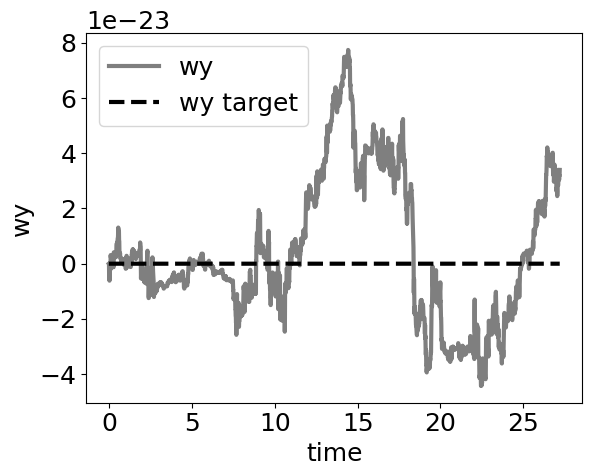

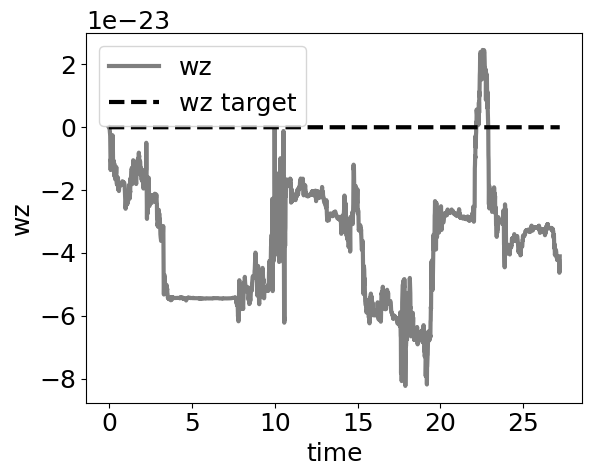

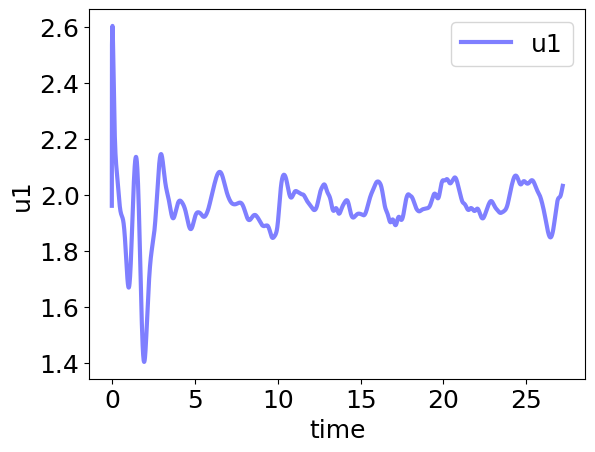

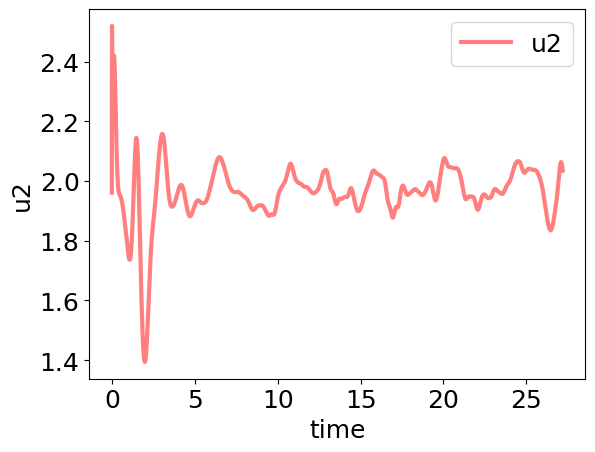

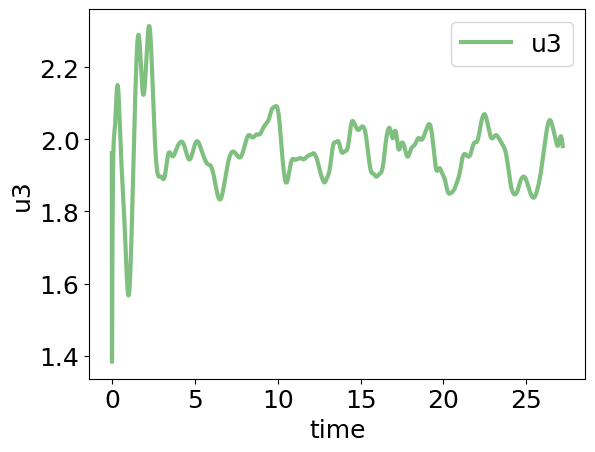

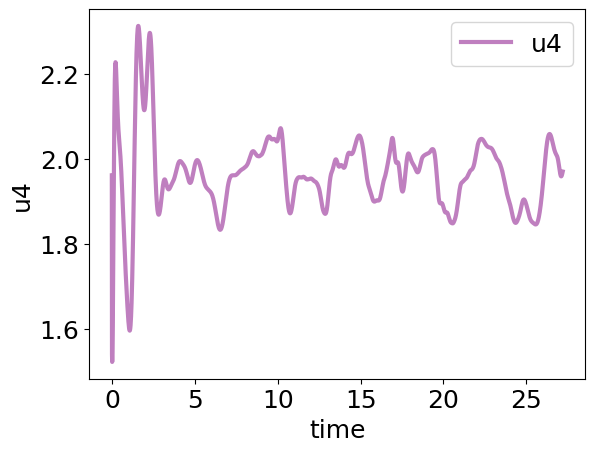

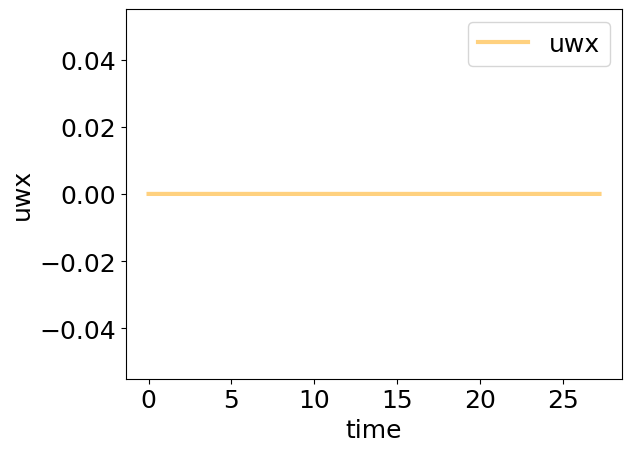

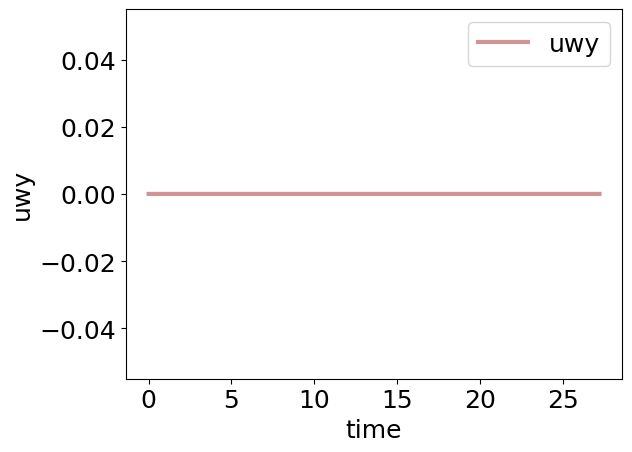

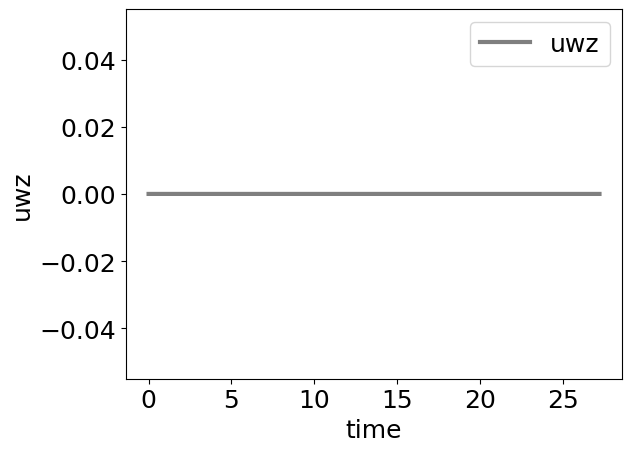

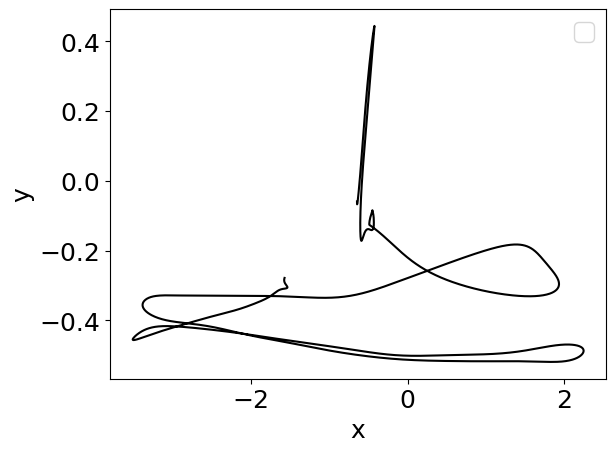

<Figure size 640x480 with 0 Axes>

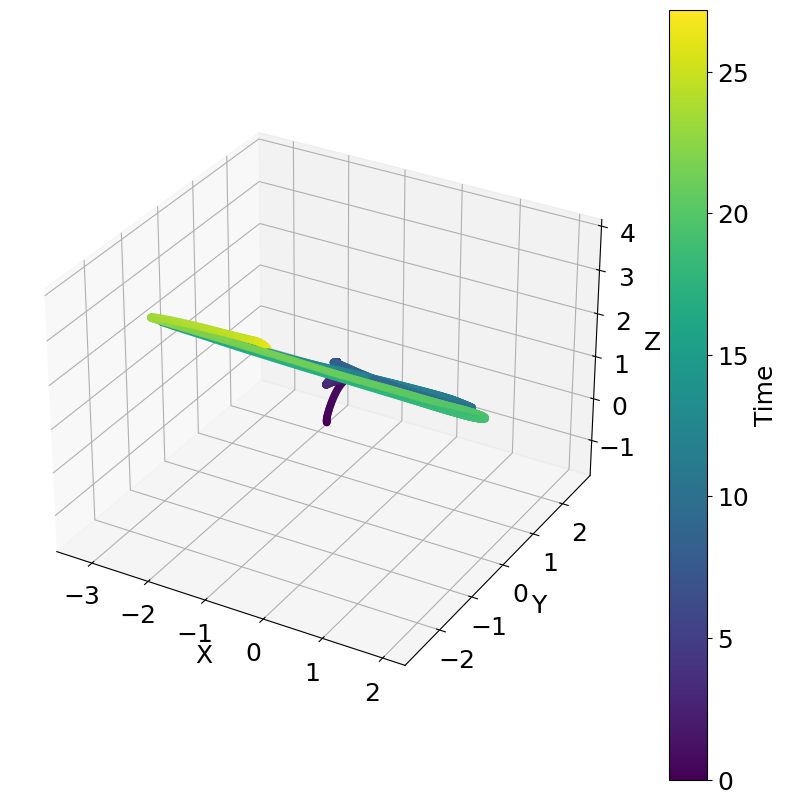

In [ ]:
mpc.plot_states_targets_inputs()

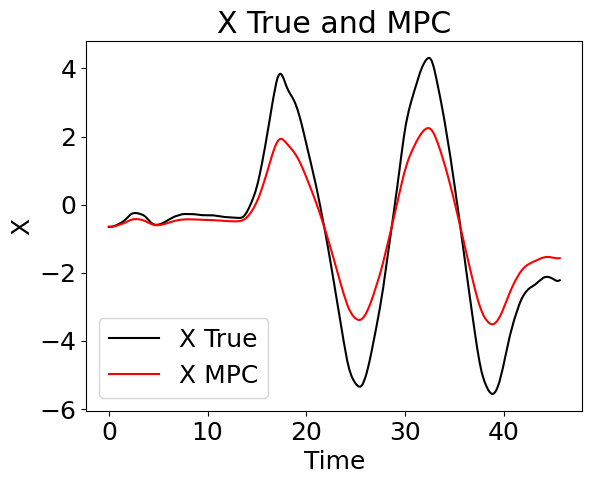

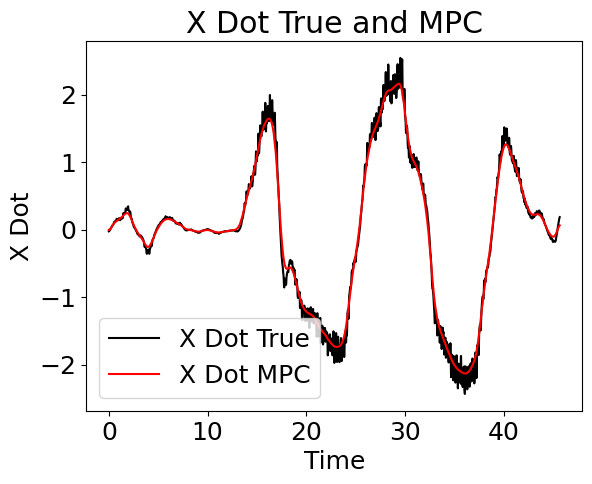

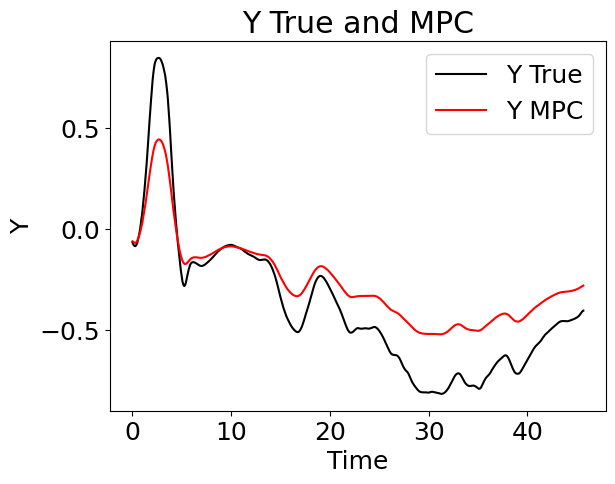

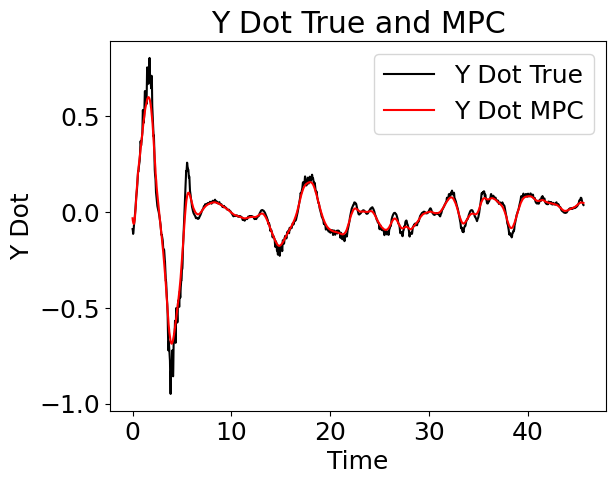

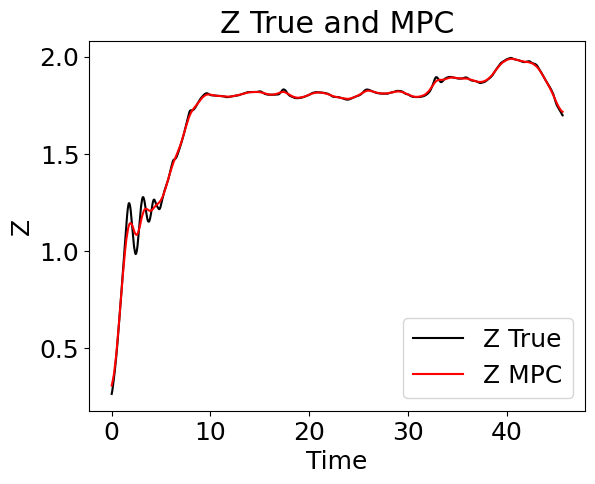

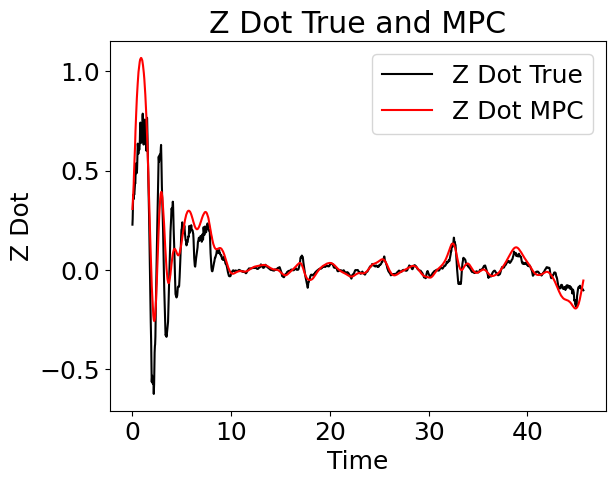

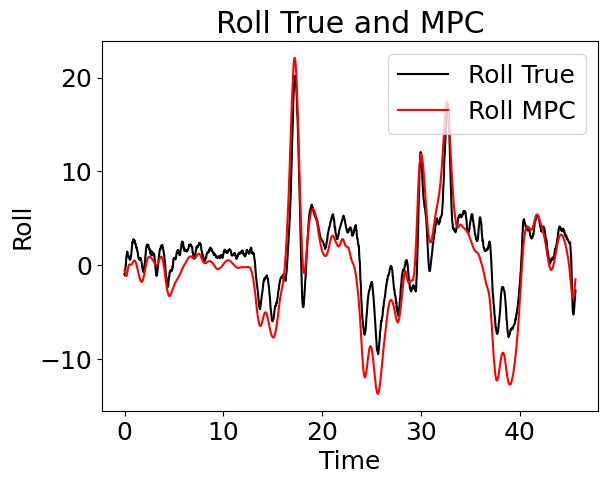

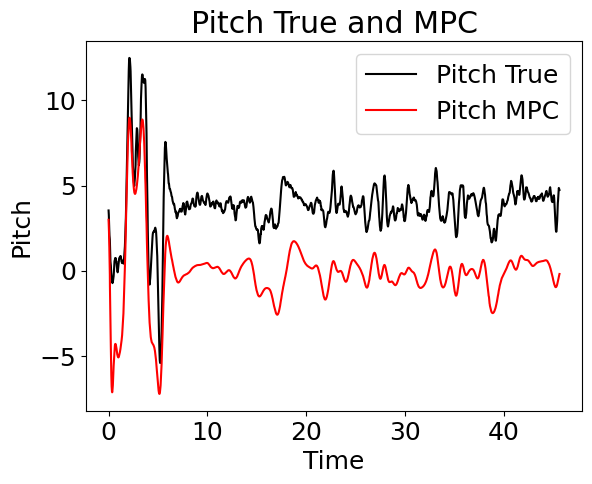

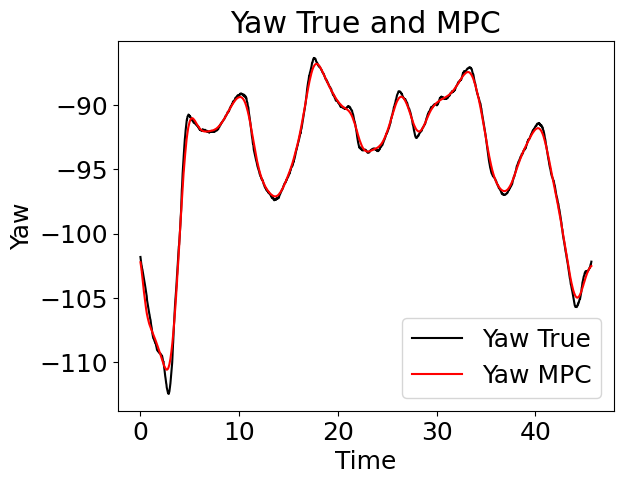

In [140]:
# States
MPC_X          = X_MPC.T[0]
MPC_X_DOT      = X_MPC.T[1]
MPC_Y          = X_MPC.T[2]
MPC_Y_DOT      = X_MPC.T[3]
MPC_Z          = X_MPC.T[4]
MPC_Z_DOT      = X_MPC.T[5]
MPC_ROLL       = X_MPC.T[6]
MPC_ROLL_RATE  = X_MPC.T[7]
MPC_PITCH      = X_MPC.T[8]
MPC_PITCH_RATE = X_MPC.T[9]
MPC_YAW        = X_MPC.T[10]
MPC_YAW_RATE   = X_MPC.T[11]
MPC_WX         = X_MPC.T[12]
MPC_WY         = X_MPC.T[13]
MPC_WZ         = X_MPC.T[14]
# Control inputs
U_MPC_1        = U_MPC.T[0]
U_MPC_2        = U_MPC.T[1]
U_MPC_3        = U_MPC.T[2]
U_MPC_4        = U_MPC.T[3]

# plot the MPC states vs the true states
plt.plot(TIME, X_TRUE, label="X True",color='black')
plt.plot(TIME, MPC_X, label="X MPC",color='red')
plt.title('X True and MPC')
plt.xlabel('Time')
plt.ylabel('X')
plt.legend()
plt.show()

plt.plot(TIME, X_DOT_TRUE, label="X Dot True",color='black')
plt.plot(TIME, MPC_X_DOT, label="X Dot MPC",color='red')
plt.title('X Dot True and MPC')
plt.xlabel('Time')
plt.ylabel('X Dot')
plt.legend()
plt.show()

plt.plot(TIME, Y_TRUE, label="Y True",color='black')
plt.plot(TIME, MPC_Y, label="Y MPC",color='red')
plt.title('Y True and MPC')
plt.xlabel('Time')
plt.ylabel('Y')
plt.legend()
plt.show()

plt.plot(TIME, Y_DOT_TRUE, label="Y Dot True",color='black')
plt.plot(TIME, MPC_Y_DOT, label="Y Dot MPC",color='red')
plt.title('Y Dot True and MPC')
plt.xlabel('Time')
plt.ylabel('Y Dot')
plt.legend()
plt.show()

plt.plot(TIME, Z_TRUE, label="Z True",color='black')
plt.plot(TIME, MPC_Z, label="Z MPC",color='red')
plt.title('Z True and MPC')
plt.xlabel('Time')
plt.ylabel('Z')
plt.legend()
plt.show()

plt.plot(TIME, Z_DOT_TRUE, label="Z Dot True",color='black')
plt.plot(TIME, MPC_Z_DOT, label="Z Dot MPC",color='red')
plt.title('Z Dot True and MPC')
plt.xlabel('Time')
plt.ylabel('Z Dot')
plt.legend()
plt.show()

plt.plot(TIME, np.degrees(ROLL_TRUE), label="Roll True",color='black')
plt.plot(TIME, np.degrees(MPC_ROLL), label="Roll MPC",color='red')
plt.title('Roll True and MPC')
plt.xlabel('Time')
plt.ylabel('Roll')
plt.legend()
plt.show()

plt.plot(TIME, np.degrees(PITCH_TRUE), label="Pitch True",color='black')
plt.plot(TIME, np.degrees(MPC_PITCH), label="Pitch MPC",color='red')
plt.title('Pitch True and MPC')
plt.xlabel('Time')
plt.ylabel('Pitch')
plt.legend()
plt.show()

plt.plot(TIME, np.degrees(YAW_TRUE), label="Yaw True",color='black')
plt.plot(TIME, np.degrees(MPC_YAW), label="Yaw MPC",color='red')
plt.title('Yaw True and MPC')
plt.xlabel('Time')
plt.ylabel('Yaw')
plt.legend()
plt.show()






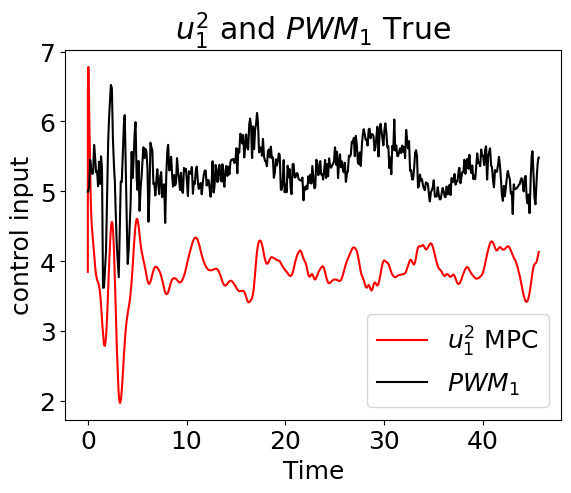

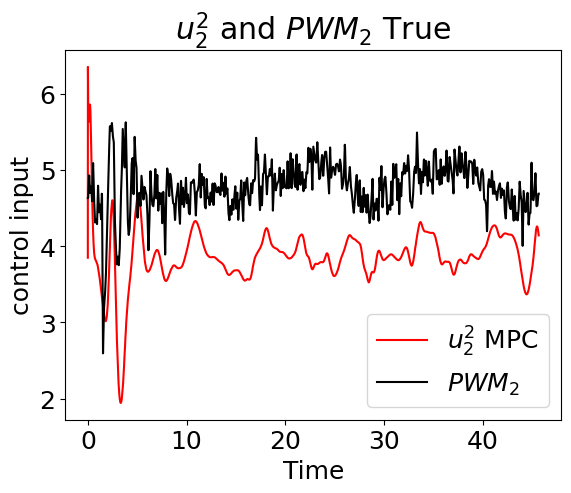

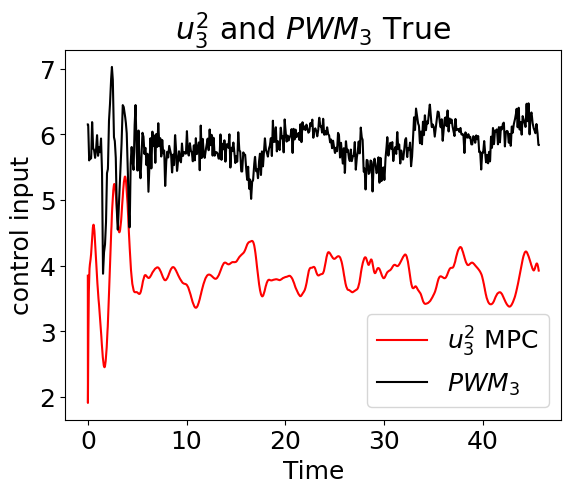

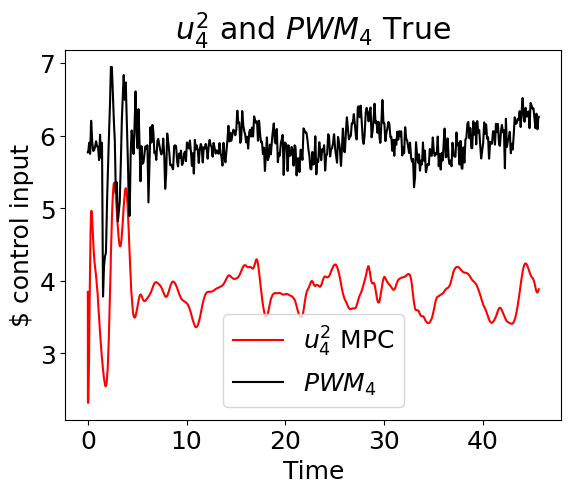

In [141]:
plt.plot(TIME, np.power(U_MPC_1,2), label="$u_{1}^{2}$ MPC",color='red')
plt.plot(TIME, PWM_1, label="$PWM_{1}$",color='black')
plt.title('$u_{1}^{2}$ and $PWM_{1}$ True')
plt.xlabel('Time')
plt.ylabel('control input')
plt.legend()
plt.show()

plt.plot(TIME, np.power(U_MPC_2,2), label="$u_{2}^{2}$ MPC",color='red')
plt.plot(TIME, PWM_2, label="$PWM_{2}$",color='black')
plt.title('$u_{2}^{2}$ and $PWM_{2}$ True')
plt.xlabel('Time')
plt.ylabel('control input')
plt.legend()
plt.show()

plt.plot(TIME, np.power(U_MPC_3,2), label="$u_{3}^{2}$ MPC",color='red')
plt.plot(TIME, PWM_3, label="$PWM_{3}$",color='black')
plt.title('$u_{3}^{2}$ and $PWM_{3}$ True')
plt.xlabel('Time')
plt.ylabel('control input')
plt.legend()
plt.show()

plt.plot(TIME, np.power(U_MPC_4,2), label="$u_{4}^{2}$ MPC",color='red')
plt.plot(TIME, PWM_4, label="$PWM_{4}$",color='black')
plt.title('$u_{4}^{2}$ and $PWM_{4}$ True')
plt.xlabel('Time')
plt.ylabel('$ control input')
plt.legend()
plt.show()

In [142]:
# get force from control inputs
F_MPC = Real_b * (U_MPC_1**2 + U_MPC_2**2 + U_MPC_3**2 + U_MPC_4**2)
F_REAL = Real_b * (PWM_1 + PWM_2 + PWM_3 + PWM_4)

# # plot U2 U3 U4 and OMEGA
# U2_MPC = Real_b * (U_MPC_4**2 + U_MPC_1**2 - U_MPC_2**2 - U_MPC_3**2)
# U3_MPC = Real_b * (U_MPC_3**2 + U_MPC_4**2 - U_MPC_1**2 - U_MPC_2**2)
# U4_MPC = Real_d * (-U_MPC_1**2 + U_MPC_2**2 - U_MPC_3**2 + U_MPC_4**2)
# OMEGA_MPC = U_MPC_2 + U_MPC_4 - U_MPC_1 - U_MPC_3
# U2_REAL = Real_b * (PWM_4 + PWM_1 - PWM_2 - PWM_3)
# U3_REAL = Real_b * (PWM_3 + PWM_4 - PWM_1 - PWM_2)
# U4_REAL = Real_d * (-PWM_1 + PWM_2 - PWM_3 + PWM_4)
# OMEGA_REAL = PWM_2**(1/2) + PWM_4**(1/2) - PWM_1**(1/2) - PWM_3**(1/2)

U2_MPC = Real_b * (-U_MPC_1**2 + U_MPC_2**2 + U_MPC_3**2 - U_MPC_4**2)
U3_MPC = Real_b * (-U_MPC_1**2 + U_MPC_2**2 - U_MPC_3**2 + U_MPC_4**2)
U4_MPC = Real_d * (-U_MPC_1**2 - U_MPC_2**2 + U_MPC_3**2 + U_MPC_4**2)
OMEGA_MPC = U_MPC_1**(1/2) + U_MPC_2**(1/2) - U_MPC_3**(1/2) - U_MPC_4**(1/2)
U2_REAL = Real_b * (-PWM_1 + PWM_2 + PWM_3 - PWM_4)
U3_REAL = Real_b * (-PWM_1 + PWM_2 - PWM_3 + PWM_4)
U4_REAL = Real_d * (-PWM_1 - PWM_2 + PWM_3 + PWM_4)
OMEGA_REAL = PWM_1**(1/2) + PWM_2**(1/2) - PWM_3**(1/2) - PWM_4**(1/2)

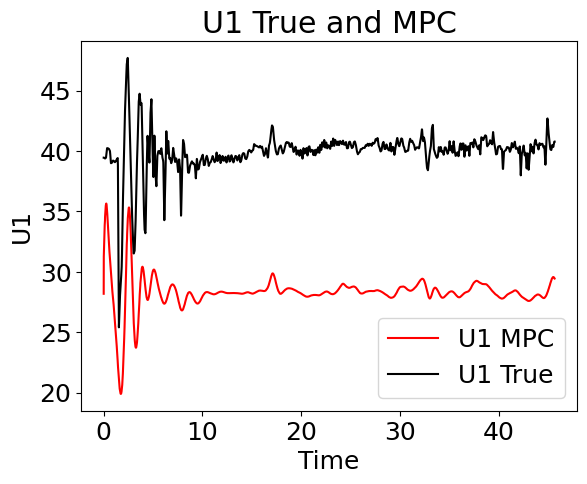

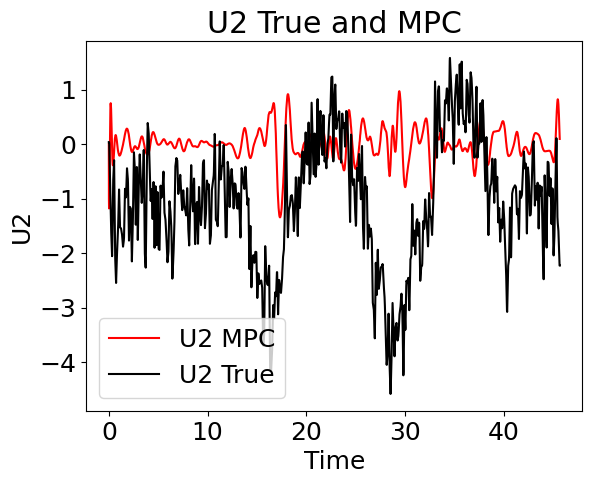

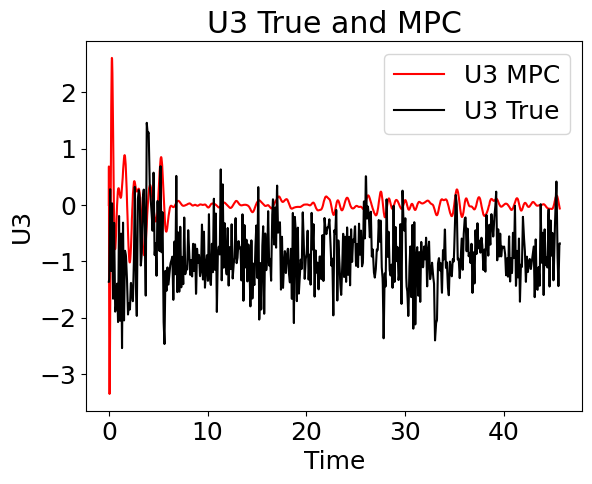

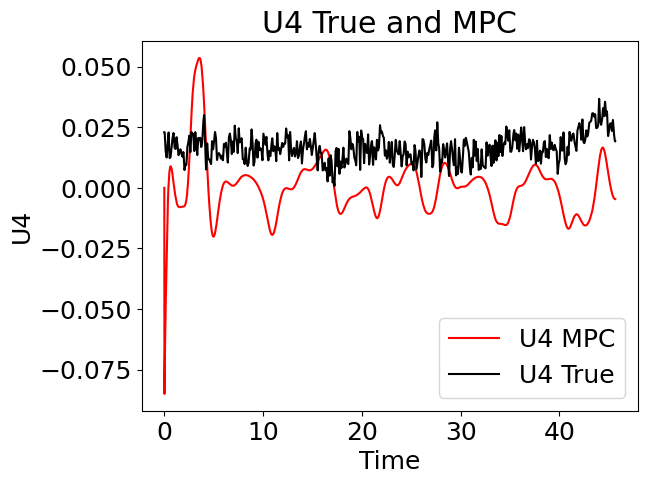

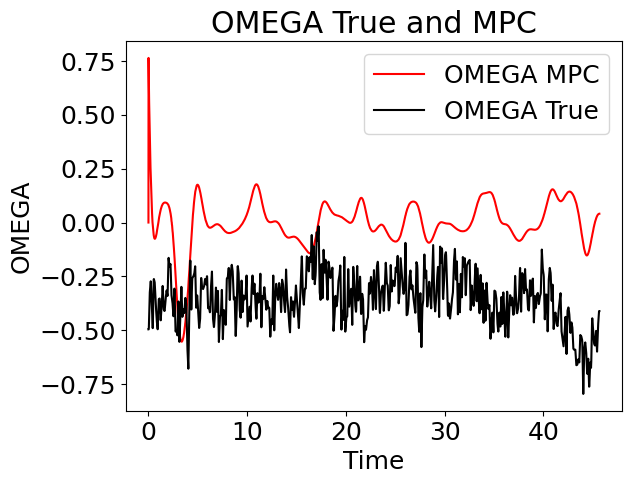

In [143]:
# plot U1 and UU1
plt.plot(TIME, F_MPC, label="U1 MPC",color='red')
plt.plot(TIME, F_REAL, label="U1 True",color='black')
plt.title('U1 True and MPC')
plt.xlabel('Time')
plt.ylabel('U1')
plt.legend()
plt.show()

plt.plot(TIME, U2_MPC, label="U2 MPC",color='red')
plt.plot(TIME, U2_REAL, label="U2 True",color='black')
plt.title('U2 True and MPC')
plt.xlabel('Time')
plt.ylabel('U2')
plt.legend()
plt.show()

plt.plot(TIME, U3_MPC, label="U3 MPC",color='red')
plt.plot(TIME, U3_REAL, label="U3 True",color='black')
plt.title('U3 True and MPC')
plt.xlabel('Time')
plt.ylabel('U3')
plt.legend()
plt.show()

plt.plot(TIME, U4_MPC, label="U4 MPC",color='red')
plt.plot(TIME, U4_REAL, label="U4 True",color='black')
plt.title('U4 True and MPC')
plt.xlabel('Time')
plt.ylabel('U4')
plt.legend()
plt.show()

plt.plot(TIME, OMEGA_MPC, label="OMEGA MPC",color='red')
plt.plot(TIME, OMEGA_REAL, label="OMEGA True",color='black')
plt.title('OMEGA True and MPC')
plt.xlabel('Time')
plt.ylabel('OMEGA')
plt.legend()
plt.show()



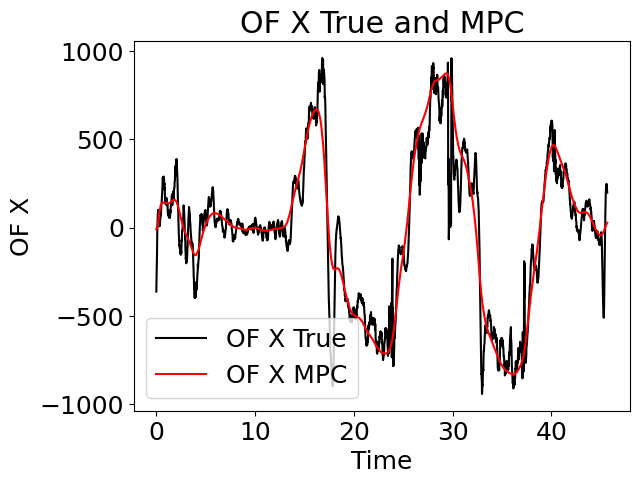

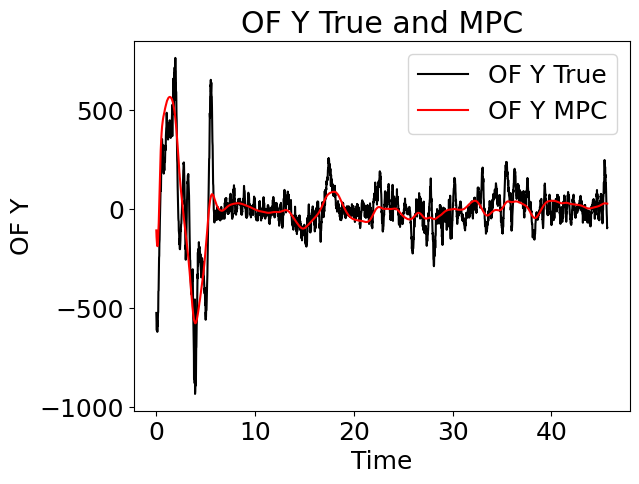

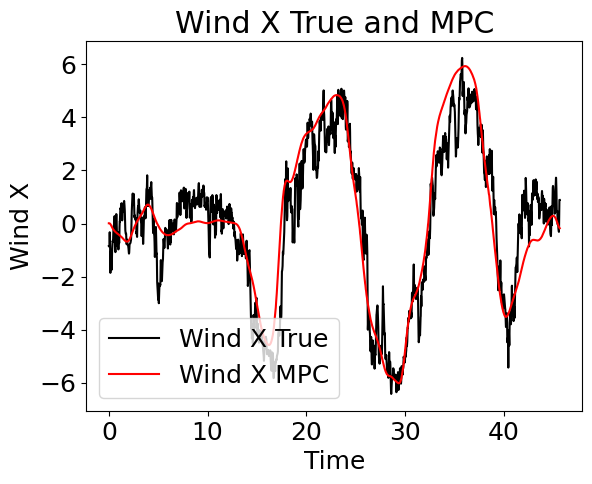

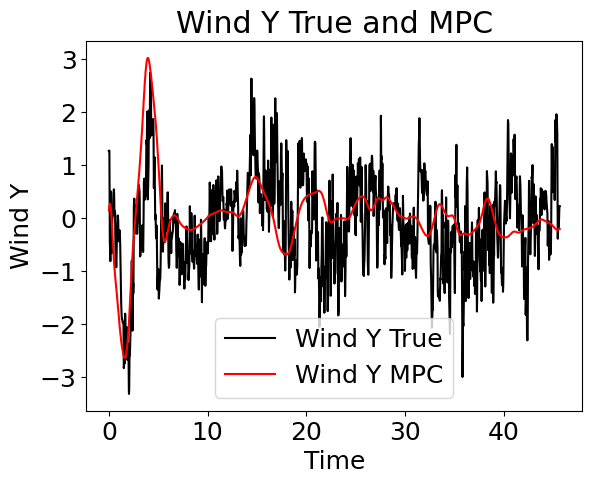

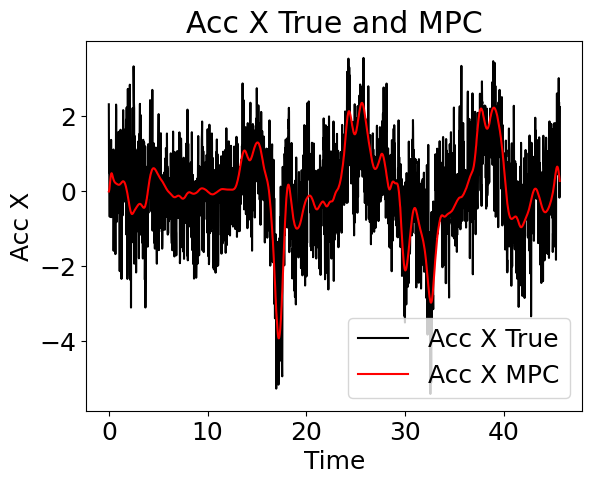

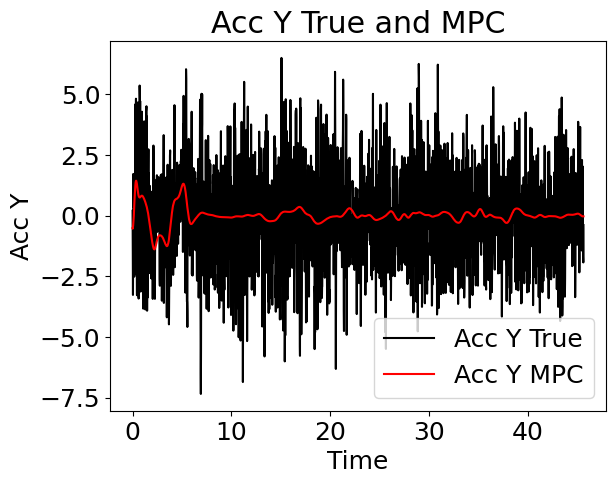

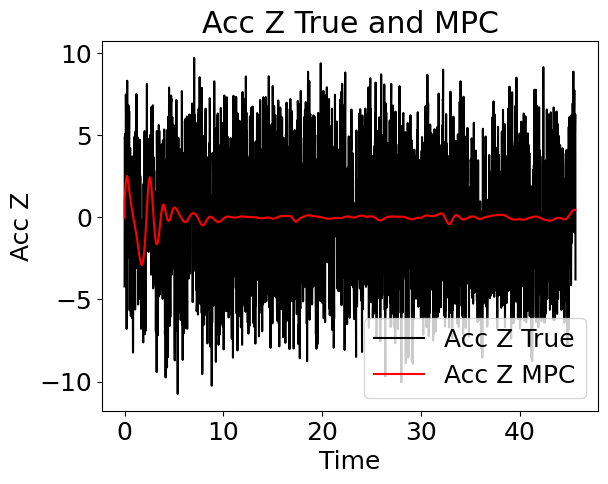

In [144]:
# make MPC measurements from the MPC states and control inputs and compare to the true measurements
# OFx  = (1/OF_X_f)*vx/z
# OFy  = (1/OF_Y_f)*vy/z
# OFz  = (1/OF_Z_f)*vz/z
# Ax   =(vx+wx)/ WIND_X_f
# Ay   =(vy+wy)/ WIND_Y_f
# Az   =(vz+wz)/ WIND_Z_f
# Accx = (1/Real_mM) * (np.cos(phi) * np.sin(theta) * np.cos(psi) + np.sin(phi) * np.sin(psi)) * U1 - (Real_Dl * Ax / Real_mM)
# Accy = (1/Real_mM) * (np.cos(phi) * np.sin(theta) * np.sin(psi) - np.sin(phi) * np.cos(psi)) * U1 - (Real_Dl * Ay / Real_mM)
# Accz = (1/Real_mM) * (np.cos(phi) * np.cos(theta)) * U1 - g - (Real_Dl * Az / Real_mM)
# optical flow
OFx_MPC = (1/OF_X_f)*MPC_X_DOT/MPC_Z
OFy_MPC = (1/OF_Y_f)*MPC_Y_DOT/MPC_Z
OFz_MPC = (1/OF_Z_f)*MPC_Z_DOT/MPC_Z
# Apparent wind
Ax_MPC= (MPC_X_DOT + MPC_WX)/WIND_X_f
Ay_MPC= (MPC_Y_DOT + MPC_WY)/WIND_Y_f
Az_MPC= (MPC_Z_DOT + MPC_WZ)/WIND_Z_f
# relative velocity
Vrx_MPC = MPC_X_DOT + MPC_WX
Vry_MPC = MPC_Y_DOT + MPC_WY
Vrz_MPC = MPC_Z_DOT + MPC_WZ

# Acceleration
Accx_MPC = (1/Real_mM) * (np.cos(MPC_ROLL) * np.sin(MPC_PITCH) * np.cos(MPC_YAW) + np.sin(MPC_ROLL) * np.sin(MPC_YAW)) * F_MPC - (Real_Dl * Vrx_MPC / Real_mM)
Accy_MPC = (1/Real_mM) * (np.cos(MPC_ROLL) * np.sin(MPC_PITCH) * np.sin(MPC_YAW) - np.sin(MPC_ROLL) * np.cos(MPC_YAW)) * F_MPC - (Real_Dl * Vry_MPC / Real_mM)
Accz_MPC = (1/Real_mM) * (np.cos(MPC_ROLL) * np.cos(MPC_PITCH)) * F_MPC - g - (Real_Dl * Vrz_MPC / Real_mM)

# plot the MPC measurements vs the true measurements
plt.plot(TIME, OF_X, label="OF X True",color='black')
plt.plot(TIME, OFx_MPC, label="OF X MPC",color='red')
plt.title('OF X True and MPC')
plt.xlabel('Time')
plt.ylabel('OF X')
plt.legend()
plt.show()

plt.plot(TIME, OF_Y, label="OF Y True",color='black')
plt.plot(TIME, OFy_MPC, label="OF Y MPC",color='red')
plt.title('OF Y True and MPC')
plt.xlabel('Time')
plt.ylabel('OF Y')
plt.legend()
plt.show()

plt.plot(TIME, WIND_X, label="Wind X True",color='black')
plt.plot(TIME, Ax_MPC, label="Wind X MPC",color='red')
plt.title('Wind X True and MPC')
plt.xlabel('Time')
plt.ylabel('Wind X')
plt.legend()
plt.show()

plt.plot(TIME, WIND_Y, label="Wind Y True",color='black')
plt.plot(TIME, Ay_MPC, label="Wind Y MPC",color='red')
plt.title('Wind Y True and MPC')
plt.xlabel('Time')
plt.ylabel('Wind Y')
plt.legend()
plt.show()

plt.plot(TIME, IMU_ACC_X, label="Acc X True",color='black')
plt.plot(TIME, Accx_MPC, label="Acc X MPC",color='red')
plt.title('Acc X True and MPC')
plt.xlabel('Time')
plt.ylabel('Acc X')
plt.legend()
plt.show()

plt.plot(TIME, IMU_ACC_Y, label="Acc Y True",color='black')
plt.plot(TIME, Accy_MPC, label="Acc Y MPC",color='red')
plt.title('Acc Y True and MPC')
plt.xlabel('Time')
plt.ylabel('Acc Y')
plt.legend()
plt.show()

plt.plot(TIME, IMU_ACC_Z, label="Acc Z True",color='black')
plt.plot(TIME, Accz_MPC, label="Acc Z MPC",color='red')
plt.title('Acc Z True and MPC')
plt.xlabel('Time')
plt.ylabel('Acc Z')
plt.legend()
plt.show()




